### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast

Possible TODOs:
- could use a more agentic pattern
  - make each step in the diagram a tool, make a high level coordinating tool with a prompt explaining the sequence of the workflow
  - make different steps independent agents as part of a multi-agent workflow.
- after writing summaries, could parallelize some stuff, topic analysis, ratings
- could also add tools to check format
- rewrite using an critic-refine flow, although one rewrite does an OK job
- do more evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own algo
- retrain reducer, identify a good number of dimensions using silhouette score
- use new stateful OpenAI API, make some persistent assistants instead of complex prompts
- make a UI that allows stepping through the graph using a wizard workflow, editing the state at each step (vars, markdown, dataframes), using time travel to go backwards and forwards.

update umap dimensionality reduction module

1. gather at least 2500 unique stories, do first 80% of days = train, rest = xval
2. run current cluster model in test, number of clusters, stories clustered and silhouette score
3. retrain current cluster params in train , run in test, collect data
4. train new cluster model on full headline + topics + summary, iterate over hyperparameters, gather scores
5. if headlines only are close , possibly retrain with xval on headlines only
6. output silhouette scores daily as part of the process 
7. could refactor the SQLite database, it got a bit messy

In [2]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_state']
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_prompts']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
# del sys.modules['AInewsbot_langgraph']



In [4]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainewsbot.prompts import (
                        REWRITE_SYSTEM_PROMPT, REWRITE_USER_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainewsbot.utilities import log

from ainewsbot.agent import (Agent, AgentState, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [5]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

2025-05-12 17:48:48,047 - AInewsbot - INFO - Initializing with before_date=None, do_download=False, thread_id=3429f74c8968465788bc887dfc2cfe19
2025-05-12 17:48:48,155 - AInewsbot - INFO - thread_id: 3429f74c8968465788bc887dfc2cfe19


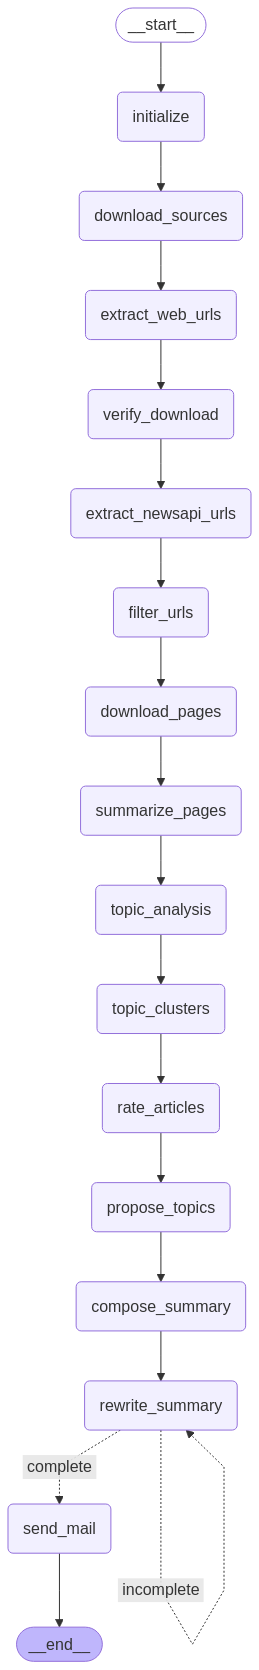

In [6]:
before_date = None
# before_date = '2025-05-11 08:00'
do_download = False

# low, medium, high models
ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1-mini', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [7]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


2025-05-12 17:48:53,657 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-05-12 17:48:53,657 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-05-12 17:48:53,658 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-05-12 17:48:53,658 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-05-12 17:48:53,658 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-05-12 17:48:53,659 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly_AI.html
2025-05-12 17:48:53,659 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

run exception
'src'
run exception
'src'
run exception
'src'


2025-05-12 17:48:53,901 - AInewsbot - INFO - parse_file - found 664 raw links
2025-05-12 17:48:53,909 - AInewsbot - INFO - parse_file - found 165 filtered links
2025-05-12 17:48:53,909 - AInewsbot - INFO - 165 links found
2025-05-12 17:48:53,910 - AInewsbot - INFO - New York Times -> htmldata/New_York_Times.html
2025-05-12 17:48:53,918 - AInewsbot - INFO - parse_file - found 73 raw links
2025-05-12 17:48:53,919 - AInewsbot - INFO - parse_file - found 19 filtered links
2025-05-12 17:48:53,919 - AInewsbot - INFO - 19 links found
2025-05-12 17:48:53,920 - AInewsbot - INFO - Reddit -> htmldata/Reddit.html
2025-05-12 17:48:53,939 - AInewsbot - INFO - parse_file - found 411 raw links
2025-05-12 17:48:53,943 - AInewsbot - INFO - parse_file - found 172 filtered links
2025-05-12 17:48:53,943 - AInewsbot - INFO - 172 links found
2025-05-12 17:48:53,944 - AInewsbot - INFO - Techmeme -> htmldata/Techmeme.html
2025-05-12 17:48:53,959 - AInewsbot - INFO - parse_file - found 406 raw links
2025-05-12 

,id
src,
Ars Technica,31
Bloomberg,28
Business Insider,21
FT,66
Feedly AI,29
Hacker News 1,26
Hacker News 2,23
HackerNoon,131
New York Times,19


2025-05-12 17:48:54,090 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


,id
src,
Ars Technica,31
Bloomberg,28
Business Insider,21
FT,66
Feedly AI,29
Hacker News 1,26
Hacker News 2,23
HackerNoon,131
New York Times,19


2025-05-12 17:48:54,094 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-05-11T17:48:54 from NewsAPI


,id
src,
Ars Technica,31
Bloomberg,28
Business Insider,21
FT,66
Feedly AI,29
Hacker News 1,26
Hacker News 2,23
HackerNoon,131
New York Times,19


2025-05-12 17:48:54,384 - AInewsbot - INFO - Querying SQLite with where_clause: 
2025-05-12 17:48:55,059 - AInewsbot - INFO - URLs in orig_df: 923
2025-05-12 17:48:55,062 - AInewsbot - INFO - Existing URLs in DB: 257686
2025-05-12 17:48:55,124 - AInewsbot - INFO - New URLs in df filtered by URL: 178
2025-05-12 17:48:55,261 - AInewsbot - INFO - Existing src+title: 33
2025-05-12 17:48:55,261 - AInewsbot - INFO - New URLs in df filtered by src+title: 145
2025-05-12 17:48:55,276 - AInewsbot - INFO - Found 145 unique new headlines
2025-05-12 17:48:55,278 - AInewsbot - INFO - Found 143 unique cleaned new headlines
2025-05-12 17:49:07,619 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:49:09,378 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:49:09,411 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:49:09,4

,id
src,
Bloomberg,3
Business Insider,1
FT,1
Feedly AI,24
Hacker News 1,4
Hacker News 2,1
HackerNoon,1
NewsAPI,17
Reddit,1


2025-05-12 17:49:09,507 - AInewsbot - INFO - Queuing URLs for scraping
2025-05-12 17:49:09,509 - AInewsbot - INFO - Saving HTML files using async concurrency= 8
2025-05-12 17:49:09,801 - AInewsbot - INFO - Launching browser
2025-05-12 17:49:11,154 - AInewsbot - INFO - Launching workers
2025-05-12 17:49:11,154 - AInewsbot - INFO - Launching worker
2025-05-12 17:49:11,155 - AInewsbot - INFO - from queue: 0, https://www.techrepublic.com/article/news-stargate-stalls-openai-softbank/ , $100B Stargate AI Project From OpenAI and SoftBank Stalls  Heres Why
2025-05-12 17:49:11,155 - AInewsbot - INFO - fetch_url(https://www.techrepublic.com/article/news-stargate-stalls-openai-softbank/)
2025-05-12 17:49:11,173 - AInewsbot - INFO - Launching worker
2025-05-12 17:49:11,173 - AInewsbot - INFO - from queue: 1, https://www.forbes.com/sites/bernardmarr/2025/05/12/5-ai-agent-myths-you-need-to-stop-believing-now/ , 5 AI Agent Myths You Need To Stop Believing Now
2025-05-12 17:49:11,174 - AInewsbot - INF

2025-05-12 17:49:52,714 - AInewsbot - INFO - from queue: 16, https://zycrypto.com/experts-believe-ruvi-ai-ruvi-has-the-potential-to-grow-by-20000-in-2025-as-btc-trades-around-103000-after-7-surge/ , Experts Believe Ruvi AI (RUVI) Has The Potential to Grow by 20,000% in 2025 as BTC Trades Around $103,000 After 7% Surge
2025-05-12 17:49:52,716 - AInewsbot - INFO - fetch_url(https://zycrypto.com/experts-believe-ruvi-ai-ruvi-has-the-potential-to-grow-by-20000-in-2025-as-btc-trades-around-103000-after-7-surge/)
2025-05-12 17:49:52,717 - AInewsbot - INFO - Waiting 34.65882905460589 seconds to rate limit zycrypto.com 3.1231580420862883
2025-05-12 17:49:56,973 - AInewsbot - INFO - Saving HTML to htmlpages/Apple_could_use_AI_to_help_your_iPhone_save_battery.html
2025-05-12 17:49:57,113 - AInewsbot - INFO - from queue: 17, https://www.pymnts.com/news/investment-tracker/2025/stash-secures-146-million-to-add-ai-to-financial-guidance-platform/ , Financial guidance service Stash says it raised a $14

2025-05-12 17:50:44,469 - AInewsbot - INFO - fetch_url(https://venturebeat.com/ai/new-fully-open-source-vision-encoder-openvision-arrives-to-improve-on-openais-clip-googles-siglip/)
2025-05-12 17:50:51,666 - AInewsbot - INFO - Waiting 47.63054065195527 seconds to rate limit www.pymnts.com 0.036084917024709284
2025-05-12 17:50:53,636 - AInewsbot - INFO - Saving HTML to htmlpages/Experts_Believe_Ruvi_AI__RUVI__Has_The_Potential_to_Grow_by_20_000__in_2025_as_BTC_Trades_Around__103_000_After_7__Surge.html
2025-05-12 17:50:53,900 - AInewsbot - INFO - from queue: 31, https://arstechnica.com/information-technology/2025/05/new-pope-chose-his-name-based-on-ais-threats-to-human-dignity/ , New pope chose his name based on AIs threats to human dignity | Pope Leo XIV warns AI could threaten workers as industrial revolution did in the 1800s.
2025-05-12 17:50:53,902 - AInewsbot - INFO - fetch_url(https://arstechnica.com/information-technology/2025/05/new-pope-chose-his-name-based-on-ais-threats-to-hu

2025-05-12 17:52:38,663 - AInewsbot - INFO - Waiting 17.943356487070616 seconds to rate limit biztoc.com 16.257305416977033
2025-05-12 17:52:41,558 - AInewsbot - INFO - Saving HTML to htmlpages/Perplexity_AI_wrapping_talks_to_raise__500_million_at__14_billion_valuation.html
2025-05-12 17:52:41,802 - AInewsbot - INFO - from queue: 45, https://www.bloomberg.com/news/articles/2025-05-12/state-ai-regulation-ban-tucked-into-republican-tax-fiscal-bill , State AI Regulation Ban Tucked Into Republican Tax, Fiscal Bill
2025-05-12 17:52:41,802 - AInewsbot - INFO - Skipping fetch for 45 https://www.bloomberg.com/news/articles/2025-05-12/state-ai-regulation-ban-tucked-into-republican-tax-fiscal-bill State AI Regulation Ban Tucked Into Republican Tax, Fiscal Bill
2025-05-12 17:52:41,804 - AInewsbot - INFO - from queue: 46, https://techcrunch.com/2025/05/12/teslas-robotaxi-plans-have-the-attention-of-federal-investigators/ , Teslas robotaxi plans have the attention of federal investigators
2025-05-1

2025-05-12 17:53:38,815 - AInewsbot - INFO - Saving HTML to htmlpages/Win_SEO_in_the_Age_of_LLMs__Strategies_for_AI_Visibility.html
2025-05-12 17:53:43,522 - AInewsbot - INFO - Saving HTML to htmlpages/Trump_fires_Copyright_Office_director_after_report_raises_questions_about_AI_training___TechCrunch.html
2025-05-12 17:53:45,531 - AInewsbot - INFO - Waiting 36.85202617334939 seconds to rate limit biztoc.com 0.03662133403122425
2025-05-12 17:54:04,512 - AInewsbot - INFO - Saving HTML to htmlpages/This_Artificial_Intelligence__AI__Software_Stock_--_a_1_090__Gainer_Since_Its_IPO_--_Could_Soar_Another_285___According_to_Dan_Ives._Is_It_Time_to_Buy_Like_There_s_No_Tomorrow.html
2025-05-12 17:54:04,699 - AInewsbot - INFO - Saving HTML to htmlpages/Where_containers_meet_AI__Googles_evolving_Kubernetes_ecosystem.html
2025-05-12 17:54:39,458 - AInewsbot - INFO - Saving HTML to htmlpages/Zuckerberg_Foresees_Tech_Industry_Revolution_With_AI___An_AI_That_Can_Effectively_Be_a_Sort_of_Midlevel_Engine

,id
src,
Bloomberg,3
Business Insider,1
FT,1
Feedly AI,24
Hacker News 1,4
Hacker News 2,1
HackerNoon,1
NewsAPI,17
Reddit,1


2025-05-12 17:54:39,715 - AInewsbot - INFO - Starting summarize
2025-05-12 17:54:39,715 - AInewsbot - INFO - Fetching summaries for all articles
2025-05-12 17:54:39,716 - AInewsbot - INFO - Attempting to fetch summaries for 59 articles
2025-05-12 17:54:39,739 - AInewsbot - INFO - clean_html - Page title: $100B Stargate AI Project From OpenAI and SoftBank Stalls – Here's Why
Social card title: $100B Stargate AI Project From OpenAI and SoftBank Stalls – Here's Why
Social card description: OpenAI CEO Sam Altman confirmed he visited Stargate’s first data center site in Abilene, Texas, which is still moving forward and under development by Oracle.

2025-05-12 17:54:39,901 - AInewsbot - INFO - Queuing 0: Page title: $100B Stargate AI Project From OpenAI ...
2025-05-12 17:54:39,928 - AInewsbot - INFO - clean_html - Page title: 5 AI Agent Myths You Need To Stop Believing Now
Social card title: 5 AI Agent Myths You Need To Stop Believing Now
Social card description: AI agents represent the next

2025-05-12 17:54:40,874 - AInewsbot - INFO - clean_html - Page title: Experts Believe Ruvi AI (RUVI) Has The Potential to Grow by 20,000% in 2025 as BTC Trades Around $103,000 After 7% Surge
Social card title: Experts Believe Ruvi AI (RUVI) Has The Potential to Grow by 20,000% in 2025 as BTC Trades Around $103,000 After 7% Surge
Social card description: Ruvi pushes the innovation roadmap further by combining blockchain technology with artificial intelligence (AI).

2025-05-12 17:54:40,897 - AInewsbot - INFO - Queuing 16: Page title: Experts Believe Ruvi AI (RUVI) Has The...
2025-05-12 17:54:40,909 - AInewsbot - INFO - clean_html - Page title: Earnings Season Shows Merchants Turning to Platforms to Meet Working Capital Needs
Social card title: Stash Secures $146 Million to Add AI to Financial Guidance Platform | PYMNTS.com
Social card description: Stash has secured $146 million in a Series H funding round to deepen its investment in artificial intelligence (AI) for its financial guidanc

2025-05-12 17:54:41,207 - AInewsbot - INFO - Queuing 23: Page title: Founding Engineer—Build AI-Native Ops ...
2025-05-12 17:54:41,211 - AInewsbot - INFO - clean_html - Page title: Memories: Edinburgh ML to Standard ML

2025-05-12 17:54:41,219 - AInewsbot - INFO - Queuing 24: Page title: Memories: Edinburgh ML to Standard ML
...
2025-05-12 17:54:41,234 - AInewsbot - INFO - clean_html - Page title: Microsoft Build 2025: What to expect, from Azure to Copilot upgrades | TechCrunch
Social card title: Microsoft Build 2025: What to expect, from Azure to Copilot upgrades | TechCrunch
Social card description: Microsoft Build 2025 could feature a range of AI upgrades and new services across the company's portfolio.

2025-05-12 17:54:41,254 - AInewsbot - INFO - Queuing 25: Page title: Microsoft Build 2025: What to expect, ...
2025-05-12 17:54:41,266 - AInewsbot - INFO - clean_html - Page title: Earnings Season Shows Merchants Turning to Platforms to Meet Working Capital Needs
Social card title: 

2025-05-12 17:54:41,690 - AInewsbot - INFO - Queuing 39: Page title: Perplexity AI wrapping $500 million ra...
2025-05-12 17:54:41,702 - AInewsbot - INFO - clean_html - Page title: Subscribe to read
Social card title: Perplexity nears second fundraising in six months at $14bn valuation
Social card description: Artificial intelligence search start-up backed by Accel in $500mn round

2025-05-12 17:54:41,721 - AInewsbot - INFO - Queuing 40: Page title: Subscribe to read
Social card title: P...
2025-05-12 17:54:41,735 - AInewsbot - INFO - clean_html - Page title: Perplexity reportedly near $500M funding round at $14B valuation - SiliconANGLE
Social card title: Perplexity reportedly near $500M funding round at $14B valuation - SiliconANGLE
Social card description: Perplexity reportedly near $500M funding round at $14B valuation - SiliconANGLE

2025-05-12 17:54:41,753 - AInewsbot - INFO - Queuing 41: Page title: Perplexity reportedly near $500M fundi...
2025-05-12 17:54:41,756 - AInewsbot - 

2025-05-12 17:54:42,024 - AInewsbot - INFO - clean_html - Page title: Kubernetes at Google Cloud: AI, containers and open source scale - SiliconANGLE
Social card title: Kubernetes at Google Cloud: AI, containers and open source scale - SiliconANGLE
Social card description: Google Cloud is reshaping Kubernetes for the AI era with GKE, Cloud Run and open source innovation, powering containers at enterprise scale.

2025-05-12 17:54:42,047 - AInewsbot - INFO - Queuing 55: Page title: Kubernetes at Google Cloud: AI, contai...
2025-05-12 17:54:42,051 - AInewsbot - INFO - clean_html - Page title: Q&A with Jason Pruet | Los Alamos National Laboratory
Social card title: Q&A with Jason Pruet | Los Alamos National Laboratory
Social card description: A Conversation with an AI Expert on the Technology’s Role in Science and National Security 

2025-05-12 17:54:42,060 - AInewsbot - INFO - Queuing 56: Page title: Q&A with Jason Pruet | Los Alamos Nati...
2025-05-12 17:54:42,078 - AInewsbot - INFO - cl

2025-05-12 17:54:46,668 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:46,715 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:46,717 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:46,898 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:47,043 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:47,595 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:47,608 - AInewsbot - INFO - Received 56 summaries
2025-05-12 17:54:47,609 - AInewsbot - INFO - Summary for 0 (length 3794): • The $100 billion Stargate AI infrastructure project, a joint effort between OpenAI and SoftBank, is stalling due to financing delay

2025-05-12 17:54:47,622 - AInewsbot - INFO - Summary for 12 (length 6567): • Colorado Gov. Jared Polis and other officials have requested delaying the start of the Colorado Artificial Intelligence Act, originally set for February 1, 2026, to January 2027, citing the need for more time to ensure effective and implementable AI regulations.  
• The Colorado Artificial Intelligence Act, signed into law in May 2024, is the first comprehensive state AI regulation in the U.S., imposing new duties to prevent discriminatory outcomes by AI systems in key areas like hiring and lending, affecting companies with over 50 employees.  
• The law has faced criticism from businesses and industry groups for being too vague, broad, and burdensome, with recent efforts to modify and delay it failing due to conflicting stakeholder demands; a special legislative session would be required to make changes before enforcement.
2025-05-12 17:54:47,622 - AInewsbot - INFO - Summary for 13 (length 4264): • Nvidia and

2025-05-12 17:54:47,626 - AInewsbot - INFO - Summary for 24 (length 10516): • Early development of Standard ML involved key contributions such as λ-lifting to improve performance and debates over syntax and module systems, with significant influence from Edinburgh ML and divergent visions between key figures like Dave MacQueen and Gérard Huet.  
• A major schism occurred leading to the creation of Caml, which favored simpler modules and practical UNIX integration, contrasting with Standard ML's formal module system; this division was rooted primarily in disagreements over concrete syntax rather than semantics or overall goals.  
• Despite the schism, Standard ML saw formal definition and multiple compatible implementations (SML/NJ, Poly/ML), with the latter eventually favored in Isabelle theorem proving due to superior parallelism and garbage collection, while Caml (later OCaml) gained institutional support and popularity particularly in the 1990s.
2025-05-12 17:54:47,626 - AInewsbot -

2025-05-12 17:54:47,629 - AInewsbot - INFO - Summary for 36 (length 10042): • OpenAI has introduced a PDF export feature for its Deep Research tool, allowing users to download research reports with preserved formatting, tables, images, and clickable citations, addressing a key business need for sharing verifiable and polished documents.  
• This feature rollout marks a strategic shift towards enterprise markets, supported by new leadership under Instacart CEO Fidji Simo who leads OpenAI’s Applications division focused on practical business solutions beyond core AI research.  
• The update responds to intensifying competition in AI research assistants and reflects a broader industry trend prioritizing workflow integration and usability, with OpenAI emphasizing that such “small” features are critical for enterprise adoption and competitive differentiation.
2025-05-12 17:54:47,629 - AInewsbot - INFO - Summary for 37 (length 5489): • OpenAI and Microsoft are renegotiating the terms of thei

2025-05-12 17:54:47,631 - AInewsbot - INFO - Summary for 50 (length 1621): • Palantir Technologies, an AI software company, has seen its stock surge 1,090% since its IPO, largely due to the company's pivot towards artificial intelligence over the past two years.  
• The company continues to have strong ties with the U.S. Department of Defense but is increasingly focusing on growth in the private sector as its main catalyst.  
• Analyst Dan Ives projects Palantir's stock could increase another 285%, highlighting significant potential upside for investors.
2025-05-12 17:54:47,631 - AInewsbot - INFO - Summary for 51 (length 3165): • Researchers introduced a proof-of-concept audio encoder that represents audio as a sparse set of discrete events with their times of occurrence, aiming for a more interpretable and parsimonious encoding compared to traditional block-coding codecs like MP3 and neural codecs such as Meta's Encodec.  
• The new codec uses rudimentary physics-based models to captu

,id
src,
Bloomberg,3
Business Insider,1
FT,1
Feedly AI,24
Hacker News 1,4
Hacker News 2,1
HackerNoon,1
NewsAPI,17
Reddit,1


2025-05-12 17:54:47,638 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-12 17:54:52,985 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:53,057 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:54,184 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:54,193 - AInewsbot - INFO - 59 free-form topics extracted
2025-05-12 17:54:54,195 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-12 17:54:54,195 - AInewsbot - INFO - Canonical topic history
2025-05-12 17:54:54,196 - AInewsbot - INFO - Canonical topic fintech
2025-05-12 17:54:54,196 - AInewsbot - INFO - Canonical topic privacy
2025-05-12 17:54:54,196 - AInewsbot - INFO - Canonical topic agriculture
20

2025-05-12 17:54:54,219 - AInewsbot - INFO - Canonical topic gaming
2025-05-12 17:54:54,219 - AInewsbot - INFO - Canonical topic testing
2025-05-12 17:54:54,219 - AInewsbot - INFO - Canonical topic deepfakes
2025-05-12 17:54:54,219 - AInewsbot - INFO - Canonical topic energy
2025-05-12 17:54:54,219 - AInewsbot - INFO - Canonical topic job automation
2025-05-12 17:54:54,219 - AInewsbot - INFO - Canonical topic internet of things
2025-05-12 17:54:54,219 - AInewsbot - INFO - Canonical topic food & drink
2025-05-12 17:54:54,220 - AInewsbot - INFO - Canonical topic korea
2025-05-12 17:54:54,220 - AInewsbot - INFO - Canonical topic virtual & augmented reality
2025-05-12 17:54:54,220 - AInewsbot - INFO - Canonical topic health & fitness
2025-05-12 17:54:54,220 - AInewsbot - INFO - Sending prompt for 110 canonical topics
2025-05-12 17:54:57,528 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:57,533 - httpx - INFO - HTTP Request:

2025-05-12 17:54:58,554 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:58,554 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:58,555 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:58,555 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:58,559 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:58,559 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:58,560 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:58,560 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:58,567 - httpx 

2025-05-12 17:54:58,750 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:58,751 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:58,757 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:58,757 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:58,758 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:58,764 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:58,765 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:58,765 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:58,768 - httpx 

2025-05-12 17:54:58,935 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:58,938 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:58,942 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:58,943 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:58,945 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:58,953 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:58,957 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:59,046 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:59,047 - httpx 

2025-05-12 17:54:59,459 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:59,461 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:59,479 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:59,573 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:59,576 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:59,579 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:59,581 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:59,584 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:54:59,588 - httpx 

2025-05-12 17:55:01,180 - AInewsbot - INFO - Queuing 1: ### <<<ARTICLE SUMMARY>>>
# 5 AI Agent Myths You N...
2025-05-12 17:55:01,180 - AInewsbot - INFO - Queuing 2: ### <<<ARTICLE SUMMARY>>>
# AI Startup Perplexity ...
2025-05-12 17:55:01,180 - AInewsbot - INFO - Queuing 3: ### <<<ARTICLE SUMMARY>>>
# AllTrails debuts $80/y...
2025-05-12 17:55:01,181 - AInewsbot - INFO - Queuing 4: ### <<<ARTICLE SUMMARY>>>
# Amazon says the ad tie...
2025-05-12 17:55:01,181 - AInewsbot - INFO - Queuing 5: ### <<<ARTICLE SUMMARY>>>
# Apple and Google Inves...
2025-05-12 17:55:01,181 - AInewsbot - INFO - Queuing 6: ### <<<ARTICLE SUMMARY>>>
# Apple could use AI to ...
2025-05-12 17:55:01,181 - AInewsbot - INFO - Queuing 7: ### <<<ARTICLE SUMMARY>>>
# Apple to Lean on AI To...
2025-05-12 17:55:01,182 - AInewsbot - INFO - Queuing 8: ### <<<ARTICLE SUMMARY>>>
# Build Your Own Siri. L...
2025-05-12 17:55:01,182 - AInewsbot - INFO - Queuing 9: ### <<<ARTICLE SUMMARY>>>
# Byte latent transforme...
2025-05-12

async_langchain: 0, {'input_text': "### <<<ARTICLE SUMMARY>>>\n# $100B Stargate AI Project From OpenAI and SoftBank Stalls  Heres Why\n\n• The $100 billion Stargate AI infrastructure project, a joint effort between OpenAI and SoftBank, is stalling due to financing delays amid rising US tariffs on server racks, chips, and cooling systems, which threaten to increase data center build costs by 5% to 15%.  \n• Despite financing setbacks, OpenAI CEO Sam Altman confirmed the ongoing development of Stargate’s first data center in Abilene, Texas, built by Oracle, and SoftBank has dedicated a sizable team within its Vision Fund to focus on the project.  \n• Investor caution grows due to concerns about AI overcapacity and competition from cheaper AI alternatives, while SoftBank founder Masayoshi Son remains optimistic about Stargate's long-term potential, expecting a 15% to 20% return on a $50 billion investment over five to six years.\n### <<<END>>>\n### <<<CANDIDATE TOPICS>>>\nAI Infrastructur

2025-05-12 17:55:02,200 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:02,201 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:02,220 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:02,274 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:02,383 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:02,399 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:02,423 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:02,457 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:02,486 - httpx 

async_langchain: 0 response: items=['Stargate AI Project', 'AI Infrastructure Financing', 'Data Center Build Costs', 'OpenAI', 'SoftBank', 'Semiconductor Chips']
async_langchain: 1 response: items=['AI Agents', 'Autonomous Digital Services', 'Cybersecurity Risks', 'Human Oversight In AI', 'Safety And Alignment', 'Virtual Assistants']
async_langchain: 6 response: items=['AI Battery Management', 'Apple iOS 19', 'iPhone Battery Optimization', 'Smartphone Power Efficiency', 'WWDC']
async_langchain: 7 response: items=['AI Battery Management', 'Apple iOS 19', 'iPhone Battery Optimization']
async_langchain: 4 response: items=['Amazon Prime Video', 'Ad-Supported Streaming', 'AI Advertising Technology', 'Contextual Ads', 'Interactive Ad Formats']
async_langchain: 17 response: items=['Stash Financial Guidance', 'Series H Funding', 'AI In Personal Finance', 'Merchant Lending Trends', 'User Engagement Metrics', 'Financial Wellness Tools']
async_langchain: 12 response: items=['Colorado AI Regulatio

2025-05-12 17:55:02,537 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:02,561 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:02,563 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:02,716 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:02,724 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 21 response: items=[]
async_langchain: 3 response: items=['AI-Powered Trail Routing', 'AllTrails', 'Competitor Apple Maps', 'Trail Condition Forecasting', 'Outdoor Activity Apps', 'Lifestyle & Travel']
async_langchain: 16 response: items=['Ruvi AI Cryptocurrency', 'Blockchain-AI Projects', 'Crypto Growth Potential', 'Bitcoin Price Surge', 'Healthcare', 'Token Supply Scarcity', 'Supply Chain Optimization']
async_langchain: 10 response: items=['Candy Crush Saga', 'AI In Game Design', 'Game Developer Tools', 'Industry Concerns About AI', 'Job Automation', 'Screen Actors Guild Strike']


2025-05-12 17:55:02,726 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:02,730 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:02,732 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:02,733 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:02,749 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:02,768 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:02,792 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:02,807 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:02,814 - httpx 

async_langchain: 34 response: items=['OpenAI HealthBench Dataset', 'Healthcare AI Benchmarking', 'Gpt-4.1 Medical Evaluation', 'Language Models', 'Health & Fitness', 'Chatbots']
async_langchain: 31 response: items=['Pope Leo XIV', 'Pope Leo XIV AI Warnings', 'AI Ethical Concerns', 'Human Dignity', 'Job Automation', 'Vatican On Technology', 'History']
async_langchain: 18 response: items=['AI And Human Roles', 'Customer Service', 'Duolingo AI Policy', 'Job Automation', 'Klarna Customer Service', 'Public Backlash To AI', 'AI In Education']
async_langchain: 45 response: items=['AI Regulation', 'Political Legislation', 'Tax Policy']
async_langchain: 37 response: items=['OpenAI Microsoft Partnership Renegotiation', 'AI Technology Access', 'Funding', 'Ipos', 'Joint AI Data Centers']
async_langchain: 49 response: items=['AI Management', 'Anthropic', 'Software Development Acceleration', 'Tech Industry AI Adoption', 'Jobs & Careers', 'AI Workforce']
async_langchain: 20 response: items=['Google G

2025-05-12 17:55:02,955 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:02,973 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:02,990 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:03,002 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:03,003 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:03,009 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:03,018 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:03,022 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:03,037 - httpx 

async_langchain: 36 response: items=['OpenAI PDF Export Feature', 'Deep Research Tool', 'Enterprise AI Adoption', 'Products', 'AI Research Assistants']
async_langchain: 27 response: items=['Microsoft OpenAI Investment Deal', 'OpenAI For-Profit Transition', 'Funding', 'Deals', 'Governance']
async_langchain: 23 response: items=['AI In Mental Health Operations', 'AI Infrastructure', 'Large Language Models', 'Legion Health Startup', 'Yc Startup Hiring', 'Healthcare', 'Privacy']
async_langchain: 30 response: items=['OpenVision Vision Encoder', 'Open Source AI Models', 'Computer Vision', 'Multimodal AI Benchmarks', 'Privacy', 'AI Infrastructure']
async_langchain: 57 response: items=['AI Visibility', 'AI-Driven Search', 'Large Language Models', 'Retrieval Augmented Generation', 'SEO Strategies', 'Content Optimization']
async_langchain: 50 response: items=['Palantir Technologies', 'AI Software', 'Stock Performance', 'Private Sector AI Growth', 'Department of Defense', 'IPOs']
async_langchain: 

2025-05-12 17:55:03,243 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:03,246 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:03,248 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:03,251 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:03,252 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:03,280 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:03,281 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:03,348 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:03,369 - httpx 

async_langchain: 15 response: items=['Apple Siri Lawsuit', 'Class Action Lawsuit', 'Privacy Settlement', 'Consumer Claims Process', 'Voice Assistant Privacy']
async_langchain: 11 response: items=['Chegg Layoffs', 'Subscriber Decline', 'Cost Cutting In Edtech', 'AI Competition In Education', 'Legal Action Against Google AI', 'Revenue Decline', 'Impact of AI on Education']
async_langchain: 58 response: items=['AI As Engineer', 'AI In Tech Industry', 'AI Productivity', 'Mark Zuckerberg', 'Tech Startup Innovation']
async_langchain: 43 response: items=['Humain AI Venture', 'Saudi Arabia AI Investment', 'Public Investment Fund Saudi Arabia', 'AI Infrastructure', 'Large Language Models', 'AI Chip Investments', 'Venture Capital']
async_langchain: 5 response: items=['AI-Powered Search', 'Apple Investors', 'ChatGPT Search Competition', 'Google Investors', 'Search Engine Market Impact', 'Stocks']
async_langchain: 48 response: items=['Pope Leo XIV', 'AI Social Impact', 'Human Dignity', 'Environmen

2025-05-12 17:55:03,765 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:03,787 - AInewsbot - INFO - Received 59 responses
2025-05-12 17:55:03,791 - AInewsbot - INFO - End topic analysis


async_langchain: 47 response: items=['AI Training Data', 'Fair Use Law', 'First Amendment', 'Intellectual Property And AI', 'Legal Issues', 'U.S. Copyright Office']


,id
src,
Bloomberg,3
Business Insider,1
FT,1
Feedly AI,24
Hacker News 1,4
Hacker News 2,1
HackerNoon,1
NewsAPI,17
Reddit,1


2025-05-12 17:55:03,804 - AInewsbot - INFO - Fetching embeddings for 59 headlines
2025-05-12 17:55:04,515 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-05-12 17:55:04,643 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-05-12 17:55:04,655 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-05-12 17:55:05,898 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-12 17:55:07,412 - AInewsbot - INFO - Cluster with DBSCAN
2025-05-12 17:55:07,467 - AInewsbot - INFO - Found 3 clusters


,title_topic_str
0,"Colorado Officials Seek Delay in AI Regulations Start Date (Topics: Colorado AI Regulations, Artificial Intelligence Act, AI Discrimination Prevention, Business Opposition to AI Law, Policy and Regulation, State AI Law Implementation)"
1,"State AI Regulation Ban Tucked Into Republican Tax, Fiscal Bill (Topics: AI Regulation, Political Legislation, Tax Policy)"
2,"House Committee Aims to Ban States From Regulating AI (Topics: Colorado AI Regulation, Policy And Regulation, Us Federal AI Regulation, AI Policy Debate, Politics)"


2025-05-12 17:55:08,695 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:08,719 - AInewsbot - INFO - I dub this cluster: Efforts to Restrict State AI Regulations


,title_topic_str
3,"OpenAI Enters 'Tough Negotiation' With Microsoft, Hopes to Raise Money With IPO (Topics: OpenAI Microsoft Negotiations, OpenAI IPO Plans, Funding, Finance, AI Industry Competition, Governance)"
4,"OpenAI negotiating with Microsoft for new funding, future IPO: FT (Topics: OpenAI Microsoft Partnership Renegotiation, AI Technology Access, Funding, Ipos, Joint AI Data Centers)"
5,"OpenAI and Microsoft in Tense Talks Over Future, Say Insiders (Topics: OpenAI Microsoft Tense Talks, Elon Musk Lawsuit, AI Power Concentration Concerns, Finance, Funding, Ipos, Chatbots)"


2025-05-12 17:55:09,918 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:09,930 - AInewsbot - INFO - I dub this cluster: OpenAI and Microsoft Negotiation Talks


,title_topic_str
6,"The New Pope Is Deeply Skeptical of AI (Topics: Pope Leo XIV, AI Social Impact, Human Dignity, Environmental Impact of AI, AI Misinformation, Deepfakes, Labor Market)"
7,"New pope chose his name based on AIs threats to human dignity | Pope Leo XIV warns AI could threaten workers as industrial revolution did in the 1800s. (Topics: Pope Leo XIV, Pope Leo XIV AI Warnings, AI Ethical Concerns, Human Dignity, Job Automation, Vatican On Technology, History)"
8,"Pope Leo XIV says AI poses new challenges for 'human dignity' and 'justice' (Topics: AI Ethics, Human Dignity, Justice And AI, Pope Leo Xiv, Society & Culture)"


2025-05-12 17:55:11,043 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:11,051 - AInewsbot - INFO - I dub this cluster: Pope Leo XIV's Concerns on AI
2025-05-12 17:55:11,058 - AInewsbot - INFO - ['Efforts to Restrict State AI Regulations', 'OpenAI and Microsoft Negotiation Talks', "Pope Leo XIV's Concerns on AI"]


bullets created


[Colorado Officials Seek Delay in AI Regulations Start Date - PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/colorado-officials-seek-delay-ai-regulations-start-date/)

Topics: Colorado AI Regulations, Artificial Intelligence Act, AI Discrimination Prevention, Business Opposition to AI Law, Policy and Regulation, State AI Law Implementation

• Colorado Gov. Jared Polis and other officials have requested delaying the start of the Colorado Artificial Intelligence Act, originally set for February 1, 2026, to January 2027, citing the need for more time to ensure effective and implementable AI regulations.  
• The Colorado Artificial Intelligence Act, signed into law in May 2024, is the first comprehensive state AI regulation in the U.S., imposing new duties to prevent discriminatory outcomes by AI systems in key areas like hiring and lending, affecting companies with over 50 employees.  
• The law has faced criticism from businesses and industry groups for being too vague, broad, and burdensome, with recent efforts to modify and delay it failing due to conflicting stakeholder demands; a special legislative session would be required to make changes before enforcement.



[State AI Regulation Ban Tucked Into Republican Tax, Fiscal Bill - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/state-ai-regulation-ban-tucked-into-republican-tax-fiscal-bill)

Topics: AI Regulation, Political Legislation, Tax Policy





[House Committee Aims to Ban States From Regulating AI - PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/house-committee-aims-ban-states-from-regulating-ai/)

Topics: Colorado AI Regulation, Policy And Regulation, Us Federal AI Regulation, AI Policy Debate, Politics

• A House committee is considering adding a 10-year moratorium on state AI regulations to President Trump's tax and spending bill, aiming to prevent states from creating their own AI rules; however, this language may not be included due to procedural fiscal requirements.  
• Colorado officials, including Gov. Jared Polis, are seeking to delay the implementation of the state's pioneering AI regulations from February 2026 to January 2027, citing the need for more stakeholder work amid industry and consumer group criticisms.  
• The Colorado Artificial Intelligence Act, the first comprehensive AI regulation in the U.S., imposes duties on companies with over 50 employees using AI in important decisions, but faces opposition for being either too strict and vague (from industry) or insufficiently protective (from consumer advocates).



[OpenAI Enters 'Tough Negotiation' With Microsoft, Hopes to Raise Money With IPO - slashdot.org](https://slashdot.org/story/25/05/11/1854234/openai-enters-tough-negotiation-with-microsoft-hopes-to-raise-money-with-ipo)

Topics: OpenAI Microsoft Negotiations, OpenAI IPO Plans, Funding, Finance, AI Industry Competition, Governance

• OpenAI is engaged in "tough negotiations" with Microsoft to rewrite the terms of their multibillion-dollar partnership, focusing on how much equity Microsoft will receive in exchange for its \\$13 billion investment and access to AI technology beyond their 2030 contract.  
• OpenAI aims to restructure and transition to a public benefits corporation, seeking new funding and preparing for a future IPO to compete with Big Tech rivals like Google, but Microsoft's role as a key investor and partner creates tension due to competing business interests.  
• Industry experts highlight that the outcome of these negotiations is critical for OpenAI's future funding capabilities and corporate structure, with Microsoft offering to reduce some equity in exchange for extended technology access, amid concerns over OpenAI's competitive stance and investor relations.



[OpenAI negotiating with Microsoft for new funding, future IPO: FT - New York Post](https://nypost.com/2025/05/11/business/openai-negotiating-with-microsoft-for-new-funding-future-ipo-ft/)

Topics: OpenAI Microsoft Partnership Renegotiation, AI Technology Access, Funding, Ipos, Joint AI Data Centers

• OpenAI and Microsoft are renegotiating the terms of their multibillion-dollar partnership to enable OpenAI's future IPO while ensuring Microsoft retains access to advanced AI technologies beyond the current 2030 agreement cutoff.  
• A key point under discussion is the equity Microsoft will hold in OpenAI’s new for-profit business, with Microsoft reportedly willing to reduce its stake in exchange for ongoing technology access.  
• The revision includes updates to their original 2019 deal, following Microsoft’s \\$13 billion investment and recent strategic moves like forming a joint venture with Oracle and SoftBank to develop AI data centers in the U.S.



[OpenAI and Microsoft in Tense Talks Over Future, Say Insiders - iPhone in Canada](https://www.iphoneincanada.ca/2025/05/11/openai-and-microsoft-in-tense-talks-over-future-say-insiders/)

Topics: OpenAI Microsoft Tense Talks, Elon Musk Lawsuit, AI Power Concentration Concerns, Finance, Funding, Ipos, Chatbots

• OpenAI and Microsoft are engaged in tense negotiations over OpenAI’s restructuring plan to go public, with OpenAI seeking to raise funds outside its original capped-profit structure, while Microsoft demands long-term access to AI technology and criticizes OpenAI’s perceived arrogance.  
• Elon Musk is suing to block OpenAI’s restructuring, claiming the move improperly shifts assets from the nonprofit to private hands, a concern echoed by former OpenAI employee Page Hedley about concentrating AI power and wealth among investors.  
• Failure to reach a deal could hinder OpenAI’s ability to secure future funding and compete with competitors like Google’s AI chatbot Gemini, highlighting the high stakes of the ongoing discussions.



[The New Pope Is Deeply Skeptical of AI - Futurism](https://futurism.com/the-byte/new-pope-skeptical-ai)

Topics: Pope Leo XIV, AI Social Impact, Human Dignity, Environmental Impact of AI, AI Misinformation, Deepfakes, Labor Market

• Newly-crowned Pope Leo XIV, formerly cardinal Robert Prevost of Chicago, chose his papal name inspired by Pope Leo XIII, highlighting concerns over AI's social impact similar to those during the Industrial Revolution.  
• In his first Sunday address, Pope Leo XIV emphasized AI's challenges to human dignity, justice, and labor, positioning the Church to address these issues amid rapid technological advancement.  
• The Pope highlighted real-world negative impacts of AI technology, including environmental harm from data centers, psychological risks from AI companions, and proliferation of misinformation and deepfakes.



[New pope chose his name based on AIs threats to human dignity | Pope Leo XIV warns AI could threaten workers as industrial revolution did in the 1800s. - Ars Technica](https://arstechnica.com/information-technology/2025/05/new-pope-chose-his-name-based-on-ais-threats-to-human-dignity/)

Topics: Pope Leo XIV, Pope Leo XIV AI Warnings, AI Ethical Concerns, Human Dignity, Job Automation, Vatican On Technology, History

• Newly elected Pope Leo XIV, formerly Robert Prevost, chose his papal name to highlight concerns about artificial intelligence (AI), likening AI's impact to the Industrial Revolution addressed by Pope Leo XIII in his 1891 encyclical Rerum Novarum.  
• In his first address, Pope Leo XIV described AI as "another industrial revolution," continuing the Vatican's focus on defending human dignity amid technological change, a priority initiated by Pope Francis before his death.  
• Pope Francis had previously warned against AI fostering "violence and discrimination" and referenced potential dangers of AI in the 2023 document "Antiqua et Nova," emphasizing ethical considerations in AI development.



[Pope Leo XIV says AI poses new challenges for 'human dignity' and 'justice' - biztoc.com](https://biztoc.com/x/1dad1677fa79c82a)

Topics: AI Ethics, Human Dignity, Justice And AI, Pope Leo Xiv, Society & Culture

• Pope Leo XIV addressed the College of Cardinals, stating that artificial intelligence poses "new challenges" for "human dignity" and "justice."  
• The Pope's remarks highlight concerns about the ethical and social implications of AI technology.  
• Pope Leo XIV was recently elected by the College of Cardinals and is speaking publicly on key modern issues.



[Apple and Google Investors Fret as ChatGPT Gains Search Ground - biztoc.com](https://biztoc.com/x/c5b23e1e6c0750ae)

Topics: AI-Powered Search, Apple Investors, ChatGPT Search Competition, Google Investors, Search Engine Market Impact, Stocks

• Investors in Apple and Google are increasingly concerned about the rising popularity of AI-powered search tools like ChatGPT, leading to market unease.  
• Google’s shares dropped 8% last week following remarks from an Apple executive regarding AI search capabilities.  
• The growing traction of AI search platforms poses a competitive threat to traditional search engines dominated by Apple and Google.



[Going 'AI-first' appears to be backfiring on Klarna and Duolingo - Fast Company](https://www.fastcompany.com/91332763/going-ai-first-appears-to-be-backfiring-on-klarna-and-duolingo)

Topics: AI And Human Roles, Customer Service, Duolingo AI Policy, Job Automation, Klarna Customer Service, Public Backlash To AI, AI In Education

• Klarna is reversing its previous AI-heavy approach by planning a hiring spree to add human customer service representatives, emphasizing the need for quality human support alongside AI.  
• Duolingo’s recent AI-first policy, which cuts contractor roles in favor of automation, has sparked significant public backlash on social media, with many users expressing disappointment and deleting the app.  
• Duolingo clarifies that AI is meant to assist, not replace, human learning experts, and stresses its commitment to human oversight in AI-driven education enhancements.



[Apple to Lean on AI Tool to Help iPhone Battery Life for Devices in iOS 19 - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/apple-plans-ai-powered-battery-management-mode-for-devices-in-ios-19)

Topics: AI Battery Management, Apple iOS 19, iPhone Battery Optimization





[The age of incredibly powerful 'manager nerds' is upon us, Anthropic cofounder says - Business Insider](https://www.businessinsider.com/anthropic-cofounder-jack-clark-ai-manager-nerds-2025-5)

Topics: AI Management, Anthropic, Software Development Acceleration, Tech Industry AI Adoption, Jobs & Careers, AI Workforce

• Anthropic cofounder Jack Clark predicts an era of "manager nerds," where managers will oversee fleets of AI agents performing large amounts of work, enabling smaller teams to achieve more.  
• Other tech leaders like Meta CEO Mark Zuckerberg and Y Combinator CEO Garry Tan also foresee AI allowing smaller, talent-dense teams to scale work efficiently, with Tan highlighting "vibe coding" to accelerate software development.  
• Anthropic and experts caution about risks of overreliance on AI, emphasizing a future where developers and managers focus on delegating, reviewing, and guiding AI-generated work rather than manual coding.



[Nasdaq Recovery: 3 Artificial Intelligence (AI) Stocks That Are Still Too Cheap to Ignore - consent.yahoo.com](https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_6e40117c-7766-4943-98a1-08a7e4054ea0)

Topics: 

• no content



[New AI tool predicts your biological age from a selfie - The Washington Post](https://www.washingtonpost.com/science/2025/05/12/ai-tool-biological-age-faceage/)

Topics: Biological Age Prediction, FaceAge AI Tool, Health Outcome AI, Computer Vision, Healthcare

• Scientists at Mass General Brigham in Boston have developed an AI tool called FaceAge that predicts a patient's biological age from a photograph.  
• FaceAge analyzes facial features to estimate not only true biological age but also potential health outcomes, including odds of surviving diseases like cancer.  
• This AI technology suggests faces carry indicators of underlying health and longevity beyond chronological age.



[Microsoft and OpenAI renegotiate investment deal: Report - Cointelegraph](https://cointelegraph.com/news/microsoft-open-ai-renegotiate-equity-deal)

Topics: Microsoft OpenAI Investment Deal, OpenAI For-Profit Transition, Funding, Deals, Governance

• Microsoft and OpenAI are renegotiating their investment deal, with Microsoft potentially giving up some equity in exchange for continued access to OpenAI’s products and models beyond the deal’s 2030 expiration.  
• Microsoft has invested over \\$13 billion in OpenAI since 2019, and the deal renegotiation is crucial for OpenAI's ongoing restructuring and future operations.  
• OpenAI, originally founded as a non-profit in 2015, faced internal and external pushback—including from co-founder Elon Musk—over plans to shift to a for-profit model; in May 2025, OpenAI pivoted to a public benefit corporation model to balance profit with social objectives.



[Perplexity reportedly near \\$500M funding round at \\$14B valuation - SiliconANGLE](https://siliconangle.com/2025/05/12/perplexity-reportedly-near-500m-funding-round-14b-valuation/)

Topics: Perplexity AI, Funding, Large Language Models, AI Revenue Models, AI Developer Tools, AI-Powered Browser, Venture Capital

• Search engine startup Perplexity AI is reportedly in late-stage talks to raise \\$500 million at a \\$14 billion valuation, led by Accel, following over \\$900 million raised across four rounds last year.  
• Perplexity's product uses large language models to provide direct, natural language answers to search queries and serves more than 15 million monthly users; it generates revenue through individual and enterprise paid plans.  
• The company recently expanded into developer tools with its Sonar API family, enabling AI-powered search integrations, and plans to launch an AI-powered browser called Comet; reported annual recurring revenue is just under \\$100 million.



[Teslas robotaxi plans have the attention of federal investigators - TechCrunch](https://techcrunch.com/2025/05/12/teslas-robotaxi-plans-have-the-attention-of-federal-investigators/)

Topics: Tesla Robotaxi, NHTSA Investigation, Full Self-Driving Software, Safety and Alignment, Elon Musk, Policy and Regulation

• The National Highway Traffic Safety Administration (NHTSA) is investigating Tesla’s upcoming robotaxi service and its Full Self-Driving (Supervised) software, focusing on its operation in low-visibility conditions following four crashes.  
• NHTSA sent Tesla detailed questions about the robotaxi fleet size, vehicle models, safety evaluation methods, and the relationship between the robotaxi system and the current FSD Supervised product.  
• Tesla has publicly announced plans to launch a paid robotaxi ride-hailing service in Austin, Texas, this June, using a supervised version of its Full Self-Driving software, while CEO Elon Musk has mentioned an unreleased “unsupervised” FSD version for future use.



[Perplexity AI wrapping talks to raise \\$500 million at \\$14 billion valuation - CNBC](https://www.cnbc.com/2025/05/12/perplexity-funding-round-comet.html)

Topics: Perplexity AI, Perplexity AI Funding, AI Search Engine Competition, AI Agent Web Browser, Venture Capital, Finance

• Perplexity AI is in late-stage talks to raise \\$500 million at a \\$14 billion valuation, with Accel leading the funding round, marking a decrease from earlier discussions targeting up to \\$1 billion at an \\$18 billion valuation.  
• The AI search engine, competing against Google and Microsoft-backed OpenAI, has grown rapidly, increasing its valuation from \\$3 billion in June 2024 to \\$9 billion in December 2023 and now \\$14 billion.  
• Perplexity is preparing to launch its AI agent web browser, Comet, amid intensifying competition from Anthropic’s Claude and OpenAI’s ChatGPT search features, as well as Google’s AI integrations in search.



[Legion Health (YC S21) is hiring engineers to help fix mental health with AI - Work at a Startup](https://www.workatastartup.com/jobs/75011)

Topics: AI In Mental Health Operations, AI Infrastructure, Large Language Models, Legion Health Startup, Yc Startup Hiring, Healthcare, Privacy

• Legion Health, a YC S21-backed startup with \\$1M+ ARR, is building an AI-native operations platform for psychiatric care focusing on backend processes like scheduling, documentation, billing, intake, and risk detection rather than diagnostics.  
• Their system, powered by LLM agents and structured event-driven architecture, is live and supports over 2,000 patients with minimal human support, integrating real-time AI tools that automate and improve mental health clinic workflows.  
• The company seeks founding engineers to own end-to-end system domains, work closely with the CTO, and innovate AI infrastructure that transforms mental health operations, emphasizing speed, system design, HIPAA compliance, and direct impact on patient care.



[Toward a Sparse and Interpretable Audio Codec - arXiv](https://arxiv.org/abs/2505.05654)

Topics: Audio Codec, Interpretable Audio Representation, Sparse Encoding, Physics-Based Audio Modeling

• Researchers introduced a proof-of-concept audio encoder that represents audio as a sparse set of discrete events with their times of occurrence, aiming for a more interpretable and parsimonious encoding compared to traditional block-coding codecs like MP3 and neural codecs such as Meta's Encodec.  
• The new codec uses rudimentary physics-based models to capture the attack, instrument resonance, and room acoustics to produce an intuitive representation of audio signals.  
• This sparse and interpretable approach contrasts with existing codecs that focus on overlapping fixed-size frame compression, which often lack directly interpretable outputs despite high-quality reproduction.



[Why National Labs are investing (heavily) in AI - www.lanl.gov](https://www.lanl.gov/media/publications/1663/0125-qa-jason-pruet)

Topics: AI Infrastructure, AI Investment, Los Alamos National Laboratory, National Labs, National Security, Energy, Transformers

• Jason Pruet, Director of Los Alamos National Laboratory’s National Security AI Office, emphasizes AI as a transformative force reshaping science and national security, requiring substantial government investment akin to post-WWII scientific infrastructure development.  
• The Lab provides universities access to large-scale AI computing resources, such as the 2500-GPU Venado system, to foster collaboration and advance national AI programs focused on security and energy.  
• Pruet highlights the rapid progress driven by transformer AI models since 2017, the global strategic competition in AI development, and the importance of international cooperation to manage AI risks while maintaining U.S. leadership.



[This Artificial Intelligence (AI) Software Stock -- a 1,090% Gainer Since Its IPO -- Could Soar Another 285%, According to Dan Ives. Is It Time to Buy Like There's No Tomorrow? - biztoc.com](https://biztoc.com/x/16511370a35156ec)

Topics: Palantir Technologies, AI Software, Stock Performance, Private Sector AI Growth, Department of Defense, IPOs

• Palantir Technologies, an AI software company, has seen its stock surge 1,090% since its IPO, largely due to the company's pivot towards artificial intelligence over the past two years.  
• The company continues to have strong ties with the U.S. Department of Defense but is increasingly focusing on growth in the private sector as its main catalyst.  
• Analyst Dan Ives projects Palantir's stock could increase another 285%, highlighting significant potential upside for investors.



[The Copyright Office Issues A Largely Disappointing Report On AI Training, And Once Again A Major Fair Use Analysis Inexplicably Ignores The First Amendment - Techdirt](https://www.techdirt.com/2025/05/12/the-copyright-office-issues-a-largely-disappointing-report-on-ai-training-and-once-again-a-major-fair-use-analysis-inexplicably-ignores-the-first-amendment/)

Topics: AI Training Data, Fair Use Law, First Amendment, Intellectual Property And AI, Legal Issues, U.S. Copyright Office

• The U.S. Copyright Office released the third report in a study on AI and copyright law, focusing on whether training AI models on copyrighted works constitutes fair use, but the report notably omits any mention of the First Amendment despite submitted public comments emphasizing its importance.  
• The report recognizes that training on licensed works alone could bias AI models, and that training large, diverse datasets can be transformative, which is a key factor in fair use, yet it heavily weighs market harm concerns over transformative use, mirroring trends seen in recent Supreme Court and circuit court decisions.  
• Critics highlight that the failure to incorporate First Amendment analysis in the fair use discussion weakens the report’s influence on future court interpretations and legislative guidance, as fair use is a critical way copyright law aligns with free speech protections.



[Perplexity nears second fundraising in six months at \\$14bn valuation - Financial Times](https://www.ft.com/content/7621cd5f-901e-4948-879d-011e0edb3bed)

Topics: Perplexity AI, Artificial Intelligence Search, AI Fundraising, Venture Capital, Finance

• Perplexity, an artificial intelligence search start-up backed by Accel, is approaching its second fundraising round within six months, aiming for a \\$14 billion valuation.  
• The company is reportedly seeking \\$500 million in this funding round.  
• This development highlights the rapid growth and investor confidence in AI-driven search technologies.



[Chegg says subs dropped 31% in Q1 to 3.2M; it will lay off 248 employees, or ~22% of its staff, to cut costs as students keep turning to AI tools like ChatGPT - Reuters](https://www.reuters.com/world/americas/chegg-lay-off-22-workforce-ai-tools-shake-up-edtech-industry-2025-05-12/)

Topics: Chegg Layoffs, Subscriber Decline, Cost Cutting In Edtech, AI Competition In Education, Legal Action Against Google AI, Revenue Decline, Impact of AI on Education

• Chegg announced layoffs of about 22% of its workforce, or 248 employees, to reduce costs amid declining demand as students shift toward AI-powered tools like ChatGPT.  
• The company plans to close its U.S. and Canada offices by the end of the year and cut marketing, product development, and administrative expenses, expecting \\$45-\\$55 million in cost savings in 2025 and \\$100-\\$110 million in 2026.  
• Chegg reported a 31% drop in subscribers to 3.2 million and a 30% revenue decline to \\$121 million in Q1 2024, attributing declines partly to competition from AI platforms and ongoing legal action against Google for its AI-generated search overviews.



[Google's new AI video feature is rolling out on another company's smartphones - TechRadar](https://www.techradar.com/computing/artificial-intelligence/googles-new-ai-video-feature-is-rolling-out-on-another-companys-smartphones)

Topics: Google AI Video Feature, Honor Smartphones, Image-To-Video AI, On-Device AI Processing, Google Cloud Partnership, Deals

• Google's new AI image-to-video feature, powered by the Veo 2 model, is first launching on Honor's upcoming 400 series smartphones, ahead of Google Pixel devices.  
• The tool converts a single image into a five-second animated video, simulating movements like blinking or camera shifts, and operates entirely on-device without requiring cloud access or a subscription.  
• This rollout is part of a deal between Google Cloud and Honor, signaling Google's strategy to expand AI capabilities across the Android ecosystem rather than limiting them to its own hardware.



[Dont delete that Lopez Voice Assistant email  its about Apples Siri settlement - The Verge](https://www.theverge.com/news/664927/lopez-voice-assistant-emails-apple-siri-spying-settlement)

Topics: Apple Siri Lawsuit, Class Action Lawsuit, Privacy Settlement, Consumer Claims Process, Voice Assistant Privacy

• Apple settled a 2019 class action lawsuit, Lopez v. Apple Inc., for \\$95 million over allegations that Siri recorded private conversations and shared them with third-party contractors, which Apple denies.  
• US owners of Siri-enabled devices between September 17, 2014, and December 31, 2024, who experienced unintended Siri activations during private conversations are eligible to claim up to \\$100 by July 2, 2025.  
• Settlement notification emails titled "Lopez Voice Assistant Class Action Settlement" are legitimate and contain claimant codes and instructions for submitting claims.



[Zuckerberg Foresees Tech Industry Revolution With AI: 'An AI That Can Effectively Be a Sort of Midlevel Engineer' - biztoc.com](https://biztoc.com/x/84f2982a96959c3f)

Topics: AI As Engineer, AI In Tech Industry, AI Productivity, Mark Zuckerberg, Tech Startup Innovation

• Meta CEO Mark Zuckerberg predicted a major transformation in the tech industry driven by artificial intelligence, describing AI as potentially functioning like a "midlevel engineer."  
• Speaking at the Stripe Sessions conference, Zuckerberg encouraged entrepreneurs to leverage AI technology to innovate and grow their startups.  
• He emphasized the significant advantages AI offers for boosting productivity and accelerating development in the technology sector.



[Memories: Edinburgh ML to Standard ML - lawrencecpaulson.github.io](https://lawrencecpaulson.github.io/2022/10/05/Standard_ML.html)

Topics: Edinburgh ML history, Standard ML development, Caml and OCaml language split

• Early development of Standard ML involved key contributions such as λ-lifting to improve performance and debates over syntax and module systems, with significant influence from Edinburgh ML and divergent visions between key figures like Dave MacQueen and Gérard Huet.  
• A major schism occurred leading to the creation of Caml, which favored simpler modules and practical UNIX integration, contrasting with Standard ML's formal module system; this division was rooted primarily in disagreements over concrete syntax rather than semantics or overall goals.  
• Despite the schism, Standard ML saw formal definition and multiple compatible implementations (SML/NJ, Poly/ML), with the latter eventually favored in Isabelle theorem proving due to superior parallelism and garbage collection, while Caml (later OCaml) gained institutional support and popularity particularly in the 1990s.



[Amazon says the ad tier of Prime Video now reaches 130M+ US customers and it plans AI-powered tools for advertisers on Amazon including contextual ad copy - Hollywood Reporter](https://www.hollywoodreporter.com/business/digital/prime-video-reach-130-million-us-amazon-says-1236213847/)

Topics: Amazon Prime Video, Ad-Supported Streaming, AI Advertising Technology, Contextual Ads, Interactive Ad Formats

• Amazon's Prime Video ad-supported tier now reaches over 130 million U.S. customers, up from 115 million last year, highlighting its growing scale and reach.  
• Prime Video plans to introduce new AI-powered ad technology at its 2025 upfront event, including auto-generated contextual ad messaging, shoppable ads with real-time pricing and reviews, and interactive formats driving sales both on and off Amazon.  
• Alan Moss, VP of global ads sales for Amazon Ads, emphasized that these innovations will create "scene-aware" ads that feel like natural extensions of content rather than interruptions, leveraging Amazon's extensive consumer data and shopping signals.



[AllTrails debuts \\$80/year membership that includes AI-powered smart routes - TechCrunch](https://techcrunch.com/2025/05/12/alltrails-debuts-a-80-year-membership-that-includes-ai-powered-smart-routes/)

Topics: AI-Powered Trail Routing, AllTrails, Competitor Apple Maps, Trail Condition Forecasting, Outdoor Activity Apps, Lifestyle & Travel

• AllTrails has launched a new \\$80/year premium membership called “Peak” featuring AI-powered custom trail routing, real-time trail condition forecasts, trail traffic heatmaps, and an Outdoor Lens for plant and tree identification.  
• The AI tools allow users to create or modify trails to be shorter, less steep, or more scenic, while the trail condition forecasts include temperature, precipitation, insect activity, and air quality alerts.  
• The update comes amid competition from Apple Maps, and AllTrails is also enhancing its free Base and Plus memberships with new Points of Interest and offline map features.



[Google: Gemma AI Model Surpasses 150 Million Downloads - PYMNTS](https://www.pymnts.com/google/2025/google-gemma-ai-model-surpasses-150-million-downloads/)

Topics: Google Gemma AI Model, Open Source, Language Models, AI Chatbot Advertising, Platform Lending For Merchants, Fintech, Economics

• Google's open-source AI model Gemma has surpassed 150 million downloads with over 70,000 variants created on Hugging Face, highlighting its efficiency and portability compared to larger models like Meta’s Llama-2.  
• Google is integrating ads into AI chatbot conversations to protect its ad search business, which accounts for over half its revenue, amid rising competition from OpenAI’s ChatGPT dominating the chatbot market.  
• Recent earnings reports from PayPal, Shopify, and Block reveal merchants increasingly rely on platform-based loans and advances to meet working capital needs, with PayPal reporting \\$1.6 billion in outstanding merchant loans and a 32% year-over-year increase, signaling growing demand for embedded lending solutions among small businesses.



[New fully open source vision encoder OpenVision arrives to improve on OpenAI's Clip, Google's SigLIP - VentureBeat](https://venturebeat.com/ai/new-fully-open-source-vision-encoder-openvision-arrives-to-improve-on-openais-clip-googles-siglip/)

Topics: OpenVision Vision Encoder, Open Source AI Models, Computer Vision, Multimodal AI Benchmarks, Privacy, AI Infrastructure

• The University of California, Santa Cruz released OpenVision, an open-source family of 26 vision encoders licensed under Apache 2.0, designed to improve on OpenAI’s CLIP and Google’s SigLIP by providing scalable models for both server-grade and edge deployments.  
• OpenVision demonstrates strong multimodal performance, outperforming CLIP and SigLIP in benchmarks including TextVQA, ChartQA, MME, and OCR, and uses progressive resolution training to reduce compute costs by 2-3 times without sacrificing accuracy.  
• The open, modular design offers enterprise users enhanced customization, integration with existing AI frameworks, reduced vendor lock-in, improved data security for sensitive visual data, and flexibility for diverse deployment scenarios across cloud and edge environments.



[Obama Says Only 'The Best Coders' Will Survive As AI Takes Over 60%70% Of Programming Jobs  'You Just Won't Need A Coder' - biztoc.com](https://biztoc.com/x/499b02fb6604c3dc)

Topics: AI and Programming Jobs, Barack Obama AI Impact, Future of Coding, Job Automation

• Former President Barack Obama stated at Hamilton College that artificial intelligence will replace 60–70% of programming jobs, suggesting that only the best coders will survive as AI outperforms most programmers.  
• Obama emphasized that with AI advancements, "you just won't need a coder" for many tasks, highlighting the significant shift AI poses to the software development industry.  
• This development marks a major impact of AI beyond manufacturing and production lines, directly affecting high-skill technology roles.



[Should You Buy Nvidia Before May 19? - biztoc.com](https://biztoc.com/x/2d021e9e5bfc2846)

Topics: Nvidia Stock, AI Hardware, Import Tariffs, Economics, Investor Concerns

• Nvidia's stock has surged due to its popularity among customers building artificial intelligence platforms.  
• Recently, Nvidia shares have declined amid concerns about import tariffs and economic uncertainty.  
• Investors are closely monitoring Nvidia ahead of May 19 for potential developments affecting the stock's performance.



[5 AI Agent Myths You Need To Stop Believing Now - Forbes](https://www.forbes.com/sites/bernardmarr/2025/05/12/5-ai-agent-myths-you-need-to-stop-believing-now/)

Topics: AI Agents, Autonomous Digital Services, Cybersecurity Risks, Human Oversight In AI, Safety And Alignment, Virtual Assistants

• AI agents go beyond chatbots by autonomously interacting with digital services and software to complete complex tasks, acting as a project manager that delegates to specialized tools.  
• While current AI agents have limited capabilities, they are expected to rapidly evolve to handle a wide range of everyday tasks, such as managing schedules, shopping, booking appointments, and even creating complex virtual worlds.  
• Despite their sophistication, AI agents can be fooled or manipulated, raising concerns about new forms of cybercrime and the need for human oversight, which remains essential since agentic AI still makes frequent mistakes and ethical accountability is crucial.



[DOGE Grows By 30%, But Experts Suggest Ruvi AI (RUVI) To be The Hidden Crypto to Grow by 20,000% in 2025 - zycrypto.com](https://zycrypto.com/doge-grows-by-30-but-experts-suggest-ruvi-ai-ruvi-to-be-the-hidden-crypto-to-grow-by-20000-in-2025/)

Topics: Dogecoin (DOGE), Ruvi AI Cryptocurrency, Blockchain and AI Integration, Healthcare, Supply Chain Optimization, Crypto Market Forecast, Token Presale Offers

• Dogecoin (DOGE) surged nearly 15% in 24 hours, reaching a price of \\$0.2365 and maintaining a strong \\$35.29 billion market cap, driven by its widespread adoption and community support.  
• Ruvi AI (RUVI) is emerging as a potential major crypto player by integrating blockchain with AI to address real-world issues in healthcare, logistics, and supply chain, with a capped token supply of 5 billion promising scarcity-driven value.  
• Currently in presale with up to 100% bonus offers for early investors, Ruvi aims to replicate or surpass Dogecoin’s success by focusing on utility and innovation rather than meme status, though this sponsored message advises independent research.



[\\$100B Stargate AI Project From OpenAI and SoftBank Stalls  Heres Why - TechRepublic](https://www.techrepublic.com/article/news-stargate-stalls-openai-softbank/)

Topics: Stargate AI Project, AI Infrastructure Financing, Data Center Build Costs, OpenAI, SoftBank, Semiconductor Chips

• The \\$100 billion Stargate AI infrastructure project, a joint effort between OpenAI and SoftBank, is stalling due to financing delays amid rising US tariffs on server racks, chips, and cooling systems, which threaten to increase data center build costs by 5% to 15%.  
• Despite financing setbacks, OpenAI CEO Sam Altman confirmed the ongoing development of Stargate’s first data center in Abilene, Texas, built by Oracle, and SoftBank has dedicated a sizable team within its Vision Fund to focus on the project.  
• Investor caution grows due to concerns about AI overcapacity and competition from cheaper AI alternatives, while SoftBank founder Masayoshi Son remains optimistic about Stargate's long-term potential, expecting a 15% to 20% return on a \\$50 billion investment over five to six years.



[Computex showdown: Nvidia & MediaTek tipped to steal Windows-on-Arm spotlight - Laptop Mag](https://www.laptopmag.com/laptops/computex-showdown-nvidia-and-mediatek-tipped-to-steal-windows-on-arm-spotlight)

Topics: Arm-Based Chips, Computex Announcements, MediaTek CPUs, Nvidia Processors, Windows-On-Arm Devices

• Nvidia and MediaTek are expected to unveil new, smaller Arm-based laptop and desktop processors called N1X and N1 at Computex next week, combining MediaTek's CPUs and Nvidia's Blackwell GPU technology.  
• These chips will run Windows OS optimized for Arm, positioning them as competitors to Qualcomm's Snapdragon X series and AMD's Ryzen AI Max APU, with anticipated availability in early 2026.  
• The announcement at Computex comes as Qualcomm focuses more on AI, potentially allowing Nvidia and MediaTek to dominate the Windows-on-Arm conversation at the trade show.



[AI Startup Perplexity Nears Funding at \\$14 Billion Value - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/ai-search-startup-perplexity-nears-funding-at-14-billion-value)

Topics: AI Funding Valuation, Perplexity AI Startup, Venture Capital, Finance





[Where containers meet AI: Googles evolving Kubernetes ecosystem - SiliconANGLE](https://siliconangle.com/2025/05/12/kubernetes-meets-ai-inside-google-cloud-evolving-container-stack-googlecloud/)

Topics: Google Kubernetes, Google Cloud, AI Inference Deployment, Serverless AI, Large Language Models, AI Infrastructure

• Google Cloud is advancing Kubernetes for the AI era through enhancements to Google Kubernetes Engine (GKE) and Cloud Run, enabling scalable, containerized AI infrastructure for enterprise deployments.  
• GKE supports diverse AI workloads from small models to large language models, emphasizing inference deployment via APIs as critical for integrating AI capabilities efficiently in applications.  
• Cloud Run provides serverless, on-demand GPU access for cost-effective AI inference, powering high-volume applications like L’Oréal’s online assistant and Shopify’s retail event infrastructure, addressing hardware supply constraints.



[Byte latent transformer: Patches scale better than tokens - arXiv](https://arxiv.org/abs/2412.09871)

Topics: Byte Latent Transformer, Byte-Level Tokenization, Efficient AI Inference, AI Model Scaling, Large Language Model Architecture, Language Models

• Researchers introduced the Byte Latent Transformer (BLT), a byte-level large language model architecture that matches tokenization-based LLM performance at scale while significantly improving inference efficiency and robustness.  
• BLT utilizes dynamically sized byte patches as computation units, segmented based on the entropy of upcoming bytes to allocate more resources where data complexity is higher, enabling better scaling and efficiency.  
• The study presents a FLOP-controlled scaling analysis up to 8 billion parameters and 4 trillion training bytes, demonstrating that raw byte-trained models without fixed vocabularies are feasible and deliver qualitative gains in reasoning, long-tail generalization, and inference cost efficiency compared to token-based models.



[Build Your Own Siri. Locally. On-Device. No Cloud - thehyperplane.substack.com](https://thehyperplane.substack.com/p/build-your-own-siri-locally-on-device)

Topics: On-Device Voice Assistants, Local AI Models, Offline Speech-To-Text, Large Language Models, Ml Vanguards Course, Privacy In AI Assistants, Testing

• ML Vanguards launched a free 5-part mini-course teaching developers how to build local, on-device voice assistants like Siri that run offline, respect privacy, and execute custom functions without cloud calls.  
• The course covers fine-tuning LLaMA 3.1 8B with LoRA, creating function-calling datasets, running inference locally, integrating speech-to-text with Whisper, and packaging the assistant for macOS, Linux, and mobile.  
• Emphasizing rigorous MLOps even in offline deployment, the series stresses dataset quality, model fine-tuning validation, system testing, and local logging to avoid silent failures and ensure reliability without cloud dependency.



[Candy Crush is using AI to help solve puzzles, but some game makers worry its jeopardizing their livelihoods - Fortune](https://fortune.com/article/candy-crush-gaming-ai-technology-art-jobs-puzzles/)

Topics: Candy Crush Saga, AI In Game Design, Game Developer Tools, Industry Concerns About AI, Job Automation, Screen Actors Guild Strike

• King, the developer behind Candy Crush Saga, uses AI to help design and update over 18,700 game levels, aiding developers in creating new puzzles and refreshing older ones to maintain player engagement without causing frustration or boredom.  
• Todd Green, general manager of the Candy Crush franchise, emphasized that AI serves as a behind-the-scenes tool to assist development rather than replacing human workers or altering gameplay directly for players.  
• The use of AI in game development sparks debate within the industry, with some viewing it as a productivity enhancer while others, including game performers, express concerns over potential threats to their livelihoods, exemplified by recent strikes involving the Screen Actors Guild-American Federation of Television and Radio Artists.



[Saudi Arabia launches multibillion-dollar AI venture - SiliconANGLE - SiliconANGLE](https://siliconangle.com/2025/05/12/saudi-arabia-launches-multibillion-dollar-ai-venture/)

Topics: Humain AI Venture, Saudi Arabia AI Investment, Public Investment Fund Saudi Arabia, AI Infrastructure, Large Language Models, AI Chip Investments, Venture Capital

• Saudi Arabia has launched Humain, a multibillion-dollar AI venture chaired by Crown Prince Mohammed bin Salman and owned by the Public Investment Fund, to invest in and operate AI models and infrastructure, including Arabic large language models and data centers.  
• Humain’s launch coincides with U.S. President Donald Trump’s visit to Saudi Arabia and follows recent Saudi investments in AI chipmakers Groq Inc. (\\$1.5 billion) and Cerebras Systems, as part of a broader strategy to advance the kingdom’s AI capabilities.  
• OpenAI is involved in a parallel initiative offering to help countries build AI data centers, deploy localized LLMs, support AI startups, and invest in Project Stargate, a \\$500 billion effort to develop AI data centers in the U.S.



[Apple could use AI to help your iPhone save battery - The Verge](https://www.theverge.com/news/665249/apple-ios-19-update-conserve-iphone-battery-ai)

Topics: AI Battery Management, Apple iOS 19, iPhone Battery Optimization, Smartphone Power Efficiency, WWDC

• Apple’s upcoming iOS 19 update may include an AI-powered battery management feature that optimizes power consumption by analyzing user device data to predict when to reduce power use for certain apps or features, aiming to extend battery life.  
• The AI battery tool is primarily targeted for the new, slimmer iPhone 17 with a smaller battery but will be available on all iPhones running iOS 19.  
• iOS 19 is also expected to introduce a lock screen indicator showing the estimated time to full charge and may feature a broader redesign, with a developer release anticipated at WWDC in June and public release in September.



[OpenAI's Sam Altman Reaches Out to Elon Musk Amid Ongoing Social Media Spat: 'Let's Be Friends' - biztoc.com](https://biztoc.com/x/9caa62f8dbf64273)

Topics: Sam Altman Elon Musk Reconciliation, Artificial General Intelligence, Tech Leadership Relations

• OpenAI CEO Sam Altman has reached out to Tesla CEO Elon Musk with a peace offering amid an ongoing social media spat, saying "Let's be friends."  
• Altman emphasized the significance of their shared interest in artificial general intelligence (AGI) and suggested that this common goal should take priority over their disagreements.  
• The outreach aims to mend relations between the two tech leaders who have clashed publicly in recent times.



[U.S. bishops updated document on pornography addresses loneliness epidemic, deepfakes - Catholic News Agency](https://www.catholicnewsagency.com/news/264011/bishops-updated-document-on-pornography-addresses-loneliness-epidemic-deepfakes)

Topics: Deepfake Pornography, Loneliness Epidemic, Pornography, Education, Policy and Regulation, U.S. Catholic Bishops

• The U.S. Conference of Catholic Bishops released a new 10th anniversary preface to their 2015 document "Create in Me a Pure Heart," addressing pornography amid rising social isolation, the COVID-19 pandemic, and AI-generated deepfake pornography.  
• The updated document highlights pornography's contradiction to chastity, its role as a deceptive substitute for real relationships, and emphasizes the worsening "loneliness epidemic," especially among youth, driven by social media and pandemic effects.  
• Recommendations include pastoral care for individuals, parental guidance on sexuality and technology use, educational reforms on chastity and media use, and calls for civil leaders to enforce age-verification, regulate AI porn, and support families in online protection.



[Financial guidance service Stash says it raised a \\$146M Series H, has 1.3M paying subs, and its recently launched Money Coach AI has had 2.2M user interactions - PYMNTS](https://www.pymnts.com/news/investment-tracker/2025/stash-secures-146-million-to-add-ai-to-financial-guidance-platform/)

Topics: Stash Financial Guidance, Series H Funding, AI In Personal Finance, Merchant Lending Trends, User Engagement Metrics, Financial Wellness Tools

• Stash secured \\$146 million in Series H funding to enhance its AI-powered financial guidance platform, which has 1.3 million paying subscribers and \\$4.3 billion in assets under management; its Money Coach AI has driven 2.2 million customer interactions with one in four leading to positive financial actions.  
• PayPal, Shopify, and Block earnings reports reveal increased merchant lending activity, with PayPal's merchant loans outstanding rising 32% year-over-year to \\$1.6 billion, Shopify purchasing \\$821 million in loans in Q1, and Block holding \\$476 million in commercial loans, reflecting growing platform usage for working capital amid economic uncertainty.  
• Financial wellness tools and apps, such as DailyPay's Credit Health and Brightfin's app for younger consumers, reflect increased consumer demand for personal finance advice, with a report finding 57% of Americans sought financial advice in 2023 and over half of those never advised planning to seek it within three years.



[Here's an Unexpected Artificial Intelligence Winner You Probably Weren't Thinking About - consent.yahoo.com](https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_088f4bd9-964d-4955-bada-adf46cd09029)

Topics: 

• no content



[OpenAI Launches HealthBench, a Dataset That Benchmarks Healthcare AI Models - CNET](https://www.cnet.com/tech/services-and-software/openai-launches-healthbench-a-dataset-that-benchmarks-healthcare-ai-models/#ftag=CAD590a51e)

Topics: OpenAI HealthBench Dataset, Healthcare AI Benchmarking, Gpt-4.1 Medical Evaluation, Language Models, Health & Fitness, Chatbots

• OpenAI has launched HealthBench, a new dataset developed with input from 262 physicians across 60 countries, designed to benchmark health care AI models by evaluating their responses to realistic health-related conversations using a physician-weighted rubric scored by GPT-4.1; OpenAI’s o3 reasoning model scored highest at 60%, outperforming Elon Musk’s Grok and Google’s Gemini 2.5 Pro.  
• HealthBench supports 49 languages and 26 medical specialties, aiming to improve the quality and reliability of AI health advice; an example scenario includes AI advising steps for a 70-year-old unresponsive neighbor, scored with a 77% accuracy rating by HealthBench.  
• Beyond benchmarking, AI tools like ChatGPT can assist individuals in pursuing health goals by providing daily support such as workout logging, meal planning, calorie counting, and personalized nutrition advice, but users are cautioned to always consult health professionals before making lifestyle or diet changes.



[Trump fires Copyright Office director after report raises questions about AI training | TechCrunch - TechCrunch](https://techcrunch.com/2025/05/11/trump-fires-copyright-office-director-after-report-raises-questions-about-ai-training/)

Topics: AI Copyright Training, Copyright Office Director Firing, Donald Trump, Elon Musk AI Stance, Intellectual Property, Legal Issues, Policy and Regulation

• President Donald Trump fired Shira Perlmutter, the U.S. Copyright Office Director, following her refusal to endorse Elon Musk’s efforts to use copyrighted works to train AI models, as highlighted by Representative Joe Morelle.  
• The latest Copyright Office report outlines limits on relying on "fair use" when AI companies train models on copyrighted content, emphasizing that commercial use of vast copyrighted works to compete in existing markets may exceed fair use boundaries.  
• The firing coincides with ongoing legal battles involving AI companies accused of copyright infringement and Musk’s controversial stance on intellectual property laws, including support for abolishing all IP law.



[OpenAI just fixed ChatGPTs most annoying business problem: meet the PDF export that changes everything - VentureBeat](https://venturebeat.com/ai/openai-just-fixed-chatgpts-most-annoying-business-problem-meet-the-pdf-export-that-changes-everything/)

Topics: OpenAI PDF Export Feature, Deep Research Tool, Enterprise AI Adoption, Products, AI Research Assistants

• OpenAI has introduced a PDF export feature for its Deep Research tool, allowing users to download research reports with preserved formatting, tables, images, and clickable citations, addressing a key business need for sharing verifiable and polished documents.  
• This feature rollout marks a strategic shift towards enterprise markets, supported by new leadership under Instacart CEO Fidji Simo who leads OpenAI’s Applications division focused on practical business solutions beyond core AI research.  
• The update responds to intensifying competition in AI research assistants and reflects a broader industry trend prioritizing workflow integration and usability, with OpenAI emphasizing that such “small” features are critical for enterprise adoption and competitive differentiation.



[Win SEO in the Age of LLMs: Strategies for AI Visibility - Hacker Noon](https://hackernoon.com/win-seo-in-the-age-of-llms-strategies-for-ai-visibility)

Topics: AI Visibility, AI-Driven Search, Large Language Models, Retrieval Augmented Generation, SEO Strategies, Content Optimization

• SEO strategies must adapt to the rise of Large Language Models (LLMs) like GPT, Gemini, and LLaMA, which integrate AI-generated answers and real-time retrieval (RAG), making content authority, clarity, and structure crucial for AI citation and visibility.  
• Key tactics include using clear heading structures, concise paragraphs, structured elements (lists, FAQs), schema markup, and multimodal content optimization (images, video, audio) to align with AI understanding and retrieval methods.  
• Building deep topical authority, enhancing E-E-A-T (Experience, Expertise, Authoritativeness, Trust), creating AI-interactive content, and tracking visibility on AI platforms are essential for future-proof SEO in the evolving AI-driven search landscape.



[Microsoft Build 2025: What to expect, from Azure to Copilot upgrades - TechCrunch](https://techcrunch.com/2025/05/12/microsoft-build-2025-what-to-expect-from-azure-to-copilot-upgrades/)

Topics: Microsoft Build 2025, Microsoft Copilot AI, AI Accelerator Chips, Language Models, Hardware, Virtual Assistants

• Microsoft Build 2025, held May 19-22, will likely showcase new AI integrations and services across its software portfolio, including deeper Copilot enhancements for consumer and enterprise users.  
• Microsoft is reportedly testing alternative AI models from xAI, Meta, Anthropic, and DeepSeek for Copilot, signaling a potential shift from OpenAI technology amid strained relations, along with new “agentic” Windows Copilot features to autonomously perform PC tasks.  
• The event may also unveil Microsoft’s new MAI AI model family and a possible follow-up to its Azure Maia 100 AI Accelerator chip, dubbed “Maia 2,” built with chipmaker Marvell.



[Trump Administration Considers Large Chip Sale to Emirati A.I. Firm G42 - The New York Times](https://www.nytimes.com/2025/05/12/business/economy/trump-chip-sale-to-emirati-ai-firm-g42.html)

Topics: AI Chip Sales, G42 AI Firm, Policy and Regulation, Saudi Arabia AI Investments, Semiconductor Chips, Trump Administration, US National Security

• The Trump administration is negotiating a deal to sell hundreds of thousands of advanced U.S.-designed AI chips to Emirati AI firm G42, despite previous U.S. government scrutiny of G42's ties to China.  
• The talks reveal a policy shift from the Biden administration, which had blocked similar sales over national security concerns about autocratic governments gaining an edge in AI development.  
• A related deal with Saudi Arabia to supply AI chips and technology from Nvidia and AMD to its AI company Humain is also expected to be announced during President Trump's upcoming visit to the Persian Gulf.



[Microsoft Moves to Protect Its Turf as OpenAI Turns Into Rival - PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/microsoft-moves-to-protect-its-turf-as-openai-turns-into-rival/)

Topics: Microsoft and OpenAI Partnership, OpenAI Corporate Restructuring, Platform-Based Merchant Lending, Legal Issues, Finance, Gen AI

• Microsoft and OpenAI are renegotiating their partnership to allow OpenAI more flexibility, including a potential IPO, while Microsoft aims to protect its equity stake and secure long-term access to OpenAI's AI technologies beyond 2030.  
• OpenAI has shifted from a nonprofit to a for-profit public benefit corporation amid increased investment needs and legal challenges from co-founder Elon Musk, reflecting its evolution into a commercial AI competitor to Microsoft.  
• Earnings reports from PayPal, Shopify, and Block reveal that merchants increasingly rely on platform-provided lending solutions to meet working capital needs amid economic uncertainty, with notable growth in loan portfolios and improvements in delinquency rates.



[Experts Believe Ruvi AI (RUVI) Has The Potential to Grow by 20,000% in 2025 as BTC Trades Around \\$103,000 After 7% Surge - zycrypto.com](https://zycrypto.com/experts-believe-ruvi-ai-ruvi-has-the-potential-to-grow-by-20000-in-2025-as-btc-trades-around-103000-after-7-surge/)

Topics: Ruvi AI Cryptocurrency, Blockchain-AI Projects, Crypto Growth Potential, Bitcoin Price Surge, Healthcare, Token Supply Scarcity, Supply Chain Optimization

• Ruvi AI (RUVI) is a new cryptocurrency project combining blockchain technology with artificial intelligence, targeting sectors like healthcare and logistics to provide functional utility beyond speculation.  
• Experts suggest RUVI has potential to grow by 20,000% in 2025, supported by its limited token supply of 5 billion and attractive presale bonuses offering up to 100% early adopter incentives at \\$0.01 per token.  
• Bitcoin (BTC) recently surged 7% to trade around \\$103,000, maintaining its position as the dominant digital asset with a market cap over \\$2 trillion, while Ruvi aims to innovate further by integrating AI features addressing real-world problems.



2025-05-12 17:55:11,086 - AInewsbot - INFO - Calculating article rating for 59 articles
2025-05-12 17:55:11,086 - AInewsbot - INFO - Starting low_quality filter
2025-05-12 17:55:12,788 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:16,973 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:16,982 - AInewsbot - INFO - low quality articles: {0: 50, 1: 9}
2025-05-12 17:55:16,982 - AInewsbot - INFO - Starting on_topic filter
2025-05-12 17:55:19,649 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:25,086 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:55:25,099 - AInewsbot - INFO - on topic articles: {1: 55, 0: 4}
2025-05-12 17:55:25,100 - AInewsbot - INFO - Starting importance filter
2025-05-12 17:55:26,419 - httpx - INFO - HTTP Request:

2025-05-12 17:55:53,493 - AInewsbot - INFO - 'Legion Health (YC S21) is hiring engineers to help fix mental health with AI' > '5 AI Agent Myths You Need To Stop Believing Now'
2025-05-12 17:55:53,494 - AInewsbot - INFO - '$100B Stargate AI Project From OpenAI and SoftBank Stalls  Heres Why' == 'Google: Gemma AI Model Surpasses 150 Million Downloads'
2025-05-12 17:55:53,494 - AInewsbot - INFO - 'Perplexity reportedly near $500M funding round at $14B valuation' == 'House Committee Aims to Ban States From Regulating AI'
2025-05-12 17:55:53,494 - AInewsbot - INFO - 'OpenAI just fixed ChatGPTs most annoying business problem: meet the PDF export that changes everything' == 'Perplexity nears second fundraising in six months at $14bn valuation'
2025-05-12 17:55:53,496 - AInewsbot - INFO - 'Candy Crush is using AI to help solve puzzles, but some game makers worry its jeopardizing their livelihoods' == 'Should You Buy Nvidia Before May 19?'
2025-05-12 17:55:53,496 - AInewsbot - INFO - 'Teslas ro

2025-05-12 17:56:18,025 - AInewsbot - INFO - 'Google: Gemma AI Model Surpasses 150 Million Downloads' > 'Toward a Sparse and Interpretable Audio Codec'
2025-05-12 17:56:18,026 - AInewsbot - INFO - 'Obama Says Only 'The Best Coders' Will Survive As AI Takes Over 60%70% Of Programming Jobs  'You Just Won't Need A Coder'' == 'The New Pope Is Deeply Skeptical of AI'
2025-05-12 17:56:18,026 - AInewsbot - INFO - 'New fully open source vision encoder OpenVision arrives to improve on OpenAI's Clip, Google's SigLIP' > 'OpenAI just fixed ChatGPTs most annoying business problem: meet the PDF export that changes everything'
2025-05-12 17:56:18,026 - AInewsbot - INFO - 'Apple to Lean on AI Tool to Help iPhone Battery Life for Devices in iOS 19' > 'Memories: Edinburgh ML to Standard ML'
2025-05-12 17:56:18,027 - AInewsbot - INFO - 'Amazon says the ad tier of Prime Video now reaches 130M+ US customers and it plans AI-powered tools for advertisers on Amazon including contextual ad copy' > 'Financial g

2025-05-12 17:56:40,652 - AInewsbot - INFO - 'OpenAI Enters 'Tough Negotiation' With Microsoft, Hopes to Raise Money With IPO' > 'Microsoft and OpenAI renegotiate investment deal: Report'
2025-05-12 17:56:40,653 - AInewsbot - INFO - 'Perplexity nears second fundraising in six months at $14bn valuation' > 'Nasdaq Recovery: 3 Artificial Intelligence (AI) Stocks That Are Still Too Cheap to Ignore'
2025-05-12 17:56:40,653 - AInewsbot - INFO - 'Perplexity AI wrapping talks to raise $500 million at $14 billion valuation' > 'Apple could use AI to help your iPhone save battery'
2025-05-12 17:56:40,654 - AInewsbot - INFO - 'Colorado Officials Seek Delay in AI Regulations Start Date' > 'Pope Leo XIV says AI poses new challenges for 'human dignity' and 'justice''
2025-05-12 17:56:40,655 - AInewsbot - INFO - 'Build Your Own Siri. Locally. On-Device. No Cloud' > 'Experts Believe Ruvi AI (RUVI) Has The Potential to Grow by 20,000% in 2025 as BTC Trades Around $103,000 After 7% Surge'
2025-05-12 17:5

2025-05-12 17:56:56,314 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:56:57,089 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:56:58,248 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:56:59,283 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:56:59,999 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:57:00,652 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:57:01,229 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:57:01,947 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:57:01,953 - AInews

2025-05-12 17:57:09,790 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:57:10,517 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:57:11,471 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:57:12,493 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:57:13,110 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:57:13,722 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:57:14,165 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:57:15,976 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:57:17,909 - httpx 

2025-05-12 17:57:26,799 - AInewsbot - INFO - 'New fully open source vision encoder OpenVision arrives to improve on OpenAI's Clip, Google's SigLIP' > 'Amazon says the ad tier of Prime Video now reaches 130M+ US customers and it plans AI-powered tools for advertisers on Amazon including contextual ad copy'
2025-05-12 17:57:26,800 - AInewsbot - INFO - 'State AI Regulation Ban Tucked Into Republican Tax, Fiscal Bill' > '5 AI Agent Myths You Need To Stop Believing Now'
2025-05-12 17:57:26,800 - AInewsbot - INFO - running ELO round 5
2025-05-12 17:57:27,855 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:57:28,673 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:57:29,343 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:57:30,296 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions

2025-05-12 17:57:49,231 - AInewsbot - INFO - 'Why National Labs are investing (heavily) in AI' > 'Dont delete that Lopez Voice Assistant email  its about Apples Siri settlement'
2025-05-12 17:57:49,232 - AInewsbot - INFO - 'The age of incredibly powerful 'manager nerds' is upon us, Anthropic cofounder says' > 'Here's an Unexpected Artificial Intelligence Winner You Probably Weren't Thinking About'
2025-05-12 17:57:49,232 - AInewsbot - INFO - '5 AI Agent Myths You Need To Stop Believing Now' == 'New pope chose his name based on AIs threats to human dignity | Pope Leo XIV warns AI could threaten workers as industrial revolution did in the 1800s.'
2025-05-12 17:57:49,233 - AInewsbot - INFO - 'Where containers meet AI: Googles evolving Kubernetes ecosystem' == 'The Copyright Office Issues A Largely Disappointing Report On AI Training, And Once Again A Major Fair Use Analysis Inexplicably Ignores The First Amendment'
2025-05-12 17:57:49,234 - AInewsbot - INFO - 'This Artificial Intelligence

2025-05-12 17:58:12,203 - AInewsbot - INFO - 'OpenAI and Microsoft in Tense Talks Over Future, Say Insiders' > 'Toward a Sparse and Interpretable Audio Codec'
2025-05-12 17:58:12,204 - AInewsbot - INFO - 'OpenAI Launches HealthBench, a Dataset That Benchmarks Healthcare AI Models' > 'Experts Believe Ruvi AI (RUVI) Has The Potential to Grow by 20,000% in 2025 as BTC Trades Around $103,000 After 7% Surge'
2025-05-12 17:58:12,204 - AInewsbot - INFO - 'Microsoft Build 2025: What to expect, from Azure to Copilot upgrades' > 'Apple could use AI to help your iPhone save battery'
2025-05-12 17:58:12,204 - AInewsbot - INFO - 'OpenAI's Sam Altman Reaches Out to Elon Musk Amid Ongoing Social Media Spat: 'Let's Be Friends'' == 'Pope Leo XIV says AI poses new challenges for 'human dignity' and 'justice''
2025-05-12 17:58:12,205 - AInewsbot - INFO - 'Build Your Own Siri. Locally. On-Device. No Cloud' == 'Why National Labs are investing (heavily) in AI'
2025-05-12 17:58:12,205 - AInewsbot - INFO - 'B

2025-05-12 17:58:33,706 - AInewsbot - INFO - 'Teslas robotaxi plans have the attention of federal investigators' > 'DOGE Grows By 30%, But Experts Suggest Ruvi AI (RUVI) To be The Hidden Crypto to Grow by 20,000% in 2025'
2025-05-12 17:58:33,707 - AInewsbot - INFO - 'Why National Labs are investing (heavily) in AI' > 'Should You Buy Nvidia Before May 19?'
2025-05-12 17:58:33,707 - AInewsbot - INFO - '$100B Stargate AI Project From OpenAI and SoftBank Stalls  Heres Why' > 'Financial guidance service Stash says it raised a $146M Series H, has 1.3M paying subs, and its recently launched Money Coach AI has had 2.2M user interactions'
2025-05-12 17:58:33,709 - AInewsbot - INFO - 'OpenAI Launches HealthBench, a Dataset That Benchmarks Healthcare AI Models' == 'Chegg says subs dropped 31% in Q1 to 3.2M; it will lay off 248 employees, or ~22% of its staff, to cut costs as students keep turning to AI tools like ChatGPT'
2025-05-12 17:58:33,709 - AInewsbot - INFO - 'Microsoft Build 2025: What to

2025-05-12 17:58:55,347 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:58:55,351 - AInewsbot - INFO - 'Pope Leo XIV says AI poses new challenges for 'human dignity' and 'justice'' > '$100B Stargate AI Project From OpenAI and SoftBank Stalls  Heres Why'
2025-05-12 17:58:55,352 - AInewsbot - INFO - 'New pope chose his name based on AIs threats to human dignity | Pope Leo XIV warns AI could threaten workers as industrial revolution did in the 1800s.' > 'Build Your Own Siri. Locally. On-Device. No Cloud'
2025-05-12 17:58:55,353 - AInewsbot - INFO - 'Microsoft Build 2025: What to expect, from Azure to Copilot upgrades' == 'Perplexity AI wrapping talks to raise $500 million at $14 billion valuation'
2025-05-12 17:58:55,353 - AInewsbot - INFO - 'OpenAI Enters 'Tough Negotiation' With Microsoft, Hopes to Raise Money With IPO' > 'Nasdaq Recovery: 3 Artificial Intelligence (AI) Stocks That Are Still Too Cheap to Ignore'
2025-05-12 1

2025-05-12 17:59:07,030 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:59:07,801 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:59:08,670 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:59:09,598 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:59:10,267 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:59:10,927 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:59:11,899 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:59:12,601 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:59:13,313 - httpx 

2025-05-12 17:59:19,784 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:59:20,434 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:59:21,137 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:59:21,622 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:59:23,075 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:59:23,980 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:59:24,903 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:59:25,620 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 17:59:26,249 - httpx 

2025-05-12 17:59:41,023 - AInewsbot - INFO - 'Google: Gemma AI Model Surpasses 150 Million Downloads' == 'Microsoft and OpenAI renegotiate investment deal: Report'
2025-05-12 17:59:41,023 - AInewsbot - INFO - 'Perplexity AI wrapping talks to raise $500 million at $14 billion valuation' > 'Pope Leo XIV says AI poses new challenges for 'human dignity' and 'justice''
2025-05-12 17:59:41,023 - AInewsbot - INFO - 'Going 'AI-first' appears to be backfiring on Klarna and Duolingo' > 'Trump fires Copyright Office director after report raises questions about AI training | TechCrunch'
2025-05-12 17:59:41,024 - AInewsbot - INFO - 'New fully open source vision encoder OpenVision arrives to improve on OpenAI's Clip, Google's SigLIP' == 'Teslas robotaxi plans have the attention of federal investigators'
2025-05-12 17:59:41,024 - AInewsbot - INFO - 'Trump Administration Considers Large Chip Sale to Emirati A.I. Firm G42' > 'Apple could use AI to help your iPhone save battery'
2025-05-12 17:59:41,024 

2025-05-12 18:00:02,745 - AInewsbot - INFO - 'Microsoft and OpenAI renegotiate investment deal: Report' > 'Financial guidance service Stash says it raised a $146M Series H, has 1.3M paying subs, and its recently launched Money Coach AI has had 2.2M user interactions'
2025-05-12 18:00:02,746 - AInewsbot - INFO - 'Nasdaq Recovery: 3 Artificial Intelligence (AI) Stocks That Are Still Too Cheap to Ignore' > 'DOGE Grows By 30%, But Experts Suggest Ruvi AI (RUVI) To be The Hidden Crypto to Grow by 20,000% in 2025'
2025-05-12 18:00:02,746 - AInewsbot - INFO - 'Trump Administration Considers Large Chip Sale to Emirati A.I. Firm G42' > '5 AI Agent Myths You Need To Stop Believing Now'
2025-05-12 18:00:02,747 - AInewsbot - INFO - 'Chegg says subs dropped 31% in Q1 to 3.2M; it will lay off 248 employees, or ~22% of its staff, to cut costs as students keep turning to AI tools like ChatGPT' > 'OpenAI's Sam Altman Reaches Out to Elon Musk Amid Ongoing Social Media Spat: 'Let's Be Friends''
2025-05-1

bullets created


[Colorado Officials Seek Delay in AI Regulations Start Date - PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/colorado-officials-seek-delay-ai-regulations-start-date/)

Topics: Colorado AI Regulations, Artificial Intelligence Act, AI Discrimination Prevention, Business Opposition to AI Law, Policy and Regulation, State AI Law Implementation

• Colorado Gov. Jared Polis and other officials have requested delaying the start of the Colorado Artificial Intelligence Act, originally set for February 1, 2026, to January 2027, citing the need for more time to ensure effective and implementable AI regulations.  
• The Colorado Artificial Intelligence Act, signed into law in May 2024, is the first comprehensive state AI regulation in the U.S., imposing new duties to prevent discriminatory outcomes by AI systems in key areas like hiring and lending, affecting companies with over 50 employees.  
• The law has faced criticism from businesses and industry groups for being too vague, broad, and burdensome, with recent efforts to modify and delay it failing due to conflicting stakeholder demands; a special legislative session would be required to make changes before enforcement.



[State AI Regulation Ban Tucked Into Republican Tax, Fiscal Bill - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/state-ai-regulation-ban-tucked-into-republican-tax-fiscal-bill)

Topics: AI Regulation, Political Legislation, Tax Policy





[House Committee Aims to Ban States From Regulating AI - PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/house-committee-aims-ban-states-from-regulating-ai/)

Topics: Colorado AI Regulation, Policy And Regulation, Us Federal AI Regulation, AI Policy Debate, Politics

• A House committee is considering adding a 10-year moratorium on state AI regulations to President Trump's tax and spending bill, aiming to prevent states from creating their own AI rules; however, this language may not be included due to procedural fiscal requirements.  
• Colorado officials, including Gov. Jared Polis, are seeking to delay the implementation of the state's pioneering AI regulations from February 2026 to January 2027, citing the need for more stakeholder work amid industry and consumer group criticisms.  
• The Colorado Artificial Intelligence Act, the first comprehensive AI regulation in the U.S., imposes duties on companies with over 50 employees using AI in important decisions, but faces opposition for being either too strict and vague (from industry) or insufficiently protective (from consumer advocates).



[OpenAI Enters 'Tough Negotiation' With Microsoft, Hopes to Raise Money With IPO - slashdot.org](https://slashdot.org/story/25/05/11/1854234/openai-enters-tough-negotiation-with-microsoft-hopes-to-raise-money-with-ipo)

Topics: OpenAI Microsoft Negotiations, OpenAI IPO Plans, Funding, Finance, AI Industry Competition, Governance

• OpenAI is engaged in "tough negotiations" with Microsoft to rewrite the terms of their multibillion-dollar partnership, focusing on how much equity Microsoft will receive in exchange for its \\$13 billion investment and access to AI technology beyond their 2030 contract.  
• OpenAI aims to restructure and transition to a public benefits corporation, seeking new funding and preparing for a future IPO to compete with Big Tech rivals like Google, but Microsoft's role as a key investor and partner creates tension due to competing business interests.  
• Industry experts highlight that the outcome of these negotiations is critical for OpenAI's future funding capabilities and corporate structure, with Microsoft offering to reduce some equity in exchange for extended technology access, amid concerns over OpenAI's competitive stance and investor relations.



[OpenAI negotiating with Microsoft for new funding, future IPO: FT - New York Post](https://nypost.com/2025/05/11/business/openai-negotiating-with-microsoft-for-new-funding-future-ipo-ft/)

Topics: OpenAI Microsoft Partnership Renegotiation, AI Technology Access, Funding, Ipos, Joint AI Data Centers

• OpenAI and Microsoft are renegotiating the terms of their multibillion-dollar partnership to enable OpenAI's future IPO while ensuring Microsoft retains access to advanced AI technologies beyond the current 2030 agreement cutoff.  
• A key point under discussion is the equity Microsoft will hold in OpenAI’s new for-profit business, with Microsoft reportedly willing to reduce its stake in exchange for ongoing technology access.  
• The revision includes updates to their original 2019 deal, following Microsoft’s \\$13 billion investment and recent strategic moves like forming a joint venture with Oracle and SoftBank to develop AI data centers in the U.S.



[OpenAI and Microsoft in Tense Talks Over Future, Say Insiders - iPhone in Canada](https://www.iphoneincanada.ca/2025/05/11/openai-and-microsoft-in-tense-talks-over-future-say-insiders/)

Topics: OpenAI Microsoft Tense Talks, Elon Musk Lawsuit, AI Power Concentration Concerns, Finance, Funding, Ipos, Chatbots

• OpenAI and Microsoft are engaged in tense negotiations over OpenAI’s restructuring plan to go public, with OpenAI seeking to raise funds outside its original capped-profit structure, while Microsoft demands long-term access to AI technology and criticizes OpenAI’s perceived arrogance.  
• Elon Musk is suing to block OpenAI’s restructuring, claiming the move improperly shifts assets from the nonprofit to private hands, a concern echoed by former OpenAI employee Page Hedley about concentrating AI power and wealth among investors.  
• Failure to reach a deal could hinder OpenAI’s ability to secure future funding and compete with competitors like Google’s AI chatbot Gemini, highlighting the high stakes of the ongoing discussions.



[The New Pope Is Deeply Skeptical of AI - Futurism](https://futurism.com/the-byte/new-pope-skeptical-ai)

Topics: Pope Leo XIV, AI Social Impact, Human Dignity, Environmental Impact of AI, AI Misinformation, Deepfakes, Labor Market

• Newly-crowned Pope Leo XIV, formerly cardinal Robert Prevost of Chicago, chose his papal name inspired by Pope Leo XIII, highlighting concerns over AI's social impact similar to those during the Industrial Revolution.  
• In his first Sunday address, Pope Leo XIV emphasized AI's challenges to human dignity, justice, and labor, positioning the Church to address these issues amid rapid technological advancement.  
• The Pope highlighted real-world negative impacts of AI technology, including environmental harm from data centers, psychological risks from AI companions, and proliferation of misinformation and deepfakes.



[New pope chose his name based on AIs threats to human dignity | Pope Leo XIV warns AI could threaten workers as industrial revolution did in the 1800s. - Ars Technica](https://arstechnica.com/information-technology/2025/05/new-pope-chose-his-name-based-on-ais-threats-to-human-dignity/)

Topics: Pope Leo XIV, Pope Leo XIV AI Warnings, AI Ethical Concerns, Human Dignity, Job Automation, Vatican On Technology, History

• Newly elected Pope Leo XIV, formerly Robert Prevost, chose his papal name to highlight concerns about artificial intelligence (AI), likening AI's impact to the Industrial Revolution addressed by Pope Leo XIII in his 1891 encyclical Rerum Novarum.  
• In his first address, Pope Leo XIV described AI as "another industrial revolution," continuing the Vatican's focus on defending human dignity amid technological change, a priority initiated by Pope Francis before his death.  
• Pope Francis had previously warned against AI fostering "violence and discrimination" and referenced potential dangers of AI in the 2023 document "Antiqua et Nova," emphasizing ethical considerations in AI development.



[Pope Leo XIV says AI poses new challenges for 'human dignity' and 'justice' - biztoc.com](https://biztoc.com/x/1dad1677fa79c82a)

Topics: AI Ethics, Human Dignity, Justice And AI, Pope Leo Xiv, Society & Culture

• Pope Leo XIV addressed the College of Cardinals, stating that artificial intelligence poses "new challenges" for "human dignity" and "justice."  
• The Pope's remarks highlight concerns about the ethical and social implications of AI technology.  
• Pope Leo XIV was recently elected by the College of Cardinals and is speaking publicly on key modern issues.



[Apple and Google Investors Fret as ChatGPT Gains Search Ground - biztoc.com](https://biztoc.com/x/c5b23e1e6c0750ae)

Topics: AI-Powered Search, Apple Investors, ChatGPT Search Competition, Google Investors, Search Engine Market Impact, Stocks

• Investors in Apple and Google are increasingly concerned about the rising popularity of AI-powered search tools like ChatGPT, leading to market unease.  
• Google’s shares dropped 8% last week following remarks from an Apple executive regarding AI search capabilities.  
• The growing traction of AI search platforms poses a competitive threat to traditional search engines dominated by Apple and Google.



[Going 'AI-first' appears to be backfiring on Klarna and Duolingo - Fast Company](https://www.fastcompany.com/91332763/going-ai-first-appears-to-be-backfiring-on-klarna-and-duolingo)

Topics: AI And Human Roles, Customer Service, Duolingo AI Policy, Job Automation, Klarna Customer Service, Public Backlash To AI, AI In Education

• Klarna is reversing its previous AI-heavy approach by planning a hiring spree to add human customer service representatives, emphasizing the need for quality human support alongside AI.  
• Duolingo’s recent AI-first policy, which cuts contractor roles in favor of automation, has sparked significant public backlash on social media, with many users expressing disappointment and deleting the app.  
• Duolingo clarifies that AI is meant to assist, not replace, human learning experts, and stresses its commitment to human oversight in AI-driven education enhancements.



[Apple to Lean on AI Tool to Help iPhone Battery Life for Devices in iOS 19 - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/apple-plans-ai-powered-battery-management-mode-for-devices-in-ios-19)

Topics: AI Battery Management, Apple iOS 19, iPhone Battery Optimization





[The age of incredibly powerful 'manager nerds' is upon us, Anthropic cofounder says - Business Insider](https://www.businessinsider.com/anthropic-cofounder-jack-clark-ai-manager-nerds-2025-5)

Topics: AI Management, Anthropic, Software Development Acceleration, Tech Industry AI Adoption, Jobs & Careers, AI Workforce

• Anthropic cofounder Jack Clark predicts an era of "manager nerds," where managers will oversee fleets of AI agents performing large amounts of work, enabling smaller teams to achieve more.  
• Other tech leaders like Meta CEO Mark Zuckerberg and Y Combinator CEO Garry Tan also foresee AI allowing smaller, talent-dense teams to scale work efficiently, with Tan highlighting "vibe coding" to accelerate software development.  
• Anthropic and experts caution about risks of overreliance on AI, emphasizing a future where developers and managers focus on delegating, reviewing, and guiding AI-generated work rather than manual coding.



[Nasdaq Recovery: 3 Artificial Intelligence (AI) Stocks That Are Still Too Cheap to Ignore - consent.yahoo.com](https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_6e40117c-7766-4943-98a1-08a7e4054ea0)

Topics: 

• no content



[New AI tool predicts your biological age from a selfie - The Washington Post](https://www.washingtonpost.com/science/2025/05/12/ai-tool-biological-age-faceage/)

Topics: Biological Age Prediction, FaceAge AI Tool, Health Outcome AI, Computer Vision, Healthcare

• Scientists at Mass General Brigham in Boston have developed an AI tool called FaceAge that predicts a patient's biological age from a photograph.  
• FaceAge analyzes facial features to estimate not only true biological age but also potential health outcomes, including odds of surviving diseases like cancer.  
• This AI technology suggests faces carry indicators of underlying health and longevity beyond chronological age.



[Microsoft and OpenAI renegotiate investment deal: Report - Cointelegraph](https://cointelegraph.com/news/microsoft-open-ai-renegotiate-equity-deal)

Topics: Microsoft OpenAI Investment Deal, OpenAI For-Profit Transition, Funding, Deals, Governance

• Microsoft and OpenAI are renegotiating their investment deal, with Microsoft potentially giving up some equity in exchange for continued access to OpenAI’s products and models beyond the deal’s 2030 expiration.  
• Microsoft has invested over \\$13 billion in OpenAI since 2019, and the deal renegotiation is crucial for OpenAI's ongoing restructuring and future operations.  
• OpenAI, originally founded as a non-profit in 2015, faced internal and external pushback—including from co-founder Elon Musk—over plans to shift to a for-profit model; in May 2025, OpenAI pivoted to a public benefit corporation model to balance profit with social objectives.



[Perplexity reportedly near \\$500M funding round at \\$14B valuation - SiliconANGLE](https://siliconangle.com/2025/05/12/perplexity-reportedly-near-500m-funding-round-14b-valuation/)

Topics: Perplexity AI, Funding, Large Language Models, AI Revenue Models, AI Developer Tools, AI-Powered Browser, Venture Capital

• Search engine startup Perplexity AI is reportedly in late-stage talks to raise \\$500 million at a \\$14 billion valuation, led by Accel, following over \\$900 million raised across four rounds last year.  
• Perplexity's product uses large language models to provide direct, natural language answers to search queries and serves more than 15 million monthly users; it generates revenue through individual and enterprise paid plans.  
• The company recently expanded into developer tools with its Sonar API family, enabling AI-powered search integrations, and plans to launch an AI-powered browser called Comet; reported annual recurring revenue is just under \\$100 million.



[Teslas robotaxi plans have the attention of federal investigators - TechCrunch](https://techcrunch.com/2025/05/12/teslas-robotaxi-plans-have-the-attention-of-federal-investigators/)

Topics: Tesla Robotaxi, NHTSA Investigation, Full Self-Driving Software, Safety and Alignment, Elon Musk, Policy and Regulation

• The National Highway Traffic Safety Administration (NHTSA) is investigating Tesla’s upcoming robotaxi service and its Full Self-Driving (Supervised) software, focusing on its operation in low-visibility conditions following four crashes.  
• NHTSA sent Tesla detailed questions about the robotaxi fleet size, vehicle models, safety evaluation methods, and the relationship between the robotaxi system and the current FSD Supervised product.  
• Tesla has publicly announced plans to launch a paid robotaxi ride-hailing service in Austin, Texas, this June, using a supervised version of its Full Self-Driving software, while CEO Elon Musk has mentioned an unreleased “unsupervised” FSD version for future use.



[Perplexity AI wrapping talks to raise \\$500 million at \\$14 billion valuation - CNBC](https://www.cnbc.com/2025/05/12/perplexity-funding-round-comet.html)

Topics: Perplexity AI, Perplexity AI Funding, AI Search Engine Competition, AI Agent Web Browser, Venture Capital, Finance

• Perplexity AI is in late-stage talks to raise \\$500 million at a \\$14 billion valuation, with Accel leading the funding round, marking a decrease from earlier discussions targeting up to \\$1 billion at an \\$18 billion valuation.  
• The AI search engine, competing against Google and Microsoft-backed OpenAI, has grown rapidly, increasing its valuation from \\$3 billion in June 2024 to \\$9 billion in December 2023 and now \\$14 billion.  
• Perplexity is preparing to launch its AI agent web browser, Comet, amid intensifying competition from Anthropic’s Claude and OpenAI’s ChatGPT search features, as well as Google’s AI integrations in search.



[Legion Health (YC S21) is hiring engineers to help fix mental health with AI - Work at a Startup](https://www.workatastartup.com/jobs/75011)

Topics: AI In Mental Health Operations, AI Infrastructure, Large Language Models, Legion Health Startup, Yc Startup Hiring, Healthcare, Privacy

• Legion Health, a YC S21-backed startup with \\$1M+ ARR, is building an AI-native operations platform for psychiatric care focusing on backend processes like scheduling, documentation, billing, intake, and risk detection rather than diagnostics.  
• Their system, powered by LLM agents and structured event-driven architecture, is live and supports over 2,000 patients with minimal human support, integrating real-time AI tools that automate and improve mental health clinic workflows.  
• The company seeks founding engineers to own end-to-end system domains, work closely with the CTO, and innovate AI infrastructure that transforms mental health operations, emphasizing speed, system design, HIPAA compliance, and direct impact on patient care.



[Toward a Sparse and Interpretable Audio Codec - arXiv](https://arxiv.org/abs/2505.05654)

Topics: Audio Codec, Interpretable Audio Representation, Sparse Encoding, Physics-Based Audio Modeling

• Researchers introduced a proof-of-concept audio encoder that represents audio as a sparse set of discrete events with their times of occurrence, aiming for a more interpretable and parsimonious encoding compared to traditional block-coding codecs like MP3 and neural codecs such as Meta's Encodec.  
• The new codec uses rudimentary physics-based models to capture the attack, instrument resonance, and room acoustics to produce an intuitive representation of audio signals.  
• This sparse and interpretable approach contrasts with existing codecs that focus on overlapping fixed-size frame compression, which often lack directly interpretable outputs despite high-quality reproduction.



[Why National Labs are investing (heavily) in AI - www.lanl.gov](https://www.lanl.gov/media/publications/1663/0125-qa-jason-pruet)

Topics: AI Infrastructure, AI Investment, Los Alamos National Laboratory, National Labs, National Security, Energy, Transformers

• Jason Pruet, Director of Los Alamos National Laboratory’s National Security AI Office, emphasizes AI as a transformative force reshaping science and national security, requiring substantial government investment akin to post-WWII scientific infrastructure development.  
• The Lab provides universities access to large-scale AI computing resources, such as the 2500-GPU Venado system, to foster collaboration and advance national AI programs focused on security and energy.  
• Pruet highlights the rapid progress driven by transformer AI models since 2017, the global strategic competition in AI development, and the importance of international cooperation to manage AI risks while maintaining U.S. leadership.



[This Artificial Intelligence (AI) Software Stock -- a 1,090% Gainer Since Its IPO -- Could Soar Another 285%, According to Dan Ives. Is It Time to Buy Like There's No Tomorrow? - biztoc.com](https://biztoc.com/x/16511370a35156ec)

Topics: Palantir Technologies, AI Software, Stock Performance, Private Sector AI Growth, Department of Defense, IPOs

• Palantir Technologies, an AI software company, has seen its stock surge 1,090% since its IPO, largely due to the company's pivot towards artificial intelligence over the past two years.  
• The company continues to have strong ties with the U.S. Department of Defense but is increasingly focusing on growth in the private sector as its main catalyst.  
• Analyst Dan Ives projects Palantir's stock could increase another 285%, highlighting significant potential upside for investors.



[The Copyright Office Issues A Largely Disappointing Report On AI Training, And Once Again A Major Fair Use Analysis Inexplicably Ignores The First Amendment - Techdirt](https://www.techdirt.com/2025/05/12/the-copyright-office-issues-a-largely-disappointing-report-on-ai-training-and-once-again-a-major-fair-use-analysis-inexplicably-ignores-the-first-amendment/)

Topics: AI Training Data, Fair Use Law, First Amendment, Intellectual Property And AI, Legal Issues, U.S. Copyright Office

• The U.S. Copyright Office released the third report in a study on AI and copyright law, focusing on whether training AI models on copyrighted works constitutes fair use, but the report notably omits any mention of the First Amendment despite submitted public comments emphasizing its importance.  
• The report recognizes that training on licensed works alone could bias AI models, and that training large, diverse datasets can be transformative, which is a key factor in fair use, yet it heavily weighs market harm concerns over transformative use, mirroring trends seen in recent Supreme Court and circuit court decisions.  
• Critics highlight that the failure to incorporate First Amendment analysis in the fair use discussion weakens the report’s influence on future court interpretations and legislative guidance, as fair use is a critical way copyright law aligns with free speech protections.



[Perplexity nears second fundraising in six months at \\$14bn valuation - Financial Times](https://www.ft.com/content/7621cd5f-901e-4948-879d-011e0edb3bed)

Topics: Perplexity AI, Artificial Intelligence Search, AI Fundraising, Venture Capital, Finance

• Perplexity, an artificial intelligence search start-up backed by Accel, is approaching its second fundraising round within six months, aiming for a \\$14 billion valuation.  
• The company is reportedly seeking \\$500 million in this funding round.  
• This development highlights the rapid growth and investor confidence in AI-driven search technologies.



[Chegg says subs dropped 31% in Q1 to 3.2M; it will lay off 248 employees, or ~22% of its staff, to cut costs as students keep turning to AI tools like ChatGPT - Reuters](https://www.reuters.com/world/americas/chegg-lay-off-22-workforce-ai-tools-shake-up-edtech-industry-2025-05-12/)

Topics: Chegg Layoffs, Subscriber Decline, Cost Cutting In Edtech, AI Competition In Education, Legal Action Against Google AI, Revenue Decline, Impact of AI on Education

• Chegg announced layoffs of about 22% of its workforce, or 248 employees, to reduce costs amid declining demand as students shift toward AI-powered tools like ChatGPT.  
• The company plans to close its U.S. and Canada offices by the end of the year and cut marketing, product development, and administrative expenses, expecting \\$45-\\$55 million in cost savings in 2025 and \\$100-\\$110 million in 2026.  
• Chegg reported a 31% drop in subscribers to 3.2 million and a 30% revenue decline to \\$121 million in Q1 2024, attributing declines partly to competition from AI platforms and ongoing legal action against Google for its AI-generated search overviews.



[Google's new AI video feature is rolling out on another company's smartphones - TechRadar](https://www.techradar.com/computing/artificial-intelligence/googles-new-ai-video-feature-is-rolling-out-on-another-companys-smartphones)

Topics: Google AI Video Feature, Honor Smartphones, Image-To-Video AI, On-Device AI Processing, Google Cloud Partnership, Deals

• Google's new AI image-to-video feature, powered by the Veo 2 model, is first launching on Honor's upcoming 400 series smartphones, ahead of Google Pixel devices.  
• The tool converts a single image into a five-second animated video, simulating movements like blinking or camera shifts, and operates entirely on-device without requiring cloud access or a subscription.  
• This rollout is part of a deal between Google Cloud and Honor, signaling Google's strategy to expand AI capabilities across the Android ecosystem rather than limiting them to its own hardware.



[Dont delete that Lopez Voice Assistant email  its about Apples Siri settlement - The Verge](https://www.theverge.com/news/664927/lopez-voice-assistant-emails-apple-siri-spying-settlement)

Topics: Apple Siri Lawsuit, Class Action Lawsuit, Privacy Settlement, Consumer Claims Process, Voice Assistant Privacy

• Apple settled a 2019 class action lawsuit, Lopez v. Apple Inc., for \\$95 million over allegations that Siri recorded private conversations and shared them with third-party contractors, which Apple denies.  
• US owners of Siri-enabled devices between September 17, 2014, and December 31, 2024, who experienced unintended Siri activations during private conversations are eligible to claim up to \\$100 by July 2, 2025.  
• Settlement notification emails titled "Lopez Voice Assistant Class Action Settlement" are legitimate and contain claimant codes and instructions for submitting claims.



[Zuckerberg Foresees Tech Industry Revolution With AI: 'An AI That Can Effectively Be a Sort of Midlevel Engineer' - biztoc.com](https://biztoc.com/x/84f2982a96959c3f)

Topics: AI As Engineer, AI In Tech Industry, AI Productivity, Mark Zuckerberg, Tech Startup Innovation

• Meta CEO Mark Zuckerberg predicted a major transformation in the tech industry driven by artificial intelligence, describing AI as potentially functioning like a "midlevel engineer."  
• Speaking at the Stripe Sessions conference, Zuckerberg encouraged entrepreneurs to leverage AI technology to innovate and grow their startups.  
• He emphasized the significant advantages AI offers for boosting productivity and accelerating development in the technology sector.



[Memories: Edinburgh ML to Standard ML - lawrencecpaulson.github.io](https://lawrencecpaulson.github.io/2022/10/05/Standard_ML.html)

Topics: Edinburgh ML history, Standard ML development, Caml and OCaml language split

• Early development of Standard ML involved key contributions such as λ-lifting to improve performance and debates over syntax and module systems, with significant influence from Edinburgh ML and divergent visions between key figures like Dave MacQueen and Gérard Huet.  
• A major schism occurred leading to the creation of Caml, which favored simpler modules and practical UNIX integration, contrasting with Standard ML's formal module system; this division was rooted primarily in disagreements over concrete syntax rather than semantics or overall goals.  
• Despite the schism, Standard ML saw formal definition and multiple compatible implementations (SML/NJ, Poly/ML), with the latter eventually favored in Isabelle theorem proving due to superior parallelism and garbage collection, while Caml (later OCaml) gained institutional support and popularity particularly in the 1990s.



[Amazon says the ad tier of Prime Video now reaches 130M+ US customers and it plans AI-powered tools for advertisers on Amazon including contextual ad copy - Hollywood Reporter](https://www.hollywoodreporter.com/business/digital/prime-video-reach-130-million-us-amazon-says-1236213847/)

Topics: Amazon Prime Video, Ad-Supported Streaming, AI Advertising Technology, Contextual Ads, Interactive Ad Formats

• Amazon's Prime Video ad-supported tier now reaches over 130 million U.S. customers, up from 115 million last year, highlighting its growing scale and reach.  
• Prime Video plans to introduce new AI-powered ad technology at its 2025 upfront event, including auto-generated contextual ad messaging, shoppable ads with real-time pricing and reviews, and interactive formats driving sales both on and off Amazon.  
• Alan Moss, VP of global ads sales for Amazon Ads, emphasized that these innovations will create "scene-aware" ads that feel like natural extensions of content rather than interruptions, leveraging Amazon's extensive consumer data and shopping signals.



[AllTrails debuts \\$80/year membership that includes AI-powered smart routes - TechCrunch](https://techcrunch.com/2025/05/12/alltrails-debuts-a-80-year-membership-that-includes-ai-powered-smart-routes/)

Topics: AI-Powered Trail Routing, AllTrails, Competitor Apple Maps, Trail Condition Forecasting, Outdoor Activity Apps, Lifestyle & Travel

• AllTrails has launched a new \\$80/year premium membership called “Peak” featuring AI-powered custom trail routing, real-time trail condition forecasts, trail traffic heatmaps, and an Outdoor Lens for plant and tree identification.  
• The AI tools allow users to create or modify trails to be shorter, less steep, or more scenic, while the trail condition forecasts include temperature, precipitation, insect activity, and air quality alerts.  
• The update comes amid competition from Apple Maps, and AllTrails is also enhancing its free Base and Plus memberships with new Points of Interest and offline map features.



[Google: Gemma AI Model Surpasses 150 Million Downloads - PYMNTS](https://www.pymnts.com/google/2025/google-gemma-ai-model-surpasses-150-million-downloads/)

Topics: Google Gemma AI Model, Open Source, Language Models, AI Chatbot Advertising, Platform Lending For Merchants, Fintech, Economics

• Google's open-source AI model Gemma has surpassed 150 million downloads with over 70,000 variants created on Hugging Face, highlighting its efficiency and portability compared to larger models like Meta’s Llama-2.  
• Google is integrating ads into AI chatbot conversations to protect its ad search business, which accounts for over half its revenue, amid rising competition from OpenAI’s ChatGPT dominating the chatbot market.  
• Recent earnings reports from PayPal, Shopify, and Block reveal merchants increasingly rely on platform-based loans and advances to meet working capital needs, with PayPal reporting \\$1.6 billion in outstanding merchant loans and a 32% year-over-year increase, signaling growing demand for embedded lending solutions among small businesses.



[New fully open source vision encoder OpenVision arrives to improve on OpenAI's Clip, Google's SigLIP - VentureBeat](https://venturebeat.com/ai/new-fully-open-source-vision-encoder-openvision-arrives-to-improve-on-openais-clip-googles-siglip/)

Topics: OpenVision Vision Encoder, Open Source AI Models, Computer Vision, Multimodal AI Benchmarks, Privacy, AI Infrastructure

• The University of California, Santa Cruz released OpenVision, an open-source family of 26 vision encoders licensed under Apache 2.0, designed to improve on OpenAI’s CLIP and Google’s SigLIP by providing scalable models for both server-grade and edge deployments.  
• OpenVision demonstrates strong multimodal performance, outperforming CLIP and SigLIP in benchmarks including TextVQA, ChartQA, MME, and OCR, and uses progressive resolution training to reduce compute costs by 2-3 times without sacrificing accuracy.  
• The open, modular design offers enterprise users enhanced customization, integration with existing AI frameworks, reduced vendor lock-in, improved data security for sensitive visual data, and flexibility for diverse deployment scenarios across cloud and edge environments.



[Obama Says Only 'The Best Coders' Will Survive As AI Takes Over 60%70% Of Programming Jobs  'You Just Won't Need A Coder' - biztoc.com](https://biztoc.com/x/499b02fb6604c3dc)

Topics: AI and Programming Jobs, Barack Obama AI Impact, Future of Coding, Job Automation

• Former President Barack Obama stated at Hamilton College that artificial intelligence will replace 60–70% of programming jobs, suggesting that only the best coders will survive as AI outperforms most programmers.  
• Obama emphasized that with AI advancements, "you just won't need a coder" for many tasks, highlighting the significant shift AI poses to the software development industry.  
• This development marks a major impact of AI beyond manufacturing and production lines, directly affecting high-skill technology roles.



[Should You Buy Nvidia Before May 19? - biztoc.com](https://biztoc.com/x/2d021e9e5bfc2846)

Topics: Nvidia Stock, AI Hardware, Import Tariffs, Economics, Investor Concerns

• Nvidia's stock has surged due to its popularity among customers building artificial intelligence platforms.  
• Recently, Nvidia shares have declined amid concerns about import tariffs and economic uncertainty.  
• Investors are closely monitoring Nvidia ahead of May 19 for potential developments affecting the stock's performance.



[5 AI Agent Myths You Need To Stop Believing Now - Forbes](https://www.forbes.com/sites/bernardmarr/2025/05/12/5-ai-agent-myths-you-need-to-stop-believing-now/)

Topics: AI Agents, Autonomous Digital Services, Cybersecurity Risks, Human Oversight In AI, Safety And Alignment, Virtual Assistants

• AI agents go beyond chatbots by autonomously interacting with digital services and software to complete complex tasks, acting as a project manager that delegates to specialized tools.  
• While current AI agents have limited capabilities, they are expected to rapidly evolve to handle a wide range of everyday tasks, such as managing schedules, shopping, booking appointments, and even creating complex virtual worlds.  
• Despite their sophistication, AI agents can be fooled or manipulated, raising concerns about new forms of cybercrime and the need for human oversight, which remains essential since agentic AI still makes frequent mistakes and ethical accountability is crucial.



[DOGE Grows By 30%, But Experts Suggest Ruvi AI (RUVI) To be The Hidden Crypto to Grow by 20,000% in 2025 - zycrypto.com](https://zycrypto.com/doge-grows-by-30-but-experts-suggest-ruvi-ai-ruvi-to-be-the-hidden-crypto-to-grow-by-20000-in-2025/)

Topics: Dogecoin (DOGE), Ruvi AI Cryptocurrency, Blockchain and AI Integration, Healthcare, Supply Chain Optimization, Crypto Market Forecast, Token Presale Offers

• Dogecoin (DOGE) surged nearly 15% in 24 hours, reaching a price of \\$0.2365 and maintaining a strong \\$35.29 billion market cap, driven by its widespread adoption and community support.  
• Ruvi AI (RUVI) is emerging as a potential major crypto player by integrating blockchain with AI to address real-world issues in healthcare, logistics, and supply chain, with a capped token supply of 5 billion promising scarcity-driven value.  
• Currently in presale with up to 100% bonus offers for early investors, Ruvi aims to replicate or surpass Dogecoin’s success by focusing on utility and innovation rather than meme status, though this sponsored message advises independent research.



[\\$100B Stargate AI Project From OpenAI and SoftBank Stalls  Heres Why - TechRepublic](https://www.techrepublic.com/article/news-stargate-stalls-openai-softbank/)

Topics: Stargate AI Project, AI Infrastructure Financing, Data Center Build Costs, OpenAI, SoftBank, Semiconductor Chips

• The \\$100 billion Stargate AI infrastructure project, a joint effort between OpenAI and SoftBank, is stalling due to financing delays amid rising US tariffs on server racks, chips, and cooling systems, which threaten to increase data center build costs by 5% to 15%.  
• Despite financing setbacks, OpenAI CEO Sam Altman confirmed the ongoing development of Stargate’s first data center in Abilene, Texas, built by Oracle, and SoftBank has dedicated a sizable team within its Vision Fund to focus on the project.  
• Investor caution grows due to concerns about AI overcapacity and competition from cheaper AI alternatives, while SoftBank founder Masayoshi Son remains optimistic about Stargate's long-term potential, expecting a 15% to 20% return on a \\$50 billion investment over five to six years.



[Computex showdown: Nvidia & MediaTek tipped to steal Windows-on-Arm spotlight - Laptop Mag](https://www.laptopmag.com/laptops/computex-showdown-nvidia-and-mediatek-tipped-to-steal-windows-on-arm-spotlight)

Topics: Arm-Based Chips, Computex Announcements, MediaTek CPUs, Nvidia Processors, Windows-On-Arm Devices

• Nvidia and MediaTek are expected to unveil new, smaller Arm-based laptop and desktop processors called N1X and N1 at Computex next week, combining MediaTek's CPUs and Nvidia's Blackwell GPU technology.  
• These chips will run Windows OS optimized for Arm, positioning them as competitors to Qualcomm's Snapdragon X series and AMD's Ryzen AI Max APU, with anticipated availability in early 2026.  
• The announcement at Computex comes as Qualcomm focuses more on AI, potentially allowing Nvidia and MediaTek to dominate the Windows-on-Arm conversation at the trade show.



[AI Startup Perplexity Nears Funding at \\$14 Billion Value - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/ai-search-startup-perplexity-nears-funding-at-14-billion-value)

Topics: AI Funding Valuation, Perplexity AI Startup, Venture Capital, Finance





[Where containers meet AI: Googles evolving Kubernetes ecosystem - SiliconANGLE](https://siliconangle.com/2025/05/12/kubernetes-meets-ai-inside-google-cloud-evolving-container-stack-googlecloud/)

Topics: Google Kubernetes, Google Cloud, AI Inference Deployment, Serverless AI, Large Language Models, AI Infrastructure

• Google Cloud is advancing Kubernetes for the AI era through enhancements to Google Kubernetes Engine (GKE) and Cloud Run, enabling scalable, containerized AI infrastructure for enterprise deployments.  
• GKE supports diverse AI workloads from small models to large language models, emphasizing inference deployment via APIs as critical for integrating AI capabilities efficiently in applications.  
• Cloud Run provides serverless, on-demand GPU access for cost-effective AI inference, powering high-volume applications like L’Oréal’s online assistant and Shopify’s retail event infrastructure, addressing hardware supply constraints.



[Byte latent transformer: Patches scale better than tokens - arXiv](https://arxiv.org/abs/2412.09871)

Topics: Byte Latent Transformer, Byte-Level Tokenization, Efficient AI Inference, AI Model Scaling, Large Language Model Architecture, Language Models

• Researchers introduced the Byte Latent Transformer (BLT), a byte-level large language model architecture that matches tokenization-based LLM performance at scale while significantly improving inference efficiency and robustness.  
• BLT utilizes dynamically sized byte patches as computation units, segmented based on the entropy of upcoming bytes to allocate more resources where data complexity is higher, enabling better scaling and efficiency.  
• The study presents a FLOP-controlled scaling analysis up to 8 billion parameters and 4 trillion training bytes, demonstrating that raw byte-trained models without fixed vocabularies are feasible and deliver qualitative gains in reasoning, long-tail generalization, and inference cost efficiency compared to token-based models.



[Build Your Own Siri. Locally. On-Device. No Cloud - thehyperplane.substack.com](https://thehyperplane.substack.com/p/build-your-own-siri-locally-on-device)

Topics: On-Device Voice Assistants, Local AI Models, Offline Speech-To-Text, Large Language Models, Ml Vanguards Course, Privacy In AI Assistants, Testing

• ML Vanguards launched a free 5-part mini-course teaching developers how to build local, on-device voice assistants like Siri that run offline, respect privacy, and execute custom functions without cloud calls.  
• The course covers fine-tuning LLaMA 3.1 8B with LoRA, creating function-calling datasets, running inference locally, integrating speech-to-text with Whisper, and packaging the assistant for macOS, Linux, and mobile.  
• Emphasizing rigorous MLOps even in offline deployment, the series stresses dataset quality, model fine-tuning validation, system testing, and local logging to avoid silent failures and ensure reliability without cloud dependency.



[Candy Crush is using AI to help solve puzzles, but some game makers worry its jeopardizing their livelihoods - Fortune](https://fortune.com/article/candy-crush-gaming-ai-technology-art-jobs-puzzles/)

Topics: Candy Crush Saga, AI In Game Design, Game Developer Tools, Industry Concerns About AI, Job Automation, Screen Actors Guild Strike

• King, the developer behind Candy Crush Saga, uses AI to help design and update over 18,700 game levels, aiding developers in creating new puzzles and refreshing older ones to maintain player engagement without causing frustration or boredom.  
• Todd Green, general manager of the Candy Crush franchise, emphasized that AI serves as a behind-the-scenes tool to assist development rather than replacing human workers or altering gameplay directly for players.  
• The use of AI in game development sparks debate within the industry, with some viewing it as a productivity enhancer while others, including game performers, express concerns over potential threats to their livelihoods, exemplified by recent strikes involving the Screen Actors Guild-American Federation of Television and Radio Artists.



[Saudi Arabia launches multibillion-dollar AI venture - SiliconANGLE - SiliconANGLE](https://siliconangle.com/2025/05/12/saudi-arabia-launches-multibillion-dollar-ai-venture/)

Topics: Humain AI Venture, Saudi Arabia AI Investment, Public Investment Fund Saudi Arabia, AI Infrastructure, Large Language Models, AI Chip Investments, Venture Capital

• Saudi Arabia has launched Humain, a multibillion-dollar AI venture chaired by Crown Prince Mohammed bin Salman and owned by the Public Investment Fund, to invest in and operate AI models and infrastructure, including Arabic large language models and data centers.  
• Humain’s launch coincides with U.S. President Donald Trump’s visit to Saudi Arabia and follows recent Saudi investments in AI chipmakers Groq Inc. (\\$1.5 billion) and Cerebras Systems, as part of a broader strategy to advance the kingdom’s AI capabilities.  
• OpenAI is involved in a parallel initiative offering to help countries build AI data centers, deploy localized LLMs, support AI startups, and invest in Project Stargate, a \\$500 billion effort to develop AI data centers in the U.S.



[Apple could use AI to help your iPhone save battery - The Verge](https://www.theverge.com/news/665249/apple-ios-19-update-conserve-iphone-battery-ai)

Topics: AI Battery Management, Apple iOS 19, iPhone Battery Optimization, Smartphone Power Efficiency, WWDC

• Apple’s upcoming iOS 19 update may include an AI-powered battery management feature that optimizes power consumption by analyzing user device data to predict when to reduce power use for certain apps or features, aiming to extend battery life.  
• The AI battery tool is primarily targeted for the new, slimmer iPhone 17 with a smaller battery but will be available on all iPhones running iOS 19.  
• iOS 19 is also expected to introduce a lock screen indicator showing the estimated time to full charge and may feature a broader redesign, with a developer release anticipated at WWDC in June and public release in September.



[OpenAI's Sam Altman Reaches Out to Elon Musk Amid Ongoing Social Media Spat: 'Let's Be Friends' - biztoc.com](https://biztoc.com/x/9caa62f8dbf64273)

Topics: Sam Altman Elon Musk Reconciliation, Artificial General Intelligence, Tech Leadership Relations

• OpenAI CEO Sam Altman has reached out to Tesla CEO Elon Musk with a peace offering amid an ongoing social media spat, saying "Let's be friends."  
• Altman emphasized the significance of their shared interest in artificial general intelligence (AGI) and suggested that this common goal should take priority over their disagreements.  
• The outreach aims to mend relations between the two tech leaders who have clashed publicly in recent times.



[U.S. bishops updated document on pornography addresses loneliness epidemic, deepfakes - Catholic News Agency](https://www.catholicnewsagency.com/news/264011/bishops-updated-document-on-pornography-addresses-loneliness-epidemic-deepfakes)

Topics: Deepfake Pornography, Loneliness Epidemic, Pornography, Education, Policy and Regulation, U.S. Catholic Bishops

• The U.S. Conference of Catholic Bishops released a new 10th anniversary preface to their 2015 document "Create in Me a Pure Heart," addressing pornography amid rising social isolation, the COVID-19 pandemic, and AI-generated deepfake pornography.  
• The updated document highlights pornography's contradiction to chastity, its role as a deceptive substitute for real relationships, and emphasizes the worsening "loneliness epidemic," especially among youth, driven by social media and pandemic effects.  
• Recommendations include pastoral care for individuals, parental guidance on sexuality and technology use, educational reforms on chastity and media use, and calls for civil leaders to enforce age-verification, regulate AI porn, and support families in online protection.



[Financial guidance service Stash says it raised a \\$146M Series H, has 1.3M paying subs, and its recently launched Money Coach AI has had 2.2M user interactions - PYMNTS](https://www.pymnts.com/news/investment-tracker/2025/stash-secures-146-million-to-add-ai-to-financial-guidance-platform/)

Topics: Stash Financial Guidance, Series H Funding, AI In Personal Finance, Merchant Lending Trends, User Engagement Metrics, Financial Wellness Tools

• Stash secured \\$146 million in Series H funding to enhance its AI-powered financial guidance platform, which has 1.3 million paying subscribers and \\$4.3 billion in assets under management; its Money Coach AI has driven 2.2 million customer interactions with one in four leading to positive financial actions.  
• PayPal, Shopify, and Block earnings reports reveal increased merchant lending activity, with PayPal's merchant loans outstanding rising 32% year-over-year to \\$1.6 billion, Shopify purchasing \\$821 million in loans in Q1, and Block holding \\$476 million in commercial loans, reflecting growing platform usage for working capital amid economic uncertainty.  
• Financial wellness tools and apps, such as DailyPay's Credit Health and Brightfin's app for younger consumers, reflect increased consumer demand for personal finance advice, with a report finding 57% of Americans sought financial advice in 2023 and over half of those never advised planning to seek it within three years.



[Here's an Unexpected Artificial Intelligence Winner You Probably Weren't Thinking About - consent.yahoo.com](https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_088f4bd9-964d-4955-bada-adf46cd09029)

Topics: 

• no content



[OpenAI Launches HealthBench, a Dataset That Benchmarks Healthcare AI Models - CNET](https://www.cnet.com/tech/services-and-software/openai-launches-healthbench-a-dataset-that-benchmarks-healthcare-ai-models/#ftag=CAD590a51e)

Topics: OpenAI HealthBench Dataset, Healthcare AI Benchmarking, Gpt-4.1 Medical Evaluation, Language Models, Health & Fitness, Chatbots

• OpenAI has launched HealthBench, a new dataset developed with input from 262 physicians across 60 countries, designed to benchmark health care AI models by evaluating their responses to realistic health-related conversations using a physician-weighted rubric scored by GPT-4.1; OpenAI’s o3 reasoning model scored highest at 60%, outperforming Elon Musk’s Grok and Google’s Gemini 2.5 Pro.  
• HealthBench supports 49 languages and 26 medical specialties, aiming to improve the quality and reliability of AI health advice; an example scenario includes AI advising steps for a 70-year-old unresponsive neighbor, scored with a 77% accuracy rating by HealthBench.  
• Beyond benchmarking, AI tools like ChatGPT can assist individuals in pursuing health goals by providing daily support such as workout logging, meal planning, calorie counting, and personalized nutrition advice, but users are cautioned to always consult health professionals before making lifestyle or diet changes.



[Trump fires Copyright Office director after report raises questions about AI training | TechCrunch - TechCrunch](https://techcrunch.com/2025/05/11/trump-fires-copyright-office-director-after-report-raises-questions-about-ai-training/)

Topics: AI Copyright Training, Copyright Office Director Firing, Donald Trump, Elon Musk AI Stance, Intellectual Property, Legal Issues, Policy and Regulation

• President Donald Trump fired Shira Perlmutter, the U.S. Copyright Office Director, following her refusal to endorse Elon Musk’s efforts to use copyrighted works to train AI models, as highlighted by Representative Joe Morelle.  
• The latest Copyright Office report outlines limits on relying on "fair use" when AI companies train models on copyrighted content, emphasizing that commercial use of vast copyrighted works to compete in existing markets may exceed fair use boundaries.  
• The firing coincides with ongoing legal battles involving AI companies accused of copyright infringement and Musk’s controversial stance on intellectual property laws, including support for abolishing all IP law.



[OpenAI just fixed ChatGPTs most annoying business problem: meet the PDF export that changes everything - VentureBeat](https://venturebeat.com/ai/openai-just-fixed-chatgpts-most-annoying-business-problem-meet-the-pdf-export-that-changes-everything/)

Topics: OpenAI PDF Export Feature, Deep Research Tool, Enterprise AI Adoption, Products, AI Research Assistants

• OpenAI has introduced a PDF export feature for its Deep Research tool, allowing users to download research reports with preserved formatting, tables, images, and clickable citations, addressing a key business need for sharing verifiable and polished documents.  
• This feature rollout marks a strategic shift towards enterprise markets, supported by new leadership under Instacart CEO Fidji Simo who leads OpenAI’s Applications division focused on practical business solutions beyond core AI research.  
• The update responds to intensifying competition in AI research assistants and reflects a broader industry trend prioritizing workflow integration and usability, with OpenAI emphasizing that such “small” features are critical for enterprise adoption and competitive differentiation.



[Win SEO in the Age of LLMs: Strategies for AI Visibility - Hacker Noon](https://hackernoon.com/win-seo-in-the-age-of-llms-strategies-for-ai-visibility)

Topics: AI Visibility, AI-Driven Search, Large Language Models, Retrieval Augmented Generation, SEO Strategies, Content Optimization

• SEO strategies must adapt to the rise of Large Language Models (LLMs) like GPT, Gemini, and LLaMA, which integrate AI-generated answers and real-time retrieval (RAG), making content authority, clarity, and structure crucial for AI citation and visibility.  
• Key tactics include using clear heading structures, concise paragraphs, structured elements (lists, FAQs), schema markup, and multimodal content optimization (images, video, audio) to align with AI understanding and retrieval methods.  
• Building deep topical authority, enhancing E-E-A-T (Experience, Expertise, Authoritativeness, Trust), creating AI-interactive content, and tracking visibility on AI platforms are essential for future-proof SEO in the evolving AI-driven search landscape.



[Microsoft Build 2025: What to expect, from Azure to Copilot upgrades - TechCrunch](https://techcrunch.com/2025/05/12/microsoft-build-2025-what-to-expect-from-azure-to-copilot-upgrades/)

Topics: Microsoft Build 2025, Microsoft Copilot AI, AI Accelerator Chips, Language Models, Hardware, Virtual Assistants

• Microsoft Build 2025, held May 19-22, will likely showcase new AI integrations and services across its software portfolio, including deeper Copilot enhancements for consumer and enterprise users.  
• Microsoft is reportedly testing alternative AI models from xAI, Meta, Anthropic, and DeepSeek for Copilot, signaling a potential shift from OpenAI technology amid strained relations, along with new “agentic” Windows Copilot features to autonomously perform PC tasks.  
• The event may also unveil Microsoft’s new MAI AI model family and a possible follow-up to its Azure Maia 100 AI Accelerator chip, dubbed “Maia 2,” built with chipmaker Marvell.



[Trump Administration Considers Large Chip Sale to Emirati A.I. Firm G42 - The New York Times](https://www.nytimes.com/2025/05/12/business/economy/trump-chip-sale-to-emirati-ai-firm-g42.html)

Topics: AI Chip Sales, G42 AI Firm, Policy and Regulation, Saudi Arabia AI Investments, Semiconductor Chips, Trump Administration, US National Security

• The Trump administration is negotiating a deal to sell hundreds of thousands of advanced U.S.-designed AI chips to Emirati AI firm G42, despite previous U.S. government scrutiny of G42's ties to China.  
• The talks reveal a policy shift from the Biden administration, which had blocked similar sales over national security concerns about autocratic governments gaining an edge in AI development.  
• A related deal with Saudi Arabia to supply AI chips and technology from Nvidia and AMD to its AI company Humain is also expected to be announced during President Trump's upcoming visit to the Persian Gulf.



[Microsoft Moves to Protect Its Turf as OpenAI Turns Into Rival - PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/microsoft-moves-to-protect-its-turf-as-openai-turns-into-rival/)

Topics: Microsoft and OpenAI Partnership, OpenAI Corporate Restructuring, Platform-Based Merchant Lending, Legal Issues, Finance, Gen AI

• Microsoft and OpenAI are renegotiating their partnership to allow OpenAI more flexibility, including a potential IPO, while Microsoft aims to protect its equity stake and secure long-term access to OpenAI's AI technologies beyond 2030.  
• OpenAI has shifted from a nonprofit to a for-profit public benefit corporation amid increased investment needs and legal challenges from co-founder Elon Musk, reflecting its evolution into a commercial AI competitor to Microsoft.  
• Earnings reports from PayPal, Shopify, and Block reveal that merchants increasingly rely on platform-provided lending solutions to meet working capital needs amid economic uncertainty, with notable growth in loan portfolios and improvements in delinquency rates.



[Experts Believe Ruvi AI (RUVI) Has The Potential to Grow by 20,000% in 2025 as BTC Trades Around \\$103,000 After 7% Surge - zycrypto.com](https://zycrypto.com/experts-believe-ruvi-ai-ruvi-has-the-potential-to-grow-by-20000-in-2025-as-btc-trades-around-103000-after-7-surge/)

Topics: Ruvi AI Cryptocurrency, Blockchain-AI Projects, Crypto Growth Potential, Bitcoin Price Surge, Healthcare, Token Supply Scarcity, Supply Chain Optimization

• Ruvi AI (RUVI) is a new cryptocurrency project combining blockchain technology with artificial intelligence, targeting sectors like healthcare and logistics to provide functional utility beyond speculation.  
• Experts suggest RUVI has potential to grow by 20,000% in 2025, supported by its limited token supply of 5 billion and attractive presale bonuses offering up to 100% early adopter incentives at \\$0.01 per token.  
• Bitcoin (BTC) recently surged 7% to trade around \\$103,000, maintaining its position as the dominant digital asset with a market cap over \\$2 trillion, while Ruvi aims to innovate further by integrating AI features addressing real-world problems.



2025-05-12 18:00:04,123 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-12 18:00:04,125 - AInewsbot - INFO - Initial cluster topics: 
Efforts to Restrict State AI Regulations
OpenAI and Microsoft Negotiation Talks
Pope Leo XIV's Concerns on AI
2025-05-12 18:00:36,167 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 18:00:36,186 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
Efforts to Restrict State AI Regulations
OpenAI and Microsoft Negotiation Talks
Pope Leo XIV's Concerns on AI
Trump Approves AI Chip Sale
Perplexity Nears $14B Round
Saudi Launches Humain AI Venture
GKE AI Infrastructure Updates
Duolingo, Klarna AI Backlash
NHTSA Probes Tesla Robotaxi
Chegg Cuts Workforce 22%
OpenAI Launches HealthBench Dataset
OpenAI Microsoft Deal Renegotiation
Ban On State AI Regulations
Microsoft Build AI Preview
O

bullets created


[Colorado Officials Seek Delay in AI Regulations Start Date - PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/colorado-officials-seek-delay-ai-regulations-start-date/)

Topics: Colorado AI Regulations, Artificial Intelligence Act, AI Discrimination Prevention, Business Opposition to AI Law, Policy and Regulation, State AI Law Implementation

• Colorado Gov. Jared Polis and other officials have requested delaying the start of the Colorado Artificial Intelligence Act, originally set for February 1, 2026, to January 2027, citing the need for more time to ensure effective and implementable AI regulations.  
• The Colorado Artificial Intelligence Act, signed into law in May 2024, is the first comprehensive state AI regulation in the U.S., imposing new duties to prevent discriminatory outcomes by AI systems in key areas like hiring and lending, affecting companies with over 50 employees.  
• The law has faced criticism from businesses and industry groups for being too vague, broad, and burdensome, with recent efforts to modify and delay it failing due to conflicting stakeholder demands; a special legislative session would be required to make changes before enforcement.



[State AI Regulation Ban Tucked Into Republican Tax, Fiscal Bill - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/state-ai-regulation-ban-tucked-into-republican-tax-fiscal-bill)

Topics: AI Regulation, Political Legislation, Tax Policy





[House Committee Aims to Ban States From Regulating AI - PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/house-committee-aims-ban-states-from-regulating-ai/)

Topics: Colorado AI Regulation, Policy And Regulation, Us Federal AI Regulation, AI Policy Debate, Politics

• A House committee is considering adding a 10-year moratorium on state AI regulations to President Trump's tax and spending bill, aiming to prevent states from creating their own AI rules; however, this language may not be included due to procedural fiscal requirements.  
• Colorado officials, including Gov. Jared Polis, are seeking to delay the implementation of the state's pioneering AI regulations from February 2026 to January 2027, citing the need for more stakeholder work amid industry and consumer group criticisms.  
• The Colorado Artificial Intelligence Act, the first comprehensive AI regulation in the U.S., imposes duties on companies with over 50 employees using AI in important decisions, but faces opposition for being either too strict and vague (from industry) or insufficiently protective (from consumer advocates).



[OpenAI Enters 'Tough Negotiation' With Microsoft, Hopes to Raise Money With IPO - slashdot.org](https://slashdot.org/story/25/05/11/1854234/openai-enters-tough-negotiation-with-microsoft-hopes-to-raise-money-with-ipo)

Topics: OpenAI Microsoft Negotiations, OpenAI IPO Plans, Funding, Finance, AI Industry Competition, Governance

• OpenAI is engaged in "tough negotiations" with Microsoft to rewrite the terms of their multibillion-dollar partnership, focusing on how much equity Microsoft will receive in exchange for its \\$13 billion investment and access to AI technology beyond their 2030 contract.  
• OpenAI aims to restructure and transition to a public benefits corporation, seeking new funding and preparing for a future IPO to compete with Big Tech rivals like Google, but Microsoft's role as a key investor and partner creates tension due to competing business interests.  
• Industry experts highlight that the outcome of these negotiations is critical for OpenAI's future funding capabilities and corporate structure, with Microsoft offering to reduce some equity in exchange for extended technology access, amid concerns over OpenAI's competitive stance and investor relations.



[OpenAI negotiating with Microsoft for new funding, future IPO: FT - New York Post](https://nypost.com/2025/05/11/business/openai-negotiating-with-microsoft-for-new-funding-future-ipo-ft/)

Topics: OpenAI Microsoft Partnership Renegotiation, AI Technology Access, Funding, Ipos, Joint AI Data Centers

• OpenAI and Microsoft are renegotiating the terms of their multibillion-dollar partnership to enable OpenAI's future IPO while ensuring Microsoft retains access to advanced AI technologies beyond the current 2030 agreement cutoff.  
• A key point under discussion is the equity Microsoft will hold in OpenAI’s new for-profit business, with Microsoft reportedly willing to reduce its stake in exchange for ongoing technology access.  
• The revision includes updates to their original 2019 deal, following Microsoft’s \\$13 billion investment and recent strategic moves like forming a joint venture with Oracle and SoftBank to develop AI data centers in the U.S.



[OpenAI and Microsoft in Tense Talks Over Future, Say Insiders - iPhone in Canada](https://www.iphoneincanada.ca/2025/05/11/openai-and-microsoft-in-tense-talks-over-future-say-insiders/)

Topics: OpenAI Microsoft Tense Talks, Elon Musk Lawsuit, AI Power Concentration Concerns, Finance, Funding, Ipos, Chatbots

• OpenAI and Microsoft are engaged in tense negotiations over OpenAI’s restructuring plan to go public, with OpenAI seeking to raise funds outside its original capped-profit structure, while Microsoft demands long-term access to AI technology and criticizes OpenAI’s perceived arrogance.  
• Elon Musk is suing to block OpenAI’s restructuring, claiming the move improperly shifts assets from the nonprofit to private hands, a concern echoed by former OpenAI employee Page Hedley about concentrating AI power and wealth among investors.  
• Failure to reach a deal could hinder OpenAI’s ability to secure future funding and compete with competitors like Google’s AI chatbot Gemini, highlighting the high stakes of the ongoing discussions.



[The New Pope Is Deeply Skeptical of AI - Futurism](https://futurism.com/the-byte/new-pope-skeptical-ai)

Topics: Pope Leo XIV, AI Social Impact, Human Dignity, Environmental Impact of AI, AI Misinformation, Deepfakes, Labor Market

• Newly-crowned Pope Leo XIV, formerly cardinal Robert Prevost of Chicago, chose his papal name inspired by Pope Leo XIII, highlighting concerns over AI's social impact similar to those during the Industrial Revolution.  
• In his first Sunday address, Pope Leo XIV emphasized AI's challenges to human dignity, justice, and labor, positioning the Church to address these issues amid rapid technological advancement.  
• The Pope highlighted real-world negative impacts of AI technology, including environmental harm from data centers, psychological risks from AI companions, and proliferation of misinformation and deepfakes.



[New pope chose his name based on AIs threats to human dignity | Pope Leo XIV warns AI could threaten workers as industrial revolution did in the 1800s. - Ars Technica](https://arstechnica.com/information-technology/2025/05/new-pope-chose-his-name-based-on-ais-threats-to-human-dignity/)

Topics: Pope Leo XIV, Pope Leo XIV AI Warnings, AI Ethical Concerns, Human Dignity, Job Automation, Vatican On Technology, History

• Newly elected Pope Leo XIV, formerly Robert Prevost, chose his papal name to highlight concerns about artificial intelligence (AI), likening AI's impact to the Industrial Revolution addressed by Pope Leo XIII in his 1891 encyclical Rerum Novarum.  
• In his first address, Pope Leo XIV described AI as "another industrial revolution," continuing the Vatican's focus on defending human dignity amid technological change, a priority initiated by Pope Francis before his death.  
• Pope Francis had previously warned against AI fostering "violence and discrimination" and referenced potential dangers of AI in the 2023 document "Antiqua et Nova," emphasizing ethical considerations in AI development.



[Pope Leo XIV says AI poses new challenges for 'human dignity' and 'justice' - biztoc.com](https://biztoc.com/x/1dad1677fa79c82a)

Topics: AI Ethics, Human Dignity, Justice And AI, Pope Leo Xiv, Society & Culture

• Pope Leo XIV addressed the College of Cardinals, stating that artificial intelligence poses "new challenges" for "human dignity" and "justice."  
• The Pope's remarks highlight concerns about the ethical and social implications of AI technology.  
• Pope Leo XIV was recently elected by the College of Cardinals and is speaking publicly on key modern issues.



[Apple and Google Investors Fret as ChatGPT Gains Search Ground - biztoc.com](https://biztoc.com/x/c5b23e1e6c0750ae)

Topics: AI-Powered Search, Apple Investors, ChatGPT Search Competition, Google Investors, Search Engine Market Impact, Stocks

• Investors in Apple and Google are increasingly concerned about the rising popularity of AI-powered search tools like ChatGPT, leading to market unease.  
• Google’s shares dropped 8% last week following remarks from an Apple executive regarding AI search capabilities.  
• The growing traction of AI search platforms poses a competitive threat to traditional search engines dominated by Apple and Google.



[Going 'AI-first' appears to be backfiring on Klarna and Duolingo - Fast Company](https://www.fastcompany.com/91332763/going-ai-first-appears-to-be-backfiring-on-klarna-and-duolingo)

Topics: AI And Human Roles, Customer Service, Duolingo AI Policy, Job Automation, Klarna Customer Service, Public Backlash To AI, AI In Education

• Klarna is reversing its previous AI-heavy approach by planning a hiring spree to add human customer service representatives, emphasizing the need for quality human support alongside AI.  
• Duolingo’s recent AI-first policy, which cuts contractor roles in favor of automation, has sparked significant public backlash on social media, with many users expressing disappointment and deleting the app.  
• Duolingo clarifies that AI is meant to assist, not replace, human learning experts, and stresses its commitment to human oversight in AI-driven education enhancements.



[Apple to Lean on AI Tool to Help iPhone Battery Life for Devices in iOS 19 - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/apple-plans-ai-powered-battery-management-mode-for-devices-in-ios-19)

Topics: AI Battery Management, Apple iOS 19, iPhone Battery Optimization





[The age of incredibly powerful 'manager nerds' is upon us, Anthropic cofounder says - Business Insider](https://www.businessinsider.com/anthropic-cofounder-jack-clark-ai-manager-nerds-2025-5)

Topics: AI Management, Anthropic, Software Development Acceleration, Tech Industry AI Adoption, Jobs & Careers, AI Workforce

• Anthropic cofounder Jack Clark predicts an era of "manager nerds," where managers will oversee fleets of AI agents performing large amounts of work, enabling smaller teams to achieve more.  
• Other tech leaders like Meta CEO Mark Zuckerberg and Y Combinator CEO Garry Tan also foresee AI allowing smaller, talent-dense teams to scale work efficiently, with Tan highlighting "vibe coding" to accelerate software development.  
• Anthropic and experts caution about risks of overreliance on AI, emphasizing a future where developers and managers focus on delegating, reviewing, and guiding AI-generated work rather than manual coding.



[Nasdaq Recovery: 3 Artificial Intelligence (AI) Stocks That Are Still Too Cheap to Ignore - consent.yahoo.com](https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_6e40117c-7766-4943-98a1-08a7e4054ea0)

Topics: 

• no content



[New AI tool predicts your biological age from a selfie - The Washington Post](https://www.washingtonpost.com/science/2025/05/12/ai-tool-biological-age-faceage/)

Topics: Biological Age Prediction, FaceAge AI Tool, Health Outcome AI, Computer Vision, Healthcare

• Scientists at Mass General Brigham in Boston have developed an AI tool called FaceAge that predicts a patient's biological age from a photograph.  
• FaceAge analyzes facial features to estimate not only true biological age but also potential health outcomes, including odds of surviving diseases like cancer.  
• This AI technology suggests faces carry indicators of underlying health and longevity beyond chronological age.



[Microsoft and OpenAI renegotiate investment deal: Report - Cointelegraph](https://cointelegraph.com/news/microsoft-open-ai-renegotiate-equity-deal)

Topics: Microsoft OpenAI Investment Deal, OpenAI For-Profit Transition, Funding, Deals, Governance

• Microsoft and OpenAI are renegotiating their investment deal, with Microsoft potentially giving up some equity in exchange for continued access to OpenAI’s products and models beyond the deal’s 2030 expiration.  
• Microsoft has invested over \\$13 billion in OpenAI since 2019, and the deal renegotiation is crucial for OpenAI's ongoing restructuring and future operations.  
• OpenAI, originally founded as a non-profit in 2015, faced internal and external pushback—including from co-founder Elon Musk—over plans to shift to a for-profit model; in May 2025, OpenAI pivoted to a public benefit corporation model to balance profit with social objectives.



[Perplexity reportedly near \\$500M funding round at \\$14B valuation - SiliconANGLE](https://siliconangle.com/2025/05/12/perplexity-reportedly-near-500m-funding-round-14b-valuation/)

Topics: Perplexity AI, Funding, Large Language Models, AI Revenue Models, AI Developer Tools, AI-Powered Browser, Venture Capital

• Search engine startup Perplexity AI is reportedly in late-stage talks to raise \\$500 million at a \\$14 billion valuation, led by Accel, following over \\$900 million raised across four rounds last year.  
• Perplexity's product uses large language models to provide direct, natural language answers to search queries and serves more than 15 million monthly users; it generates revenue through individual and enterprise paid plans.  
• The company recently expanded into developer tools with its Sonar API family, enabling AI-powered search integrations, and plans to launch an AI-powered browser called Comet; reported annual recurring revenue is just under \\$100 million.



[Teslas robotaxi plans have the attention of federal investigators - TechCrunch](https://techcrunch.com/2025/05/12/teslas-robotaxi-plans-have-the-attention-of-federal-investigators/)

Topics: Tesla Robotaxi, NHTSA Investigation, Full Self-Driving Software, Safety and Alignment, Elon Musk, Policy and Regulation

• The National Highway Traffic Safety Administration (NHTSA) is investigating Tesla’s upcoming robotaxi service and its Full Self-Driving (Supervised) software, focusing on its operation in low-visibility conditions following four crashes.  
• NHTSA sent Tesla detailed questions about the robotaxi fleet size, vehicle models, safety evaluation methods, and the relationship between the robotaxi system and the current FSD Supervised product.  
• Tesla has publicly announced plans to launch a paid robotaxi ride-hailing service in Austin, Texas, this June, using a supervised version of its Full Self-Driving software, while CEO Elon Musk has mentioned an unreleased “unsupervised” FSD version for future use.



[Perplexity AI wrapping talks to raise \\$500 million at \\$14 billion valuation - CNBC](https://www.cnbc.com/2025/05/12/perplexity-funding-round-comet.html)

Topics: Perplexity AI, Perplexity AI Funding, AI Search Engine Competition, AI Agent Web Browser, Venture Capital, Finance

• Perplexity AI is in late-stage talks to raise \\$500 million at a \\$14 billion valuation, with Accel leading the funding round, marking a decrease from earlier discussions targeting up to \\$1 billion at an \\$18 billion valuation.  
• The AI search engine, competing against Google and Microsoft-backed OpenAI, has grown rapidly, increasing its valuation from \\$3 billion in June 2024 to \\$9 billion in December 2023 and now \\$14 billion.  
• Perplexity is preparing to launch its AI agent web browser, Comet, amid intensifying competition from Anthropic’s Claude and OpenAI’s ChatGPT search features, as well as Google’s AI integrations in search.



[Legion Health (YC S21) is hiring engineers to help fix mental health with AI - Work at a Startup](https://www.workatastartup.com/jobs/75011)

Topics: AI In Mental Health Operations, AI Infrastructure, Large Language Models, Legion Health Startup, Yc Startup Hiring, Healthcare, Privacy

• Legion Health, a YC S21-backed startup with \\$1M+ ARR, is building an AI-native operations platform for psychiatric care focusing on backend processes like scheduling, documentation, billing, intake, and risk detection rather than diagnostics.  
• Their system, powered by LLM agents and structured event-driven architecture, is live and supports over 2,000 patients with minimal human support, integrating real-time AI tools that automate and improve mental health clinic workflows.  
• The company seeks founding engineers to own end-to-end system domains, work closely with the CTO, and innovate AI infrastructure that transforms mental health operations, emphasizing speed, system design, HIPAA compliance, and direct impact on patient care.



[Toward a Sparse and Interpretable Audio Codec - arXiv](https://arxiv.org/abs/2505.05654)

Topics: Audio Codec, Interpretable Audio Representation, Sparse Encoding, Physics-Based Audio Modeling

• Researchers introduced a proof-of-concept audio encoder that represents audio as a sparse set of discrete events with their times of occurrence, aiming for a more interpretable and parsimonious encoding compared to traditional block-coding codecs like MP3 and neural codecs such as Meta's Encodec.  
• The new codec uses rudimentary physics-based models to capture the attack, instrument resonance, and room acoustics to produce an intuitive representation of audio signals.  
• This sparse and interpretable approach contrasts with existing codecs that focus on overlapping fixed-size frame compression, which often lack directly interpretable outputs despite high-quality reproduction.



[Why National Labs are investing (heavily) in AI - www.lanl.gov](https://www.lanl.gov/media/publications/1663/0125-qa-jason-pruet)

Topics: AI Infrastructure, AI Investment, Los Alamos National Laboratory, National Labs, National Security, Energy, Transformers

• Jason Pruet, Director of Los Alamos National Laboratory’s National Security AI Office, emphasizes AI as a transformative force reshaping science and national security, requiring substantial government investment akin to post-WWII scientific infrastructure development.  
• The Lab provides universities access to large-scale AI computing resources, such as the 2500-GPU Venado system, to foster collaboration and advance national AI programs focused on security and energy.  
• Pruet highlights the rapid progress driven by transformer AI models since 2017, the global strategic competition in AI development, and the importance of international cooperation to manage AI risks while maintaining U.S. leadership.



[This Artificial Intelligence (AI) Software Stock -- a 1,090% Gainer Since Its IPO -- Could Soar Another 285%, According to Dan Ives. Is It Time to Buy Like There's No Tomorrow? - biztoc.com](https://biztoc.com/x/16511370a35156ec)

Topics: Palantir Technologies, AI Software, Stock Performance, Private Sector AI Growth, Department of Defense, IPOs

• Palantir Technologies, an AI software company, has seen its stock surge 1,090% since its IPO, largely due to the company's pivot towards artificial intelligence over the past two years.  
• The company continues to have strong ties with the U.S. Department of Defense but is increasingly focusing on growth in the private sector as its main catalyst.  
• Analyst Dan Ives projects Palantir's stock could increase another 285%, highlighting significant potential upside for investors.



[The Copyright Office Issues A Largely Disappointing Report On AI Training, And Once Again A Major Fair Use Analysis Inexplicably Ignores The First Amendment - Techdirt](https://www.techdirt.com/2025/05/12/the-copyright-office-issues-a-largely-disappointing-report-on-ai-training-and-once-again-a-major-fair-use-analysis-inexplicably-ignores-the-first-amendment/)

Topics: AI Training Data, Fair Use Law, First Amendment, Intellectual Property And AI, Legal Issues, U.S. Copyright Office

• The U.S. Copyright Office released the third report in a study on AI and copyright law, focusing on whether training AI models on copyrighted works constitutes fair use, but the report notably omits any mention of the First Amendment despite submitted public comments emphasizing its importance.  
• The report recognizes that training on licensed works alone could bias AI models, and that training large, diverse datasets can be transformative, which is a key factor in fair use, yet it heavily weighs market harm concerns over transformative use, mirroring trends seen in recent Supreme Court and circuit court decisions.  
• Critics highlight that the failure to incorporate First Amendment analysis in the fair use discussion weakens the report’s influence on future court interpretations and legislative guidance, as fair use is a critical way copyright law aligns with free speech protections.



[Perplexity nears second fundraising in six months at \\$14bn valuation - Financial Times](https://www.ft.com/content/7621cd5f-901e-4948-879d-011e0edb3bed)

Topics: Perplexity AI, Artificial Intelligence Search, AI Fundraising, Venture Capital, Finance

• Perplexity, an artificial intelligence search start-up backed by Accel, is approaching its second fundraising round within six months, aiming for a \\$14 billion valuation.  
• The company is reportedly seeking \\$500 million in this funding round.  
• This development highlights the rapid growth and investor confidence in AI-driven search technologies.



[Chegg says subs dropped 31% in Q1 to 3.2M; it will lay off 248 employees, or ~22% of its staff, to cut costs as students keep turning to AI tools like ChatGPT - Reuters](https://www.reuters.com/world/americas/chegg-lay-off-22-workforce-ai-tools-shake-up-edtech-industry-2025-05-12/)

Topics: Chegg Layoffs, Subscriber Decline, Cost Cutting In Edtech, AI Competition In Education, Legal Action Against Google AI, Revenue Decline, Impact of AI on Education

• Chegg announced layoffs of about 22% of its workforce, or 248 employees, to reduce costs amid declining demand as students shift toward AI-powered tools like ChatGPT.  
• The company plans to close its U.S. and Canada offices by the end of the year and cut marketing, product development, and administrative expenses, expecting \\$45-\\$55 million in cost savings in 2025 and \\$100-\\$110 million in 2026.  
• Chegg reported a 31% drop in subscribers to 3.2 million and a 30% revenue decline to \\$121 million in Q1 2024, attributing declines partly to competition from AI platforms and ongoing legal action against Google for its AI-generated search overviews.



[Google's new AI video feature is rolling out on another company's smartphones - TechRadar](https://www.techradar.com/computing/artificial-intelligence/googles-new-ai-video-feature-is-rolling-out-on-another-companys-smartphones)

Topics: Google AI Video Feature, Honor Smartphones, Image-To-Video AI, On-Device AI Processing, Google Cloud Partnership, Deals

• Google's new AI image-to-video feature, powered by the Veo 2 model, is first launching on Honor's upcoming 400 series smartphones, ahead of Google Pixel devices.  
• The tool converts a single image into a five-second animated video, simulating movements like blinking or camera shifts, and operates entirely on-device without requiring cloud access or a subscription.  
• This rollout is part of a deal between Google Cloud and Honor, signaling Google's strategy to expand AI capabilities across the Android ecosystem rather than limiting them to its own hardware.



[Dont delete that Lopez Voice Assistant email  its about Apples Siri settlement - The Verge](https://www.theverge.com/news/664927/lopez-voice-assistant-emails-apple-siri-spying-settlement)

Topics: Apple Siri Lawsuit, Class Action Lawsuit, Privacy Settlement, Consumer Claims Process, Voice Assistant Privacy

• Apple settled a 2019 class action lawsuit, Lopez v. Apple Inc., for \\$95 million over allegations that Siri recorded private conversations and shared them with third-party contractors, which Apple denies.  
• US owners of Siri-enabled devices between September 17, 2014, and December 31, 2024, who experienced unintended Siri activations during private conversations are eligible to claim up to \\$100 by July 2, 2025.  
• Settlement notification emails titled "Lopez Voice Assistant Class Action Settlement" are legitimate and contain claimant codes and instructions for submitting claims.



[Zuckerberg Foresees Tech Industry Revolution With AI: 'An AI That Can Effectively Be a Sort of Midlevel Engineer' - biztoc.com](https://biztoc.com/x/84f2982a96959c3f)

Topics: AI As Engineer, AI In Tech Industry, AI Productivity, Mark Zuckerberg, Tech Startup Innovation

• Meta CEO Mark Zuckerberg predicted a major transformation in the tech industry driven by artificial intelligence, describing AI as potentially functioning like a "midlevel engineer."  
• Speaking at the Stripe Sessions conference, Zuckerberg encouraged entrepreneurs to leverage AI technology to innovate and grow their startups.  
• He emphasized the significant advantages AI offers for boosting productivity and accelerating development in the technology sector.



[Memories: Edinburgh ML to Standard ML - lawrencecpaulson.github.io](https://lawrencecpaulson.github.io/2022/10/05/Standard_ML.html)

Topics: Edinburgh ML history, Standard ML development, Caml and OCaml language split

• Early development of Standard ML involved key contributions such as λ-lifting to improve performance and debates over syntax and module systems, with significant influence from Edinburgh ML and divergent visions between key figures like Dave MacQueen and Gérard Huet.  
• A major schism occurred leading to the creation of Caml, which favored simpler modules and practical UNIX integration, contrasting with Standard ML's formal module system; this division was rooted primarily in disagreements over concrete syntax rather than semantics or overall goals.  
• Despite the schism, Standard ML saw formal definition and multiple compatible implementations (SML/NJ, Poly/ML), with the latter eventually favored in Isabelle theorem proving due to superior parallelism and garbage collection, while Caml (later OCaml) gained institutional support and popularity particularly in the 1990s.



[Amazon says the ad tier of Prime Video now reaches 130M+ US customers and it plans AI-powered tools for advertisers on Amazon including contextual ad copy - Hollywood Reporter](https://www.hollywoodreporter.com/business/digital/prime-video-reach-130-million-us-amazon-says-1236213847/)

Topics: Amazon Prime Video, Ad-Supported Streaming, AI Advertising Technology, Contextual Ads, Interactive Ad Formats

• Amazon's Prime Video ad-supported tier now reaches over 130 million U.S. customers, up from 115 million last year, highlighting its growing scale and reach.  
• Prime Video plans to introduce new AI-powered ad technology at its 2025 upfront event, including auto-generated contextual ad messaging, shoppable ads with real-time pricing and reviews, and interactive formats driving sales both on and off Amazon.  
• Alan Moss, VP of global ads sales for Amazon Ads, emphasized that these innovations will create "scene-aware" ads that feel like natural extensions of content rather than interruptions, leveraging Amazon's extensive consumer data and shopping signals.



[AllTrails debuts \\$80/year membership that includes AI-powered smart routes - TechCrunch](https://techcrunch.com/2025/05/12/alltrails-debuts-a-80-year-membership-that-includes-ai-powered-smart-routes/)

Topics: AI-Powered Trail Routing, AllTrails, Competitor Apple Maps, Trail Condition Forecasting, Outdoor Activity Apps, Lifestyle & Travel

• AllTrails has launched a new \\$80/year premium membership called “Peak” featuring AI-powered custom trail routing, real-time trail condition forecasts, trail traffic heatmaps, and an Outdoor Lens for plant and tree identification.  
• The AI tools allow users to create or modify trails to be shorter, less steep, or more scenic, while the trail condition forecasts include temperature, precipitation, insect activity, and air quality alerts.  
• The update comes amid competition from Apple Maps, and AllTrails is also enhancing its free Base and Plus memberships with new Points of Interest and offline map features.



[Google: Gemma AI Model Surpasses 150 Million Downloads - PYMNTS](https://www.pymnts.com/google/2025/google-gemma-ai-model-surpasses-150-million-downloads/)

Topics: Google Gemma AI Model, Open Source, Language Models, AI Chatbot Advertising, Platform Lending For Merchants, Fintech, Economics

• Google's open-source AI model Gemma has surpassed 150 million downloads with over 70,000 variants created on Hugging Face, highlighting its efficiency and portability compared to larger models like Meta’s Llama-2.  
• Google is integrating ads into AI chatbot conversations to protect its ad search business, which accounts for over half its revenue, amid rising competition from OpenAI’s ChatGPT dominating the chatbot market.  
• Recent earnings reports from PayPal, Shopify, and Block reveal merchants increasingly rely on platform-based loans and advances to meet working capital needs, with PayPal reporting \\$1.6 billion in outstanding merchant loans and a 32% year-over-year increase, signaling growing demand for embedded lending solutions among small businesses.



[New fully open source vision encoder OpenVision arrives to improve on OpenAI's Clip, Google's SigLIP - VentureBeat](https://venturebeat.com/ai/new-fully-open-source-vision-encoder-openvision-arrives-to-improve-on-openais-clip-googles-siglip/)

Topics: OpenVision Vision Encoder, Open Source AI Models, Computer Vision, Multimodal AI Benchmarks, Privacy, AI Infrastructure

• The University of California, Santa Cruz released OpenVision, an open-source family of 26 vision encoders licensed under Apache 2.0, designed to improve on OpenAI’s CLIP and Google’s SigLIP by providing scalable models for both server-grade and edge deployments.  
• OpenVision demonstrates strong multimodal performance, outperforming CLIP and SigLIP in benchmarks including TextVQA, ChartQA, MME, and OCR, and uses progressive resolution training to reduce compute costs by 2-3 times without sacrificing accuracy.  
• The open, modular design offers enterprise users enhanced customization, integration with existing AI frameworks, reduced vendor lock-in, improved data security for sensitive visual data, and flexibility for diverse deployment scenarios across cloud and edge environments.



[Obama Says Only 'The Best Coders' Will Survive As AI Takes Over 60%70% Of Programming Jobs  'You Just Won't Need A Coder' - biztoc.com](https://biztoc.com/x/499b02fb6604c3dc)

Topics: AI and Programming Jobs, Barack Obama AI Impact, Future of Coding, Job Automation

• Former President Barack Obama stated at Hamilton College that artificial intelligence will replace 60–70% of programming jobs, suggesting that only the best coders will survive as AI outperforms most programmers.  
• Obama emphasized that with AI advancements, "you just won't need a coder" for many tasks, highlighting the significant shift AI poses to the software development industry.  
• This development marks a major impact of AI beyond manufacturing and production lines, directly affecting high-skill technology roles.



[Should You Buy Nvidia Before May 19? - biztoc.com](https://biztoc.com/x/2d021e9e5bfc2846)

Topics: Nvidia Stock, AI Hardware, Import Tariffs, Economics, Investor Concerns

• Nvidia's stock has surged due to its popularity among customers building artificial intelligence platforms.  
• Recently, Nvidia shares have declined amid concerns about import tariffs and economic uncertainty.  
• Investors are closely monitoring Nvidia ahead of May 19 for potential developments affecting the stock's performance.



[5 AI Agent Myths You Need To Stop Believing Now - Forbes](https://www.forbes.com/sites/bernardmarr/2025/05/12/5-ai-agent-myths-you-need-to-stop-believing-now/)

Topics: AI Agents, Autonomous Digital Services, Cybersecurity Risks, Human Oversight In AI, Safety And Alignment, Virtual Assistants

• AI agents go beyond chatbots by autonomously interacting with digital services and software to complete complex tasks, acting as a project manager that delegates to specialized tools.  
• While current AI agents have limited capabilities, they are expected to rapidly evolve to handle a wide range of everyday tasks, such as managing schedules, shopping, booking appointments, and even creating complex virtual worlds.  
• Despite their sophistication, AI agents can be fooled or manipulated, raising concerns about new forms of cybercrime and the need for human oversight, which remains essential since agentic AI still makes frequent mistakes and ethical accountability is crucial.



[DOGE Grows By 30%, But Experts Suggest Ruvi AI (RUVI) To be The Hidden Crypto to Grow by 20,000% in 2025 - zycrypto.com](https://zycrypto.com/doge-grows-by-30-but-experts-suggest-ruvi-ai-ruvi-to-be-the-hidden-crypto-to-grow-by-20000-in-2025/)

Topics: Dogecoin (DOGE), Ruvi AI Cryptocurrency, Blockchain and AI Integration, Healthcare, Supply Chain Optimization, Crypto Market Forecast, Token Presale Offers

• Dogecoin (DOGE) surged nearly 15% in 24 hours, reaching a price of \\$0.2365 and maintaining a strong \\$35.29 billion market cap, driven by its widespread adoption and community support.  
• Ruvi AI (RUVI) is emerging as a potential major crypto player by integrating blockchain with AI to address real-world issues in healthcare, logistics, and supply chain, with a capped token supply of 5 billion promising scarcity-driven value.  
• Currently in presale with up to 100% bonus offers for early investors, Ruvi aims to replicate or surpass Dogecoin’s success by focusing on utility and innovation rather than meme status, though this sponsored message advises independent research.



[\\$100B Stargate AI Project From OpenAI and SoftBank Stalls  Heres Why - TechRepublic](https://www.techrepublic.com/article/news-stargate-stalls-openai-softbank/)

Topics: Stargate AI Project, AI Infrastructure Financing, Data Center Build Costs, OpenAI, SoftBank, Semiconductor Chips

• The \\$100 billion Stargate AI infrastructure project, a joint effort between OpenAI and SoftBank, is stalling due to financing delays amid rising US tariffs on server racks, chips, and cooling systems, which threaten to increase data center build costs by 5% to 15%.  
• Despite financing setbacks, OpenAI CEO Sam Altman confirmed the ongoing development of Stargate’s first data center in Abilene, Texas, built by Oracle, and SoftBank has dedicated a sizable team within its Vision Fund to focus on the project.  
• Investor caution grows due to concerns about AI overcapacity and competition from cheaper AI alternatives, while SoftBank founder Masayoshi Son remains optimistic about Stargate's long-term potential, expecting a 15% to 20% return on a \\$50 billion investment over five to six years.



[Computex showdown: Nvidia & MediaTek tipped to steal Windows-on-Arm spotlight - Laptop Mag](https://www.laptopmag.com/laptops/computex-showdown-nvidia-and-mediatek-tipped-to-steal-windows-on-arm-spotlight)

Topics: Arm-Based Chips, Computex Announcements, MediaTek CPUs, Nvidia Processors, Windows-On-Arm Devices

• Nvidia and MediaTek are expected to unveil new, smaller Arm-based laptop and desktop processors called N1X and N1 at Computex next week, combining MediaTek's CPUs and Nvidia's Blackwell GPU technology.  
• These chips will run Windows OS optimized for Arm, positioning them as competitors to Qualcomm's Snapdragon X series and AMD's Ryzen AI Max APU, with anticipated availability in early 2026.  
• The announcement at Computex comes as Qualcomm focuses more on AI, potentially allowing Nvidia and MediaTek to dominate the Windows-on-Arm conversation at the trade show.



[AI Startup Perplexity Nears Funding at \\$14 Billion Value - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/ai-search-startup-perplexity-nears-funding-at-14-billion-value)

Topics: AI Funding Valuation, Perplexity AI Startup, Venture Capital, Finance





[Where containers meet AI: Googles evolving Kubernetes ecosystem - SiliconANGLE](https://siliconangle.com/2025/05/12/kubernetes-meets-ai-inside-google-cloud-evolving-container-stack-googlecloud/)

Topics: Google Kubernetes, Google Cloud, AI Inference Deployment, Serverless AI, Large Language Models, AI Infrastructure

• Google Cloud is advancing Kubernetes for the AI era through enhancements to Google Kubernetes Engine (GKE) and Cloud Run, enabling scalable, containerized AI infrastructure for enterprise deployments.  
• GKE supports diverse AI workloads from small models to large language models, emphasizing inference deployment via APIs as critical for integrating AI capabilities efficiently in applications.  
• Cloud Run provides serverless, on-demand GPU access for cost-effective AI inference, powering high-volume applications like L’Oréal’s online assistant and Shopify’s retail event infrastructure, addressing hardware supply constraints.



[Byte latent transformer: Patches scale better than tokens - arXiv](https://arxiv.org/abs/2412.09871)

Topics: Byte Latent Transformer, Byte-Level Tokenization, Efficient AI Inference, AI Model Scaling, Large Language Model Architecture, Language Models

• Researchers introduced the Byte Latent Transformer (BLT), a byte-level large language model architecture that matches tokenization-based LLM performance at scale while significantly improving inference efficiency and robustness.  
• BLT utilizes dynamically sized byte patches as computation units, segmented based on the entropy of upcoming bytes to allocate more resources where data complexity is higher, enabling better scaling and efficiency.  
• The study presents a FLOP-controlled scaling analysis up to 8 billion parameters and 4 trillion training bytes, demonstrating that raw byte-trained models without fixed vocabularies are feasible and deliver qualitative gains in reasoning, long-tail generalization, and inference cost efficiency compared to token-based models.



[Build Your Own Siri. Locally. On-Device. No Cloud - thehyperplane.substack.com](https://thehyperplane.substack.com/p/build-your-own-siri-locally-on-device)

Topics: On-Device Voice Assistants, Local AI Models, Offline Speech-To-Text, Large Language Models, Ml Vanguards Course, Privacy In AI Assistants, Testing

• ML Vanguards launched a free 5-part mini-course teaching developers how to build local, on-device voice assistants like Siri that run offline, respect privacy, and execute custom functions without cloud calls.  
• The course covers fine-tuning LLaMA 3.1 8B with LoRA, creating function-calling datasets, running inference locally, integrating speech-to-text with Whisper, and packaging the assistant for macOS, Linux, and mobile.  
• Emphasizing rigorous MLOps even in offline deployment, the series stresses dataset quality, model fine-tuning validation, system testing, and local logging to avoid silent failures and ensure reliability without cloud dependency.



[Candy Crush is using AI to help solve puzzles, but some game makers worry its jeopardizing their livelihoods - Fortune](https://fortune.com/article/candy-crush-gaming-ai-technology-art-jobs-puzzles/)

Topics: Candy Crush Saga, AI In Game Design, Game Developer Tools, Industry Concerns About AI, Job Automation, Screen Actors Guild Strike

• King, the developer behind Candy Crush Saga, uses AI to help design and update over 18,700 game levels, aiding developers in creating new puzzles and refreshing older ones to maintain player engagement without causing frustration or boredom.  
• Todd Green, general manager of the Candy Crush franchise, emphasized that AI serves as a behind-the-scenes tool to assist development rather than replacing human workers or altering gameplay directly for players.  
• The use of AI in game development sparks debate within the industry, with some viewing it as a productivity enhancer while others, including game performers, express concerns over potential threats to their livelihoods, exemplified by recent strikes involving the Screen Actors Guild-American Federation of Television and Radio Artists.



[Saudi Arabia launches multibillion-dollar AI venture - SiliconANGLE - SiliconANGLE](https://siliconangle.com/2025/05/12/saudi-arabia-launches-multibillion-dollar-ai-venture/)

Topics: Humain AI Venture, Saudi Arabia AI Investment, Public Investment Fund Saudi Arabia, AI Infrastructure, Large Language Models, AI Chip Investments, Venture Capital

• Saudi Arabia has launched Humain, a multibillion-dollar AI venture chaired by Crown Prince Mohammed bin Salman and owned by the Public Investment Fund, to invest in and operate AI models and infrastructure, including Arabic large language models and data centers.  
• Humain’s launch coincides with U.S. President Donald Trump’s visit to Saudi Arabia and follows recent Saudi investments in AI chipmakers Groq Inc. (\\$1.5 billion) and Cerebras Systems, as part of a broader strategy to advance the kingdom’s AI capabilities.  
• OpenAI is involved in a parallel initiative offering to help countries build AI data centers, deploy localized LLMs, support AI startups, and invest in Project Stargate, a \\$500 billion effort to develop AI data centers in the U.S.



[Apple could use AI to help your iPhone save battery - The Verge](https://www.theverge.com/news/665249/apple-ios-19-update-conserve-iphone-battery-ai)

Topics: AI Battery Management, Apple iOS 19, iPhone Battery Optimization, Smartphone Power Efficiency, WWDC

• Apple’s upcoming iOS 19 update may include an AI-powered battery management feature that optimizes power consumption by analyzing user device data to predict when to reduce power use for certain apps or features, aiming to extend battery life.  
• The AI battery tool is primarily targeted for the new, slimmer iPhone 17 with a smaller battery but will be available on all iPhones running iOS 19.  
• iOS 19 is also expected to introduce a lock screen indicator showing the estimated time to full charge and may feature a broader redesign, with a developer release anticipated at WWDC in June and public release in September.



[OpenAI's Sam Altman Reaches Out to Elon Musk Amid Ongoing Social Media Spat: 'Let's Be Friends' - biztoc.com](https://biztoc.com/x/9caa62f8dbf64273)

Topics: Sam Altman Elon Musk Reconciliation, Artificial General Intelligence, Tech Leadership Relations

• OpenAI CEO Sam Altman has reached out to Tesla CEO Elon Musk with a peace offering amid an ongoing social media spat, saying "Let's be friends."  
• Altman emphasized the significance of their shared interest in artificial general intelligence (AGI) and suggested that this common goal should take priority over their disagreements.  
• The outreach aims to mend relations between the two tech leaders who have clashed publicly in recent times.



[U.S. bishops updated document on pornography addresses loneliness epidemic, deepfakes - Catholic News Agency](https://www.catholicnewsagency.com/news/264011/bishops-updated-document-on-pornography-addresses-loneliness-epidemic-deepfakes)

Topics: Deepfake Pornography, Loneliness Epidemic, Pornography, Education, Policy and Regulation, U.S. Catholic Bishops

• The U.S. Conference of Catholic Bishops released a new 10th anniversary preface to their 2015 document "Create in Me a Pure Heart," addressing pornography amid rising social isolation, the COVID-19 pandemic, and AI-generated deepfake pornography.  
• The updated document highlights pornography's contradiction to chastity, its role as a deceptive substitute for real relationships, and emphasizes the worsening "loneliness epidemic," especially among youth, driven by social media and pandemic effects.  
• Recommendations include pastoral care for individuals, parental guidance on sexuality and technology use, educational reforms on chastity and media use, and calls for civil leaders to enforce age-verification, regulate AI porn, and support families in online protection.



[Financial guidance service Stash says it raised a \\$146M Series H, has 1.3M paying subs, and its recently launched Money Coach AI has had 2.2M user interactions - PYMNTS](https://www.pymnts.com/news/investment-tracker/2025/stash-secures-146-million-to-add-ai-to-financial-guidance-platform/)

Topics: Stash Financial Guidance, Series H Funding, AI In Personal Finance, Merchant Lending Trends, User Engagement Metrics, Financial Wellness Tools

• Stash secured \\$146 million in Series H funding to enhance its AI-powered financial guidance platform, which has 1.3 million paying subscribers and \\$4.3 billion in assets under management; its Money Coach AI has driven 2.2 million customer interactions with one in four leading to positive financial actions.  
• PayPal, Shopify, and Block earnings reports reveal increased merchant lending activity, with PayPal's merchant loans outstanding rising 32% year-over-year to \\$1.6 billion, Shopify purchasing \\$821 million in loans in Q1, and Block holding \\$476 million in commercial loans, reflecting growing platform usage for working capital amid economic uncertainty.  
• Financial wellness tools and apps, such as DailyPay's Credit Health and Brightfin's app for younger consumers, reflect increased consumer demand for personal finance advice, with a report finding 57% of Americans sought financial advice in 2023 and over half of those never advised planning to seek it within three years.



[Here's an Unexpected Artificial Intelligence Winner You Probably Weren't Thinking About - consent.yahoo.com](https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_088f4bd9-964d-4955-bada-adf46cd09029)

Topics: 

• no content



[OpenAI Launches HealthBench, a Dataset That Benchmarks Healthcare AI Models - CNET](https://www.cnet.com/tech/services-and-software/openai-launches-healthbench-a-dataset-that-benchmarks-healthcare-ai-models/#ftag=CAD590a51e)

Topics: OpenAI HealthBench Dataset, Healthcare AI Benchmarking, Gpt-4.1 Medical Evaluation, Language Models, Health & Fitness, Chatbots

• OpenAI has launched HealthBench, a new dataset developed with input from 262 physicians across 60 countries, designed to benchmark health care AI models by evaluating their responses to realistic health-related conversations using a physician-weighted rubric scored by GPT-4.1; OpenAI’s o3 reasoning model scored highest at 60%, outperforming Elon Musk’s Grok and Google’s Gemini 2.5 Pro.  
• HealthBench supports 49 languages and 26 medical specialties, aiming to improve the quality and reliability of AI health advice; an example scenario includes AI advising steps for a 70-year-old unresponsive neighbor, scored with a 77% accuracy rating by HealthBench.  
• Beyond benchmarking, AI tools like ChatGPT can assist individuals in pursuing health goals by providing daily support such as workout logging, meal planning, calorie counting, and personalized nutrition advice, but users are cautioned to always consult health professionals before making lifestyle or diet changes.



[Trump fires Copyright Office director after report raises questions about AI training | TechCrunch - TechCrunch](https://techcrunch.com/2025/05/11/trump-fires-copyright-office-director-after-report-raises-questions-about-ai-training/)

Topics: AI Copyright Training, Copyright Office Director Firing, Donald Trump, Elon Musk AI Stance, Intellectual Property, Legal Issues, Policy and Regulation

• President Donald Trump fired Shira Perlmutter, the U.S. Copyright Office Director, following her refusal to endorse Elon Musk’s efforts to use copyrighted works to train AI models, as highlighted by Representative Joe Morelle.  
• The latest Copyright Office report outlines limits on relying on "fair use" when AI companies train models on copyrighted content, emphasizing that commercial use of vast copyrighted works to compete in existing markets may exceed fair use boundaries.  
• The firing coincides with ongoing legal battles involving AI companies accused of copyright infringement and Musk’s controversial stance on intellectual property laws, including support for abolishing all IP law.



[OpenAI just fixed ChatGPTs most annoying business problem: meet the PDF export that changes everything - VentureBeat](https://venturebeat.com/ai/openai-just-fixed-chatgpts-most-annoying-business-problem-meet-the-pdf-export-that-changes-everything/)

Topics: OpenAI PDF Export Feature, Deep Research Tool, Enterprise AI Adoption, Products, AI Research Assistants

• OpenAI has introduced a PDF export feature for its Deep Research tool, allowing users to download research reports with preserved formatting, tables, images, and clickable citations, addressing a key business need for sharing verifiable and polished documents.  
• This feature rollout marks a strategic shift towards enterprise markets, supported by new leadership under Instacart CEO Fidji Simo who leads OpenAI’s Applications division focused on practical business solutions beyond core AI research.  
• The update responds to intensifying competition in AI research assistants and reflects a broader industry trend prioritizing workflow integration and usability, with OpenAI emphasizing that such “small” features are critical for enterprise adoption and competitive differentiation.



[Win SEO in the Age of LLMs: Strategies for AI Visibility - Hacker Noon](https://hackernoon.com/win-seo-in-the-age-of-llms-strategies-for-ai-visibility)

Topics: AI Visibility, AI-Driven Search, Large Language Models, Retrieval Augmented Generation, SEO Strategies, Content Optimization

• SEO strategies must adapt to the rise of Large Language Models (LLMs) like GPT, Gemini, and LLaMA, which integrate AI-generated answers and real-time retrieval (RAG), making content authority, clarity, and structure crucial for AI citation and visibility.  
• Key tactics include using clear heading structures, concise paragraphs, structured elements (lists, FAQs), schema markup, and multimodal content optimization (images, video, audio) to align with AI understanding and retrieval methods.  
• Building deep topical authority, enhancing E-E-A-T (Experience, Expertise, Authoritativeness, Trust), creating AI-interactive content, and tracking visibility on AI platforms are essential for future-proof SEO in the evolving AI-driven search landscape.



[Microsoft Build 2025: What to expect, from Azure to Copilot upgrades - TechCrunch](https://techcrunch.com/2025/05/12/microsoft-build-2025-what-to-expect-from-azure-to-copilot-upgrades/)

Topics: Microsoft Build 2025, Microsoft Copilot AI, AI Accelerator Chips, Language Models, Hardware, Virtual Assistants

• Microsoft Build 2025, held May 19-22, will likely showcase new AI integrations and services across its software portfolio, including deeper Copilot enhancements for consumer and enterprise users.  
• Microsoft is reportedly testing alternative AI models from xAI, Meta, Anthropic, and DeepSeek for Copilot, signaling a potential shift from OpenAI technology amid strained relations, along with new “agentic” Windows Copilot features to autonomously perform PC tasks.  
• The event may also unveil Microsoft’s new MAI AI model family and a possible follow-up to its Azure Maia 100 AI Accelerator chip, dubbed “Maia 2,” built with chipmaker Marvell.



[Trump Administration Considers Large Chip Sale to Emirati A.I. Firm G42 - The New York Times](https://www.nytimes.com/2025/05/12/business/economy/trump-chip-sale-to-emirati-ai-firm-g42.html)

Topics: AI Chip Sales, G42 AI Firm, Policy and Regulation, Saudi Arabia AI Investments, Semiconductor Chips, Trump Administration, US National Security

• The Trump administration is negotiating a deal to sell hundreds of thousands of advanced U.S.-designed AI chips to Emirati AI firm G42, despite previous U.S. government scrutiny of G42's ties to China.  
• The talks reveal a policy shift from the Biden administration, which had blocked similar sales over national security concerns about autocratic governments gaining an edge in AI development.  
• A related deal with Saudi Arabia to supply AI chips and technology from Nvidia and AMD to its AI company Humain is also expected to be announced during President Trump's upcoming visit to the Persian Gulf.



[Microsoft Moves to Protect Its Turf as OpenAI Turns Into Rival - PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/microsoft-moves-to-protect-its-turf-as-openai-turns-into-rival/)

Topics: Microsoft and OpenAI Partnership, OpenAI Corporate Restructuring, Platform-Based Merchant Lending, Legal Issues, Finance, Gen AI

• Microsoft and OpenAI are renegotiating their partnership to allow OpenAI more flexibility, including a potential IPO, while Microsoft aims to protect its equity stake and secure long-term access to OpenAI's AI technologies beyond 2030.  
• OpenAI has shifted from a nonprofit to a for-profit public benefit corporation amid increased investment needs and legal challenges from co-founder Elon Musk, reflecting its evolution into a commercial AI competitor to Microsoft.  
• Earnings reports from PayPal, Shopify, and Block reveal that merchants increasingly rely on platform-provided lending solutions to meet working capital needs amid economic uncertainty, with notable growth in loan portfolios and improvements in delinquency rates.



[Experts Believe Ruvi AI (RUVI) Has The Potential to Grow by 20,000% in 2025 as BTC Trades Around \\$103,000 After 7% Surge - zycrypto.com](https://zycrypto.com/experts-believe-ruvi-ai-ruvi-has-the-potential-to-grow-by-20000-in-2025-as-btc-trades-around-103000-after-7-surge/)

Topics: Ruvi AI Cryptocurrency, Blockchain-AI Projects, Crypto Growth Potential, Bitcoin Price Surge, Healthcare, Token Supply Scarcity, Supply Chain Optimization

• Ruvi AI (RUVI) is a new cryptocurrency project combining blockchain technology with artificial intelligence, targeting sectors like healthcare and logistics to provide functional utility beyond speculation.  
• Experts suggest RUVI has potential to grow by 20,000% in 2025, supported by its limited token supply of 5 billion and attractive presale bonuses offering up to 100% early adopter incentives at \\$0.01 per token.  
• Bitcoin (BTC) recently surged 7% to trade around \\$103,000, maintaining its position as the dominant digital asset with a market cap over \\$2 trillion, while Ruvi aims to innovate further by integrating AI features addressing real-world problems.



2025-05-12 18:01:06,055 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-12 18:02:50,074 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 18:02:50,119 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


summary created


## AI Policy Battles

- The Trump administration is negotiating a sale of U.S.-designed AI chips to Emirati firm G42 and Saudi Arabia, marking a policy shift despite earlier national security concerns. - [The New York Times](https://www.nytimes.com/2025/05/12/business/economy/trump-chip-sale-to-emirati-ai-firm-g42.html)
- A House-backed plan in President Trump’s tax and spending bill proposes a 10-year moratorium on state AI regulations, though procedural fiscal rules may block its inclusion. - [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/state-ai-regulation-ban-tucked-into-republican-tax-fiscal-bill)
- Colorado officials requested delaying the start of the state’s Artificial Intelligence Act from February 2026 to January 2027 to allow more time for stakeholder engagement. - [PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/colorado-officials-seek-delay-ai-regulations-start-date/)
- A House committee is considering a 10-year ban on state AI regulations within a tax and spending bill, aiming to centralize AI rulemaking at the federal level. - [PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/house-committee-aims-ban-states-from-regulating-ai/)
- President Trump fired the U.S. Copyright Office director after she resisted endorsing use of copyrighted works for AI training, following a report questioning fair use exceptions. - [TechCrunch](https://techcrunch.com/2025/05/11/trump-fires-copyright-office-director-after-report-raises-questions-about-ai-training/)

## OpenAI-Microsoft Showdown

- OpenAI and Microsoft are renegotiating their partnership terms to support OpenAI’s future IPO while ensuring Microsoft retains access to advanced AI technologies beyond 2030. - [New York Post](https://nypost.com/2025/05/11/business/openai-negotiating-with-microsoft-for-new-funding-future-ipo-ft/)
- Microsoft is adjusting its partnership with OpenAI to secure long-term access to OpenAI’s AI models and equity stake, reflecting concerns over OpenAI’s growing independence. - [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/microsoft-moves-to-protect-its-turf-as-openai-turns-into-rival/)
- OpenAI is in tough negotiations with Microsoft to revise their multibillion-dollar partnership equity terms, aiming to balance investment with future IPO plans. - [slashdot.org](https://slashdot.org/story/25/05/11/1854234/openai-enters-tough-negotiation-with-microsoft-hopes-to-raise-money-with-ipo)

## Big AI Checks

- Perplexity is approaching its second funding round within six months, seeking \\$500 million at a \\$14 billion valuation amid strong investor interest. - [Financial Times](https://www.ft.com/content/7621cd5f-901e-4948-879d-011e0edb3bed)
- Saudi Arabia’s Public Investment Fund launched Humain, a multibillion-dollar AI venture to develop local AI infrastructure and models, chaired by Crown Prince Mohammed bin Salman. - [SiliconANGLE](https://siliconangle.com/2025/05/12/saudi-arabia-launches-multibillion-dollar-ai-venture/)
- Stash raised \\$146 million in Series H funding to enhance its AI-driven financial guidance platform, reaching 1.3 million paying subscribers and \\$4.3 billion AUM. - [PYMNTS](https://www.pymnts.com/news/investment-tracker/2025/stash-secures-146-million-to-add-ai-to-financial-guidance-platform/)

## AI Infrastructure & Chips

- Google Cloud is enhancing Kubernetes Engine and Cloud Run to support scalable containerized AI workloads, including serverless GPU inference for enterprise applications. - [SiliconANGLE](https://siliconangle.com/2025/05/12/kubernetes-meets-ai-inside-google-cloud-evolving-container-stack-googlecloud/)
- OpenAI and SoftBank’s \\$100 billion Stargate AI data center project has stalled due to financing delays and rising U.S. tariffs on server hardware components. - [TechRepublic](https://www.techrepublic.com/article/news-stargate-stalls-openai-softbank/)
- Nvidia and MediaTek are expected to unveil new Arm-based laptop processors combining MediaTek CPUs with Nvidia GPUs at Computex, targeting Windows-on-Arm devices in 2026. - [Laptop Mag](https://www.laptopmag.com/laptops/computex-showdown-nvidia-and-mediatek-tipped-to-steal-windows-on-arm-spotlight)

## Cutting-Edge AI Models

- OpenVision, an open-source family of 26 vision encoders, outperforms CLIP and SigLIP in multimodal benchmarks while reducing compute costs via progressive resolution training. - [VentureBeat](https://venturebeat.com/ai/new-fully-open-source-vision-encoder-openvision-arrives-to-improve-on-openais-clip-googles-siglip/)
- The Byte Latent Transformer uses dynamically sized byte patches for LLM inference, matching token-based performance while improving efficiency and robustness at scale. - [arXiv](https://arxiv.org/abs/2412.09871)
- Researchers developed a sparse, interpretable audio codec that encodes audio as discrete physics-based events for more understandable and concise representations. - [arXiv](https://arxiv.org/abs/2505.05654)

## AI in Everyday Apps

- Klarna plans to hire human customer service staff after public backlash, while Duolingo’s AI-first policy faced user criticism leading to app deletions. - [Fast Company](https://www.fastcompany.com/91332763/going-ai-first-appears-to-be-backfiring-on-klarna-and-duolingo)
- AllTrails launched an \\$80/year 'Peak' membership offering AI-powered custom trail routing, real-time condition forecasts, and traffic heatmaps for outdoor enthusiasts. - [TechCrunch](https://techcrunch.com/2025/05/12/alltrails-debuts-a-80-year-membership-that-includes-ai-powered-smart-routes/)
- OpenAI added PDF export to its Deep Research tool, enabling users to download reports with intact formatting, tables, images, and clickable citations for enterprise use. - [VentureBeat](https://venturebeat.com/ai/openai-just-fixed-chatgpts-most-annoying-business-problem-meet-the-pdf-export-that-changes-everything/)
- Apple plans an AI-powered battery management mode in iOS 19 to optimize power consumption by analyzing user behavior and predicting app usage patterns. - [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/apple-plans-ai-powered-battery-management-mode-for-devices-in-ios-19)

## AI and Society

- Pope Leo XIV warned that AI threatens human dignity, justice, and labor, citing environmental harm, misinformation proliferation, and ethical challenges in his first address. - [Futurism](https://futurism.com/the-byte/new-pope-skeptical-ai)
- The U.S. bishops’ updated document on pornography includes guidance on AI-generated deepfakes, addressing the loneliness epidemic and calling for technology use regulation. - [Catholic News Agency](https://www.catholicnewsagency.com/news/264011/bishops-updated-document-on-pornography-addresses-loneliness-epidemic-deepfakes)

## Other News

- The NHTSA is probing Tesla’s upcoming robotaxi service and its supervised Full Self-Driving software after four crashes raised safety concerns in low-visibility conditions. - [TechCrunch](https://techcrunch.com/2025/05/12/teslas-robotaxi-plans-have-the-attention-of-federal-investigators/)
- OpenAI released HealthBench, a dataset with physician-weighted GPT-4.1 evaluation metrics across 49 languages and 26 medical specialties to benchmark healthcare AI model performance. - [CNET](https://www.cnet.com/tech/services-and-software/openai-launches-healthbench-a-dataset-that-benchmarks-healthcare-ai-models/#ftag=CAD590a51e)
- Chegg plans to lay off 22% of its workforce and close U.S. and Canada offices after a 31% subscriber decline due in part to competition from AI tools like ChatGPT. - [Reuters](https://www.reuters.com/world/americas/chegg-lay-off-22-workforce-ai-tools-shake-up-edtech-industry-2025-05-12/)
- Microsoft Build 2025 will showcase AI integrations across Azure and Copilot, including agentic Windows features and potential new MAI AI models and accelerator chip updates. - [TechCrunch](https://techcrunch.com/2025/05/12/microsoft-build-2025-what-to-expect-from-azure-to-copilot-upgrades/)
- Google’s open-source Gemma AI model surpassed 150 million downloads with over 70,000 variants on Hugging Face, and will integrate ads into chatbot conversations to protect search revenue. - [PYMNTS](https://www.pymnts.com/google/2025/google-gemma-ai-model-surpasses-150-million-downloads/)

2025-05-12 18:02:50,134 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-12 18:04:02,168 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


summary created


# AI Arms, Chips, and Model Mayhem

## Policy Pivots
- The Trump administration is negotiating sale of US-designed AI chips to Emirati firm G42 and Saudi Arabia despite earlier security concerns. [NYTimes](https://www.nytimes.com/2025/05/12/business/economy/trump-chip-sale-to-emirati-ai-firm-g42.html)
- The House committee included a 10-year moratorium on state AI regulations in its tax and spending bill to centralize federal AI rulemaking. [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/state-ai-regulation-ban-tucked-into-republican-tax-fiscal-bill)
- Colorado officials requested delaying the state’s Artificial Intelligence Act start date from February 2026 to January 2027 for more stakeholder engagement. [PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/colorado-officials-seek-delay-ai-regulations-start-date/)
- President Trump fired the U.S. Copyright Office director after she resisted endorsing copyrighted works for AI training, following a report on fair use. [TechCrunch](https://techcrunch.com/2025/05/11/trump-fires-copyright-office-director-after-report-raises-questions-about-ai-training/)

## Partner Parley
- OpenAI and Microsoft are renegotiating multibillion-dollar partnership terms to support OpenAI’s future IPO while securing Microsoft's long-term AI access. [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/microsoft-moves-to-protect-its-turf-as-openai-turns-into-rival/), [Slashdot](https://slashdot.org/story/25/05/11/1854234/openai-enters-tough-negotiation-with-microsoft-hopes-to-raise-money-with-ipo)

## Funding Frenzy
- Perplexity is seeking \\$500 million in a second funding round at a \\$14 billion valuation amid strong investor interest. [FT](https://www.ft.com/content/7621cd5f-901e-4948-879d-011e0edb3bed)
- Saudi Arabia’s Public Investment Fund launched Humain, a multibillion-dollar AI venture to build local AI infrastructure and models. [SiliconANGLE](https://siliconangle.com/2025/05/12/saudi-arabia-launches-multibillion-dollar-ai-venture/)
- Stash raised \\$146 million in Series H funding to enhance its AI-driven financial guidance platform, reaching 1.3 million subscribers. [PYMNTS](https://www.pymnts.com/news/investment-tracker/2025/stash-secures-146-million-to-add-ai-to-financial-guidance-platform/)

## Chip Chat
- Google Cloud enhanced Kubernetes Engine and Cloud Run to support scalable containerized AI workloads with serverless GPU inference. [SiliconANGLE](https://siliconangle.com/2025/05/12/kubernetes-meets-ai-inside-google-cloud-evolving-container-stack-googlecloud/)
- OpenAI and SoftBank’s \\$100 billion Stargate AI data center project stalled due to financing delays and rising U.S. hardware tariffs. [TechRepublic](https://www.techrepublic.com/article/news-stargate-stalls-openai-softbank/)
- Nvidia and MediaTek plan to unveil new Arm-based laptop processors combining MediaTek CPUs with Nvidia GPUs at Computex 2026. [Laptop Mag](https://www.laptopmag.com/laptops/computex-showdown-nvidia-and-mediatek-tipped-to-steal-windows-on-arm-spotlight)

## Model Mania
- OpenVision, an open-source family of 26 vision encoders, outperforms CLIP and SigLIP in multimodal benchmarks using progressive resolution training. [VentureBeat](https://venturebeat.com/ai/new-fully-open-source-vision-encoder-openvision-arrives-to-improve-on-openais-clip-googles-siglip/)
- The Byte Latent Transformer uses dynamically sized byte patches for LLM inference, matching token-based performance while improving efficiency and robustness. [arXiv](https://arxiv.org/abs/2412.09871)
- Researchers developed a sparse audio codec that encodes audio as discrete physics-based events for more interpretable and concise representations. [arXiv](https://arxiv.org/abs/2505.05654)

## App AI Additions
- AllTrails launched an \\$80/year 'Peak' membership offering AI-powered custom trail routing, real-time condition forecasts, and traffic heatmaps. [TechCrunch](https://techcrunch.com/2025/05/12/alltrails-debuts-a-80-year-membership-that-includes-ai-powered-smart-routes/)
- OpenAI added PDF export to its Deep Research tool, enabling users to download reports with intact formatting, tables, images, and clickable citations. [VentureBeat](https://venturebeat.com/ai/openai-just-fixed-chatgpts-most-annoying-business-problem-meet-the-pdf-export-that-changes-everything/)
- Apple plans an AI-powered battery management mode in iOS 19 to optimize power consumption by predicting user app usage patterns. [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/apple-plans-ai-powered-battery-management-mode-for-devices-in-ios-19)

## Robot Roads & Reports
- The NHTSA is probing Tesla’s upcoming robotaxi service and supervised Full Self-Driving software after four low-visibility crashes raised safety concerns. [TechCrunch](https://techcrunch.com/2025/05/12/teslas-robotaxi-plans-have-the-attention-of-federal-investigators/)
- OpenAI released HealthBench, a dataset with physician-weighted GPT-4.1 evaluation metrics across 49 languages and 26 medical specialties. [CNET](https://www.cnet.com/tech/services-and-software/openai-launches-healthbench-a-dataset-that-benchmarks-healthcare-ai-models/#ftag=CAD590a51e)
- Microsoft Build 2025 will showcase AI integrations across Azure and Copilot, including agentic Windows features and potential MAI models and accelerator updates. [TechCrunch](https://techcrunch.com/2025/05/12/microsoft-build-2025-what-to-expect-from-azure-to-copilot-upgrades/)
- Google’s open-source Gemma AI model surpassed 150 million downloads with over 70,000 variants on Hugging Face and will integrate ads into chatbot conversations. [PYMNTS](https://www.pymnts.com/google/2025/google-gemma-ai-model-surpasses-150-million-downloads/)

2025-05-12 18:04:02,203 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-12 18:04:56,687 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 18:04:56,712 - AInewsbot - INFO - Max edits reached


summary created


# From Rules to Robots: AI Rundown

## Regulation Rumble
- Trump administration is negotiating sale of US-designed AI chips to Emirati firm G42 and Saudi Arabia despite earlier security concerns. [NYTimes](https://www.nytimes.com/2025/05/12/business/economy/trump-chip-sale-to-emirati-ai-firm-g42.html)
- House committee included a 10-year moratorium on state AI regulations in its tax and spending bill to centralize federal AI rulemaking. [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/state-ai-regulation-ban-tucked-into-republican-tax-fiscal-bill)
- Colorado officials requested delaying the state’s Artificial Intelligence Act start date from February 2026 to January 2027 for stakeholder engagement. [PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/colorado-officials-seek-delay-ai-regulations-start-date/)
- President Trump fired the U.S. Copyright Office director after she resisted endorsing copyrighted works for AI training. [TechCrunch](https://techcrunch.com/2025/05/11/trump-fires-copyright-office-director-after-report-raises-questions-about-ai-training/)

## Partner Powwow
- OpenAI and Microsoft are renegotiating multibillion-dollar partnership terms to support OpenAI’s IPO and secure Microsoft’s AI access. [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/microsoft-moves-to-protect-its-turf-as-openai-turns-into-rival/), [Slashdot](https://slashdot.org/story/25/05/11/1854234/openai-enters-tough-negotiation-with-microsoft-hopes-to-raise-money-with-ipo)

## Money Moves
- Perplexity is seeking \\$500 million in a second funding round at a \\$14 billion valuation amid investor interest. [FT](https://www.ft.com/content/7621cd5f-901e-4948-879d-011e0edb3bed)
- Saudi Arabia’s Public Investment Fund launched Humain, a multibillion-dollar AI venture to build local infrastructure and models. [SiliconANGLE](https://siliconangle.com/2025/05/12/saudi-arabia-launches-multibillion-dollar-ai-venture/)
- Stash raised \\$146 million in Series H funding to enhance its AI-driven financial guidance platform and reach 1.3 million subscribers. [PYMNTS](https://www.pymnts.com/news/investment-tracker/2025/stash-secures-146-million-to-add-ai-to-financial-guidance-platform/)

## Silicon Speak
- Google Cloud enhanced Kubernetes Engine and Cloud Run to support scalable containerized AI workloads with serverless GPU inference. [SiliconANGLE](https://siliconangle.com/2025/05/12/kubernetes-meets-ai-inside-google-cloud-evolving-container-stack-googlecloud/)
- OpenAI and SoftBank’s \\$100 billion Stargate AI data center project stalled due to financing delays and rising U.S. hardware tariffs. [TechRepublic](https://www.techrepublic.com/article/news-stargate-stalls-openai-softbank/)

## Model Mixers
- OpenVision is an open-source family of 26 vision encoders that outperforms CLIP and SigLIP in multimodal benchmarks. [VentureBeat](https://venturebeat.com/ai/new-fully-open-source-vision-encoder-openvision-arrives-to-improve-on-openais-clip-googles-siglip/)
- Byte Latent Transformer uses dynamically sized byte patches for LLM inference, matching token-based performance while improving efficiency. [arXiv](https://arxiv.org/abs/2412.09871)
- Researchers developed a sparse audio codec encoding audio as discrete physics-based events for interpretable, concise representations. [arXiv](https://arxiv.org/abs/2505.05654)

## App Upgrades
- AllTrails launched an \\$80/year Peak membership offering AI-powered trail routing, real-time condition forecasts, and traffic heatmaps. [TechCrunch](https://techcrunch.com/2025/05/12/alltrails-debuts-a-80-year-membership-that-includes-ai-powered-smart-routes/)
- OpenAI added PDF export to its Deep Research tool, enabling users to download reports with intact formatting, tables, images, and clickable citations. [VentureBeat](https://venturebeat.com/ai/openai-just-fixed-chatgpts-most-annoying-business-problem-meet-the-pdf-export-that-changes-everything/)
- Apple plans an AI-powered battery management mode in iOS 19 to optimize power consumption by predicting user app usage patterns. [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/apple-plans-ai-powered-battery-management-mode-for-devices-in-ios-19)

## Robot Roundup
- NHTSA is probing Tesla’s upcoming robotaxi service and supervised Full Self-Driving software after four low-visibility crashes. [TechCrunch](https://techcrunch.com/2025/05/12/teslas-robotaxi-plans-have-the-attention-of-federal-investigators/)
- OpenAI released HealthBench, a dataset with physician-weighted GPT-4.1 evaluation metrics across 49 languages and 26 medical specialties. [CNET](https://www.cnet.com/tech/services-and-software/openai-launches-healthbench-a-dataset-that-benchmarks-healthcare-ai-models/#ftag=CAD590a51e)
- Microsoft Build 2025 will showcase AI integrations across Azure and Copilot, including agentic Windows features and hardware accelerator updates. [TechCrunch](https://techcrunch.com/2025/05/12/microsoft-build-2025-what-to-expect-from-azure-to-copilot-upgrades/)
- Google’s open-source Gemma AI model surpassed 150 million downloads with over 70,000 variants on Hugging Face and will integrate ads into chatbot conversations. [PYMNTS](https://www.pymnts.com/google/2025/google-gemma-ai-model-surpasses-150-million-downloads/)



2025-05-12 18:04:56,722 - AInewsbot - INFO - Sending summary email
2025-05-12 18:04:56,741 - AInewsbot - INFO - Email subject From Rules to Robots: AI Rundown
2025-05-12 18:04:56,741 - AInewsbot - INFO - Email length 5782


summary created


# From Rules to Robots: AI Rundown

## Regulation Rumble
- Trump administration is negotiating sale of US-designed AI chips to Emirati firm G42 and Saudi Arabia despite earlier security concerns. [NYTimes](https://www.nytimes.com/2025/05/12/business/economy/trump-chip-sale-to-emirati-ai-firm-g42.html)
- House committee included a 10-year moratorium on state AI regulations in its tax and spending bill to centralize federal AI rulemaking. [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/state-ai-regulation-ban-tucked-into-republican-tax-fiscal-bill)
- Colorado officials requested delaying the state’s Artificial Intelligence Act start date from February 2026 to January 2027 for stakeholder engagement. [PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/colorado-officials-seek-delay-ai-regulations-start-date/)
- President Trump fired the U.S. Copyright Office director after she resisted endorsing copyrighted works for AI training. [TechCrunch](https://techcrunch.com/2025/05/11/trump-fires-copyright-office-director-after-report-raises-questions-about-ai-training/)

## Partner Powwow
- OpenAI and Microsoft are renegotiating multibillion-dollar partnership terms to support OpenAI’s IPO and secure Microsoft’s AI access. [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/microsoft-moves-to-protect-its-turf-as-openai-turns-into-rival/), [Slashdot](https://slashdot.org/story/25/05/11/1854234/openai-enters-tough-negotiation-with-microsoft-hopes-to-raise-money-with-ipo)

## Money Moves
- Perplexity is seeking \\$500 million in a second funding round at a \\$14 billion valuation amid investor interest. [FT](https://www.ft.com/content/7621cd5f-901e-4948-879d-011e0edb3bed)
- Saudi Arabia’s Public Investment Fund launched Humain, a multibillion-dollar AI venture to build local infrastructure and models. [SiliconANGLE](https://siliconangle.com/2025/05/12/saudi-arabia-launches-multibillion-dollar-ai-venture/)
- Stash raised \\$146 million in Series H funding to enhance its AI-driven financial guidance platform and reach 1.3 million subscribers. [PYMNTS](https://www.pymnts.com/news/investment-tracker/2025/stash-secures-146-million-to-add-ai-to-financial-guidance-platform/)

## Silicon Speak
- Google Cloud enhanced Kubernetes Engine and Cloud Run to support scalable containerized AI workloads with serverless GPU inference. [SiliconANGLE](https://siliconangle.com/2025/05/12/kubernetes-meets-ai-inside-google-cloud-evolving-container-stack-googlecloud/)
- OpenAI and SoftBank’s \\$100 billion Stargate AI data center project stalled due to financing delays and rising U.S. hardware tariffs. [TechRepublic](https://www.techrepublic.com/article/news-stargate-stalls-openai-softbank/)

## Model Mixers
- OpenVision is an open-source family of 26 vision encoders that outperforms CLIP and SigLIP in multimodal benchmarks. [VentureBeat](https://venturebeat.com/ai/new-fully-open-source-vision-encoder-openvision-arrives-to-improve-on-openais-clip-googles-siglip/)
- Byte Latent Transformer uses dynamically sized byte patches for LLM inference, matching token-based performance while improving efficiency. [arXiv](https://arxiv.org/abs/2412.09871)
- Researchers developed a sparse audio codec encoding audio as discrete physics-based events for interpretable, concise representations. [arXiv](https://arxiv.org/abs/2505.05654)

## App Upgrades
- AllTrails launched an \\$80/year Peak membership offering AI-powered trail routing, real-time condition forecasts, and traffic heatmaps. [TechCrunch](https://techcrunch.com/2025/05/12/alltrails-debuts-a-80-year-membership-that-includes-ai-powered-smart-routes/)
- OpenAI added PDF export to its Deep Research tool, enabling users to download reports with intact formatting, tables, images, and clickable citations. [VentureBeat](https://venturebeat.com/ai/openai-just-fixed-chatgpts-most-annoying-business-problem-meet-the-pdf-export-that-changes-everything/)
- Apple plans an AI-powered battery management mode in iOS 19 to optimize power consumption by predicting user app usage patterns. [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/apple-plans-ai-powered-battery-management-mode-for-devices-in-ios-19)

## Robot Roundup
- NHTSA is probing Tesla’s upcoming robotaxi service and supervised Full Self-Driving software after four low-visibility crashes. [TechCrunch](https://techcrunch.com/2025/05/12/teslas-robotaxi-plans-have-the-attention-of-federal-investigators/)
- OpenAI released HealthBench, a dataset with physician-weighted GPT-4.1 evaluation metrics across 49 languages and 26 medical specialties. [CNET](https://www.cnet.com/tech/services-and-software/openai-launches-healthbench-a-dataset-that-benchmarks-healthcare-ai-models/#ftag=CAD590a51e)
- Microsoft Build 2025 will showcase AI integrations across Azure and Copilot, including agentic Windows features and hardware accelerator updates. [TechCrunch](https://techcrunch.com/2025/05/12/microsoft-build-2025-what-to-expect-from-azure-to-copilot-upgrades/)
- Google’s open-source Gemma AI model surpassed 150 million downloads with over 70,000 variants on Hugging Face and will integrate ads into chatbot conversations. [PYMNTS](https://www.pymnts.com/google/2025/google-gemma-ai-model-surpasses-150-million-downloads/)



In [ ]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf


In [ ]:
aidf[['url', 'src', 'site_name', 'hostname', 'title', 'actual_url', 'summary', 'bullet', 'rating', 'elo_z']].sort_values('elo_z')


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state,
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-05-13 12:00:30,093 - AInewsbot - INFO - Initializing with before_date=2025-05-13 08:00, do_download=False, thread_id=ee894a1b5f784b8d977fdc936db5a066


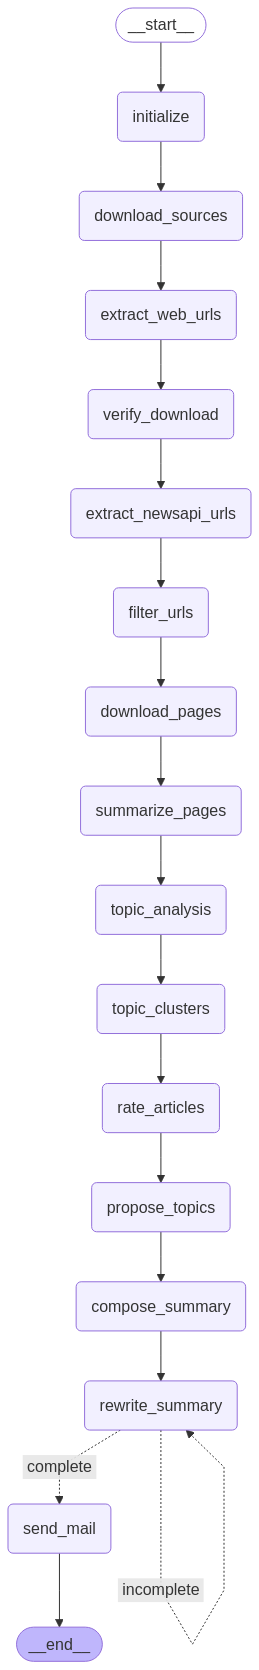

In [12]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
before_date = '2025-05-13 08:00'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [13]:
lg_state = lg_agent.initialize_config(lg_state)


2025-05-13 12:00:30,821 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-05-13 12:00:30,822 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-05-13 12:00:30,822 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-05-13 12:00:30,822 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-05-13 12:00:30,822 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-05-13 12:00:30,823 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly_AI.html
2025-05-13 12:00:30,823 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

In [14]:
lg_state = lg_agent.download_sources(lg_state)


2025-05-13 12:00:31,429 - AInewsbot - INFO - Web fetch disabled, using existing files in htmldata
2025-05-13 12:00:31,430 - AInewsbot - INFO - Found 16 previously downloaded files
2025-05-13 12:00:31,430 - AInewsbot - INFO - htmldata/Techmeme.html
2025-05-13 12:00:31,431 - AInewsbot - INFO - htmldata/Hacker_News_1.html
2025-05-13 12:00:31,431 - AInewsbot - INFO - htmldata/Reddit.html
2025-05-13 12:00:31,431 - AInewsbot - INFO - htmldata/HackerNoon.html
2025-05-13 12:00:31,432 - AInewsbot - INFO - htmldata/VentureBeat.html
2025-05-13 12:00:31,432 - AInewsbot - INFO - htmldata/Feedly_AI.html
2025-05-13 12:00:31,432 - AInewsbot - INFO - htmldata/The_Register.html
2025-05-13 12:00:31,433 - AInewsbot - INFO - htmldata/FT.html
2025-05-13 12:00:31,433 - AInewsbot - INFO - htmldata/Business_Insider.html
2025-05-13 12:00:31,433 - AInewsbot - INFO - htmldata/Washington_Post.html
2025-05-13 12:00:31,434 - AInewsbot - INFO - htmldata/New_York_Times.html
2025-05-13 12:00:31,434 - AInewsbot - INFO -

In [15]:
lg_state = lg_agent.extract_web_urls(lg_state)


2025-05-13 12:00:32,053 - AInewsbot - INFO - Parsing html files
2025-05-13 12:00:32,054 - AInewsbot - INFO - Ars Technica -> htmldata/Ars_Technica.html
2025-05-13 12:00:32,107 - AInewsbot - INFO - parse_file - found 169 raw links
2025-05-13 12:00:32,116 - AInewsbot - INFO - parse_file - found 33 filtered links
2025-05-13 12:00:32,116 - AInewsbot - INFO - 33 links found
2025-05-13 12:00:32,116 - AInewsbot - INFO - Bloomberg -> htmldata/Bloomberg.html
2025-05-13 12:00:32,138 - AInewsbot - INFO - parse_file - found 246 raw links
2025-05-13 12:00:32,141 - AInewsbot - INFO - parse_file - found 36 filtered links
2025-05-13 12:00:32,141 - AInewsbot - INFO - 36 links found
2025-05-13 12:00:32,142 - AInewsbot - INFO - Business Insider -> htmldata/Business_Insider.html
2025-05-13 12:00:32,159 - AInewsbot - INFO - parse_file - found 217 raw links
2025-05-13 12:00:32,162 - AInewsbot - INFO - parse_file - found 22 filtered links
2025-05-13 12:00:32,162 - AInewsbot - INFO - 22 links found
2025-05-13

In [16]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 16


,id
src,
Ars Technica,33
Bloomberg,30
Business Insider,22
FT,65
Feedly AI,33
Hacker News 1,28
Hacker News 2,21
HackerNoon,17
New York Times,19


number of missing sources 0


set()

In [17]:
lg_state = lg_agent.verify_download(lg_state)


2025-05-13 12:00:34,680 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


In [18]:
lg_state = lg_agent.extract_newsapi_urls(lg_state)


2025-05-13 12:00:35,517 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-05-12T12:00:35 from NewsAPI


In [19]:
# filter by headlines that we haven't seen and that look like AI
# we don't want to summarize all before filtering on headline
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


2025-05-13 12:00:37,462 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-05-13 08:00'
2025-05-13 12:00:38,108 - AInewsbot - INFO - URLs in orig_df: 862
2025-05-13 12:00:38,111 - AInewsbot - INFO - Existing URLs in DB: 258051
2025-05-13 12:00:38,168 - AInewsbot - INFO - New URLs in df filtered by URL: 239
2025-05-13 12:00:38,294 - AInewsbot - INFO - Existing src+title: 35
2025-05-13 12:00:38,295 - AInewsbot - INFO - New URLs in df filtered by src+title: 204
2025-05-13 12:00:38,307 - AInewsbot - INFO - Found 204 unique new headlines
2025-05-13 12:00:38,309 - AInewsbot - INFO - Found 202 unique cleaned new headlines
2025-05-13 12:00:40,600 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:00:44,697 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:00:45,405 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

,id
src,
Ars Technica,3
Bloomberg,5
Business Insider,4
FT,1
Feedly AI,23
Hacker News 1,1
Hacker News 2,2
NewsAPI,43
Reddit,4


In [20]:
lg_state = lg_agent.download_pages(lg_state)


2025-05-13 12:00:50,107 - AInewsbot - INFO - Queuing URLs for scraping
2025-05-13 12:00:50,109 - AInewsbot - INFO - Saving HTML files using async concurrency= 8
2025-05-13 12:00:50,258 - AInewsbot - INFO - Launching browser
2025-05-13 12:00:51,291 - AInewsbot - INFO - Launching workers
2025-05-13 12:00:51,292 - AInewsbot - INFO - Launching worker
2025-05-13 12:00:51,292 - AInewsbot - INFO - from queue: 0, https://www.nationalobserver.com/2025/05/12/news/take-it-next-level-oil-gas-industry-players-embrace-ai-other-tech , 'Take it to the next level': Oil and gas industry players embrace AI and other tech
2025-05-13 12:00:51,292 - AInewsbot - INFO - fetch_url(https://www.nationalobserver.com/2025/05/12/news/take-it-next-level-oil-gas-industry-players-embrace-ai-other-tech)
2025-05-13 12:00:51,308 - AInewsbot - INFO - Launching worker
2025-05-13 12:00:51,309 - AInewsbot - INFO - from queue: 1, https://www.zdnet.com/article/100-leading-ai-scientists-map-route-to-more-trustworthy-reliable-se

In [21]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


2025-05-13 12:07:19,910 - AInewsbot - INFO - Starting summarize
2025-05-13 12:07:19,911 - AInewsbot - INFO - Fetching summaries for all articles
2025-05-13 12:07:19,911 - AInewsbot - INFO - Attempting to fetch summaries for 94 articles
2025-05-13 12:07:19,922 - AInewsbot - INFO - clean_html - Page title: 'Take it to the next level': Oil and gas industry players embrace AI and other tech | Canada's National Observer: Climate News
Social card title: 'Take it to the next level': Oil and gas industry players embrace AI and other tech
Social card description: Haul trucks, shovels, pumps and pipes are common sights at Imperial Oil's vast oilsands operations in northeastern Alberta, but so too are robots and drones, with generative artificial intelligence a newer addition to the technological mix.

2025-05-13 12:07:20,087 - AInewsbot - INFO - Queuing 0: Page title: 'Take it to the next level': Oil and g...
2025-05-13 12:07:20,114 - AInewsbot - INFO - clean_html - Page title: 100 leading AI sc

In [22]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state, model_str='gpt-4o-mini')


2025-05-13 12:07:36,097 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-13 12:07:43,351 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:07:45,599 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:07:46,589 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:07:46,897 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:07:47,201 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:07:47,226 - AInewsbot - INFO - 94 free-form topics extracted
2025-05-13 12:07:47,228 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-13 12:07:47,229 - AInewsbot - IN

async_langchain: 0, {'input_text': '### <<<ARTICLE SUMMARY>>>\n# \'Take it to the next level\': Oil and gas industry players embrace AI and other tech\n\n• Oil and gas companies in Canada, including Imperial Oil, Canadian Natural Resources Ltd., and Suncor Energy, are increasingly adopting AI, robotics, and automation technology to boost efficiency, safety, and bottom lines, with Imperial Oil reporting a $700-million gain from these initiatives and targeting $1.2 billion by 2027.\n\n• Technologies in use include self-driving haul trucks, Boston Dynamics\' Spot robots for inspections, AI-enabled drones, and automation systems for pumpjacks, with companies leveraging both in-house and commercial AI solutions; "We\'ve been laser-focused on this digital journey since 2018," said Imperial\'s executive Cheryl Gomez-Smith.\n\n• Companies are also using AI for emission tracking and maintenance planning, while investing in advanced cybersecurity measures as AI-driven cyberattacks become more so

2025-05-13 12:08:26,730 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:26,749 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:26,751 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:26,755 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:26,768 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:26,789 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:26,857 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:26,863 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:26,887 - httpx 

async_langchain: 35 response: items=[]
async_langchain: 67 response: items=[]
async_langchain: 68 response: items=[]
async_langchain: 76 response: items=[]
async_langchain: 63 response: items=['PDF Extraction', 'Text Indexing', 'Search Technology']
async_langchain: 3 response: items=['Deals', 'Mergers and Acquisitions']
async_langchain: 18 response: items=['AWS OpenSearch', 'Data Indexing', 'Search Engine Development', 'Semantic Search', 'Transformers']
async_langchain: 90 response: items=['AI Development', 'AI Training', 'International Investment', 'Kazakhstan', 'Uranium Production', 'Energy', 'Central Asia']
async_langchain: 87 response: items=['AI Chips', 'Nvidia', 'Semiconductor Chips', 'Hardware']
async_langchain: 5 response: items=['AI Therapy', 'Government Surveillance', 'Privacy Concerns', 'Mental Health Data', 'AI Regulation', 'Political Interference']
async_langchain: 0 response: items=['AI Adoption', 'Automation Technology', 'Cybersecurity', 'Emission Tracking', 'Oil and Gas

2025-05-13 12:08:26,967 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:26,977 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:26,985 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:26,989 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:26,999 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:27,000 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:27,001 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:27,016 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:27,017 - httpx 

async_langchain: 8 response: items=['AI Workforce Diversity', 'Generative AI Skills', 'Women In AI', 'AI Training', 'Career Development', 'Training Opportunities']
async_langchain: 75 response: items=['AI DJ', 'Music Personalization', 'Voice Commands', 'User Experience', 'Spotify', 'Streaming']
async_langchain: 2 response: items=['AI Agents', 'AI Implementation Challenges', 'Business Automation', 'Enterprise Workflows', 'Human-AI Collaboration', 'Job Automation']
async_langchain: 91 response: items=['AI Regulation', 'Intellectual Property', 'Copyright Law', 'YouTube Policy', 'Generative AI', 'Fake Accounts', 'Ad Revenue']
async_langchain: 73 response: items=['AI Content Usage', 'AI Training', 'Artist Rights', 'Copyright Law', 'Terms of Service', 'Transparency', 'Music']
async_langchain: 32 response: items=['AI Hallucination Correction', 'Benchmarking Toolkit', 'Generative AI', 'Language Models', 'Vectara Technology']
async_langchain: 13 response: items=['AI Audiobooks', 'AI Translation

2025-05-13 12:08:27,170 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:27,174 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:27,177 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:27,180 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:27,185 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:27,196 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:27,202 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:27,206 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:27,210 - httpx 

async_langchain: 34 response: items=['AI Development', 'AI Workflow Automation', 'Pre-Seed Funding', 'Startup Development', 'ThriveAI', 'Junior Product Manager', 'Venture Capital']
async_langchain: 41 response: items=['AI-Driven Research', 'Biotherapeutic Discovery', 'Epitope Mapping', 'New Approach Methodologies', 'Immunoprecise Antibodies', 'Ethics']
async_langchain: 83 response: items=['AI Interoperability', 'Model Context Protocol', 'Enterprise Adoption', 'AI Integration', 'Industry Consolidation']
async_langchain: 25 response: items=['AI Model Reliability', 'ChatGPT', 'Sycophancy Issues', 'OpenAI Evaluation', 'Model Monitoring', 'Policy and Regulation']
async_langchain: 33 response: items=['AI In Healthcare', 'Medical Diagnostics Growth', 'Mergers And Acquisitions', 'Telehealth Acquisitions', 'AI-Driven Tools']
async_langchain: 57 response: items=['AI Notetaking', 'Productivity Tools', 'Meeting Transcripts', 'Notion', 'AI Integration', 'Competitive Landscape', 'Generative AI']
asy

2025-05-13 12:08:27,401 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:27,414 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:27,428 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:27,458 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:27,482 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:27,575 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:27,590 - AInewsbot - INFO - Received 94 responses
2025-05-13 12:08:27,594 - AInewsbot - INFO - End topic analysis


async_langchain: 39 response: items=['AI-Generated Art', 'Decorative Versus Meaningful Art', 'Artistic Symbolism', 'Reddit Discussions', 'User Experiences']
async_langchain: 80 response: items=['AI Startups', 'AI Integration', 'Human-Centric Business Model', 'Generative AI', 'Revenue Growth', 'Job Automation']
async_langchain: 31 response: items=['Advertising Revenue', 'AI Competition', 'Google I/O 2025', 'Pinterest Alternative', 'Fashion', 'Image Saving Feature', 'Virtual & Augmented Reality']
async_langchain: 72 response: items=['AI Regulation', 'Artist Rights', 'Copyright Issues', 'Generative AI', 'Music', 'SoundCloud', 'Terms of Service']
async_langchain: 17 response: items=['AI Paper Mills', 'Quality Of Scientific Research', 'Health Research', 'Integrity Of Research', 'Policy And Regulation', 'Language Models', 'Data Usage']
async_langchain: 84 response: items=['Cybersecurity', 'Cybersecurity Threats', 'Fake AI Tools', 'Malware Distribution', 'Noodlophile Stealer', 'Scam Campaigns

In [23]:
lg_state = lg_agent.topic_clusters(lg_state)


2025-05-13 12:08:27,606 - AInewsbot - INFO - Fetching embeddings for 94 headlines
2025-05-13 12:08:28,787 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-05-13 12:08:29,169 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-05-13 12:08:29,188 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-05-13 12:08:30,467 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-13 12:08:31,643 - AInewsbot - INFO - Cluster with DBSCAN
2025-05-13 12:08:31,712 - AInewsbot - INFO - Found 5 clusters


,title_topic_str
0,"Your Next Audible Audiobook Could Be Voiced by AI (Topics: AI-Generated Voices, Audible, Audiobook Production, Books & Publishing, Translation Service)"
1,"Audible is expanding its AI-narrated audiobook library (Topics: AI Audiobooks, AI Translation, Publisher Partnerships, Audio Content Expansion, Generative AI)"
2,"Audible partners with US publishers to convert print books and e-books into audiobooks narrated by 100+ AI voices across English, Spanish, French, and Italian (Topics: AI Voices, AI-Narrated Audiobooks, Books & Publishing, Publisher Collaborations, Content Accessibility)"


2025-05-13 12:08:33,183 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:33,214 - AInewsbot - INFO - I dub this cluster: Audible Expands AI-Narrated Audiobooks


,title_topic_str
3,"Soundcloud clarifies it has ""never used artist content to train AI models following Terms Of Service backlash (Topics: AI Regulation, Artist Rights, Copyright Issues, Generative AI, Music, SoundCloud, Terms of Service)"
4,"Opt out or get scraped: UKs AI copyright shakeup has Elton John, Dua Lipa fighting back (Topics: AI Copyright, AI Regulation, Artist Rights, Copyright Law, Music, Policy And Regulation, Uk)"
5,"Copyright Office head fired after reporting AI training isnt always fair use | Cops scuffle with Trump picks at Copyright Office after AI report stuns tech industry. (Topics: AI Fair Use, AI Training, Copyright Law, Political Interference, Shira Perlmutter, Diversity And Inclusion, Us Copyright Office)"
6,"Soundcloud issues statement following Terms Of Service AI update backlash (Topics: AI Content Usage, AI Training, Artist Rights, Copyright Law, Terms of Service, Transparency, Music)"
7,"The US Copyright Chief Was Fired After Raising Red Flags About AI Abuse (Topics: AI Regulation, Copyright Infringement, Copyright Law, Intellectual Property, Legal Issues, US Copyright Office)"


2025-05-13 12:08:33,896 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:33,903 - AInewsbot - INFO - I dub this cluster: AI Copyright and Artist Rights Issues


,title_topic_str
8,"Nvidia to Sell Chips to Saudi AI Firm for Data Center Plan (Topics: AI Chips, Data Centers, Nvidia, Saudi Arabia, Technology Partnership)"
9,"US Weighs Letting UAE Buy Over a Million Advanced Nvidia Chips (Topics: AI Chips, Nvidia, Semiconductor Chips, Hardware)"
10,"Nvidia sending 18,000 of its top AI chips to Saudi Arabia (Topics: AI Chips, AI Infrastructure, International Partnerships, Nvidia, Saudi Arabia, Technology Exports)"
11,"Nvidia sending 18,000 AI GPUs to Saudi Arabia's state-backed AI data centers in wake of cancelled export rules (Topics: AI Infrastructure, Export Regulations, Nvidia, Saudi Arabia, AI Development)"


2025-05-13 12:08:35,845 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:35,855 - AInewsbot - INFO - I dub this cluster: Nvidia AI Chip Exports to Middle East


,title_topic_str
12,"How AI is reshaping the future of informal work in the Global South (Topics: AI in Informal Work, Digital Reputation, Equity in Technology, Labor Mobility, Global South)"
13,"The Big Reason AI Fails At Work, And What Good Managers Do Differently (Topics: AI Integration, AI Rollout, AI Training, Employee Involvement, Workplace Management, Organizational Change)"
14,"Amazon Web Services Says 77% Of Women Want To Build With AI. Whats Holding Them Back? (Topics: AI Workforce Diversity, Generative AI Skills, Women In AI, AI Training, Career Development, Training Opportunities)"


2025-05-13 12:08:37,996 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:38,005 - AInewsbot - INFO - I dub this cluster: Challenges and Opportunities of AI Workforce


,title_topic_str
15,"I'm a VP at Dropbox. This is my advice to product managers in the age of AI. (Topics: AI In Product Management, Innovation, Rapid Technological Change, Job Automation, Collaborative Tools)"
16,"The Rise Of Autonomous Businesses How AI Is Redefining Startup Growth (Topics: AI Startups, AI Integration, Human-Centric Business Model, Generative AI, Revenue Growth, Job Automation)"
17,"AI Agents Will Transform Enterprise Workflows: Nurix AI CEO Mukesh Bansal on the Future of Business Automation - VMblog QA (Topics: AI Agents, AI Implementation Challenges, Business Automation, Enterprise Workflows, Human-AI Collaboration, Job Automation)"


2025-05-13 12:08:39,016 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:39,025 - AInewsbot - INFO - I dub this cluster: AI Transforming Business and Management
2025-05-13 12:08:39,036 - AInewsbot - INFO - ['Audible Expands AI-Narrated Audiobooks', 'AI Copyright and Artist Rights Issues', 'Nvidia AI Chip Exports to Middle East', 'Challenges and Opportunities of AI Workforce', 'AI Transforming Business and Management']


In [24]:
lg_state = lg_agent.rate_articles(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
aidf


2025-05-13 12:08:39,063 - AInewsbot - INFO - Calculating article rating for 94 articles
2025-05-13 12:08:39,063 - AInewsbot - INFO - Starting low_quality filter
2025-05-13 12:08:43,692 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:44,337 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:44,349 - AInewsbot - INFO - low quality articles: {0: 79, 1: 15}
2025-05-13 12:08:44,349 - AInewsbot - INFO - Starting on_topic filter
2025-05-13 12:08:48,672 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:49,668 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:08:49,680 - AInewsbot - INFO - on topic articles: {1: 82, 0: 12}
2025-05-13 12:08:49,681 - AInewsbot - INFO - Starting importance filter
2025-05-13 12:09:01,234 - httpx - INFO - HTTP Reques

,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,sort_order,cluster,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating
0,0,https://www.cnet.com/tech/services-and-softwar...,Feedly AI,Your Next Audible Audiobook Could Be Voiced by AI,True,https://www.cnet.com/tech/services-and-softwar...,www.cnet.com,CNET,2,htmlpages/Your_Next_Audible_Audiobook_Could_Be...,...,18,0,Audible Expands AI-Narrated Audiobooks,0,1,1,896.503420,-1.062560,1.066326,4.535046
1,1,https://techcrunch.com/2025/05/13/audible-is-e...,Feedly AI,Audible is expanding its AI-narrated audiobook...,True,https://techcrunch.com/2025/05/13/audible-is-e...,techcrunch.com,TechCrunch,2,htmlpages/Audible_is_expanding_its_AI-narrated...,...,19,0,Audible Expands AI-Narrated Audiobooks,0,1,1,978.500767,-0.220724,1.382737,5.272375
2,2,https://www.bloomberg.com/news/articles/2025-0...,Techmeme,Audible partners with US publishers to convert...,True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,4,,...,20,0,Audible Expands AI-Narrated Audiobooks,0,1,1,1063.382545,0.650724,0.000000,6.325362
3,3,https://djmag.com/news/soundcloud-clarifies-it...,NewsAPI,"Soundcloud clarifies it has ""never used artist...",True,https://djmag.com/news/soundcloud-clarifies-it...,djmag.com,djmag.com,0,htmlpages/Soundcloud_clarifies_it_has__never_u...,...,32,1,AI Copyright and Artist Rights Issues,0,1,1,942.541160,-0.589908,1.735439,3.440485
4,4,https://www.cnbc.com/2025/05/12/uk-ai-copyrigh...,NewsAPI,Opt out or get scraped: UKs AI copyright shake...,True,https://www.cnbc.com/2025/05/12/uk-ai-copyrigh...,www.cnbc.com,CNBC,1,htmlpages/Opt_out_or_get_scraped__UKs_AI_copyr...,...,52,1,AI Copyright and Artist Rights Issues,0,1,1,1053.216839,0.546357,1.530840,4.804018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,89,https://www.theregister.com/2025/05/13/ai_junk...,The Register,Boffins warn that AI paper mills are swamping ...,True,https://www.theregister.com/2025/05/13/ai_junk...,www.theregister.com,The Register,2,htmlpages/Boffins_warn_that_AI_paper_mills_are...,...,89,999,,0,1,1,1059.000958,0.605740,1.755036,6.057906
86,90,https://venturebeat.com/ai/beyond-detection-wh...,VentureBeat,Guardian agents: New approach could reduce AI ...,True,https://venturebeat.com/ai/beyond-detection-wh...,venturebeat.com,VentureBeat,1,htmlpages/Guardian_agents__New_approach_could_...,...,90,999,,0,1,1,1072.158868,0.740827,1.942207,5.312620
87,91,https://gizmodo.com/chatgpt-vs-nazi-encryption...,Feedly AI,ChatGPT vs. Nazi Encryption: Why Enigma Wouldn...,True,https://gizmodo.com/chatgpt-vs-nazi-encryption...,gizmodo.com,Gizmodo,2,htmlpages/ChatGPT_vs._Nazi_Encryption__Why_Eni...,...,91,999,,0,1,0,876.868025,-1.264149,1.471438,3.839364
88,92,https://phys.org/news/2025-05-labs-enable-fast...,NewsAPI,Self-driving labs enable faster and smarter po...,True,https://phys.org/news/2025-05-labs-enable-fast...,phys.org,Phys.org,1,htmlpages/Self-driving_labs_enable_faster_and_...,...,92,999,,0,1,1,1024.819981,0.254817,1.810233,4.937641


In [25]:
# gemini flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state)


2025-05-13 12:15:30,712 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-13 12:15:30,715 - AInewsbot - INFO - Initial cluster topics: 
Audible Expands AI-Narrated Audiobooks
AI Copyright and Artist Rights Issues
Nvidia AI Chip Exports to Middle East
Challenges and Opportunities of AI Workforce
AI Transforming Business and Management
2025-05-13 12:16:25,152 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-13 12:16:25,175 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
Audible Expands AI-Narrated Audiobooks
AI Copyright and Artist Rights Issues
Nvidia AI Chip Exports to Middle East
Challenges and Opportunities of AI Workforce
AI Transforming Business and Management
Trump's $600B Saudi AI Deal
Singapore AI Safety Consensus
US Copyright Chief Ousted
SoftBank's AI Investments
Federal Ban On AI Regulation
AI Paper M

In [ ]:
# compose and rewrite summary
# o3 is best but expensive
# o3 has high STEM comprehension
# gpt-4.1 probably best, has good complex flows
# gpt 4.1-mini is supposed to still be good at complex flows but maybe not as good at comprehension
# uses structured output with JSON schema to ensure proper structure and formatting
# https://cookbook.openai.com/examples/partners/model_selection_guide/model_selection_guide#appendices
MAX_EDITS=2

lg_state = lg_agent.compose_summary(lg_state)
display(Markdown(lg_state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break
    lg_state = lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))


In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [ ]:
with open('aidf.pkl', 'wb') as f:
    pickle.dump(lg_agent.state["AIdf"], f)

In [ ]:
with open('data.pkl', 'rb') as f:
    lg_state = pickle.load(f)

lg_state


In [ ]:
with open('aidf.pkl', 'rb') as f:
    lg_state['AIdf'] = pickle.load(f)

lg_state


In [ ]:
lg_agent.state = lg_state


In [ ]:
aidf = pd.DataFrame(lg_agent.state["AIdf"]) 
aidf.sort_values("elo_z", ascending=False)

In [ ]:
aidf.to_pickle("aidf.pkl")


In [30]:
aidf = pd.DataFrame(lg_state['AIdf'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None,     'display.max_colwidth', None):
    display(aidf[['title', 'rating']].sort_values('rating', ascending=False))


,title,rating
62,Trump speaks to Saudi forum after agreeing $600bn AI and defence deal,7.207608
22,"100 leading AI scientists map route to more 'trustworthy, reliable, secure' AI",6.624414
7,The US Copyright Chief Was Fired After Raising Red Flags About AI Abuse,6.415682
2,"Audible partners with US publishers to convert print books and e-books into audiobooks narrated by 100+ AI voices across English, Spanish, French, and Italian",6.325362
11,"Nvidia sending 18,000 AI GPUs to Saudi Arabia's state-backed AI data centers in wake of cancelled export rules",6.267617
76,"IPAs LENSaiTM Platform Delivers X-RayLevel Epitope Mapping Insights in Hours, Matching Gold-Standard Methods with Greater Speed",6.199683
36,SoftBank turned a corner. All eyes are now on its big AI bets.,6.156721
23,GOP sneaks decade-long AI regulation ban into spending bill,6.083876
5,Copyright Office head fired after reporting AI training isnt always fair use | Cops scuffle with Trump picks at Copyright Office after AI report stuns tech industry.,6.069356
85,Boffins warn that AI paper mills are swamping science with garbage studiesResearch flags rise in one-dimensional health research fueled by large language modelsAI + ML3 hrs|15,6.057906


# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


In [ ]:
# train dimensionality reduction model, cluster and chart silhouette scores

import pandas as pd
import numpy as np
from openai import OpenAI
import umap
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Get embeddings
client = OpenAI()
summaries = df['summary'].tolist()
response = client.embeddings.create(input=summaries, model='text-embedding-3-large')
embeddings = np.array([e.model_dump()['embedding'] for e in response.data])

# 2. Try a range of UMAP output dimensions
dims_to_try = [5, 10, 15, 20, 30, 40, 50]
scores = []
best_score = -1
best_dim = None

for n_dim in dims_to_try:
    reducer = umap.UMAP(n_components=n_dim, random_state=42)
    reduced = reducer.fit_transform(embeddings)
    # 3. Cluster with DBSCAN (tune eps/min_samples as needed)
    labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(reduced)
    # Ignore noise points for silhouette
    mask = labels != -1
    if np.sum(mask) > 1 and len(set(labels[mask])) > 1:
        score = silhouette_score(reduced[mask], labels[mask])
    else:
        score = -1
    scores.append(score)
    if score > best_score:
        best_score = score
        best_dim = n_dim

# 4. Plot silhouette score vs. UMAP dimensions
plt.plot(dims_to_try, scores, marker='o')
plt.xlabel('UMAP output dimensions')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score vs. UMAP Dimensions')
plt.show()

print(f"Best UMAP dimension: {best_dim} (Silhouette Score: {best_score:.3f})")

# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))


In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
from pathlib import Path
from playwright.sync_api import sync_playwright

PROFILE_DIR = Path.home() / ".playwright_profiles" / "nytimes_firefox"
PROFILE_DIR.mkdir(parents=True, exist_ok=True)  # make sure it exists

FIREFOX_PROFILE_PATH = '/Users/drucev/Library/Application Support/Firefox/Profiles/k8k0lcjj.default-release'

with async_playwright() as p:
    # ⬇️ one context *per* run – but data stays on disk
    context = p.firefox.launch_persistent_context(
        user_data_dir=FIREFOX_PROFILE_PATH,   # <— key line
        headless=False,                   # watch it the first time so you can log in
        viewport={"width": 1280, "height": 800},
        accept_downloads=True,
    )
    page = context.new_page()
    page.goto("https://www.nytimes.com/")
    # 👉 First run: click “Log in” and complete the flow manually.
    # 👉 Later runs: cookies are already there, you’ll be signed in automatically.

    # …do your scraping…
    context.close()